In [ ]:
import pandas as pd
import os
from tkinter import filedialog
import tkinter as tk
import re

def convert_to_minutes(time_value, unit='min'):
    """Convert time values to minutes regardless of input unit"""
    try:
        if unit.lower() in ['sec', 's']:
            return float(time_value) / 60
        return float(time_value)
    except ValueError:
        return None

def extract_metadata_from_filename(filename):
    """Extract metadata specifically from the filename pattern seen in the logs"""
    # Pattern: "4% gelatin_{cycles}_replicate_{number}_metrics.xlsx"
    metadata = {}
    
    # Extract cycles
    cycles_match = re.search(r'(\d+)\s*cycles', filename)
    if cycles_match:
        metadata['cycles'] = cycles_match.group(1)
    
    # Extract replicate number
    replicate_match = re.search(r'replicate_(\d+)', filename)
    if replicate_match:
        metadata['replicate'] = replicate_match.group(1)
    
    # Extract concentration (if present)
    concentration_match = re.search(r'(\d+)%\s*gelatin', filename)
    if concentration_match:
        metadata['concentration'] = concentration_match.group(1)
    
    return metadata

def extract_metadata(file_path):
    """Extract metadata from the file path"""
    filename = os.path.basename(file_path)
    path_parts = file_path.split(os.sep)
    
    # First try to extract from filename directly (for the gelatin pattern)
    metadata = extract_metadata_from_filename(filename)
    if metadata.get('cycles') and metadata.get('replicate'):
        return metadata
    
    # If that fails, fall back to the original method
    metadata = {}
    
    # Define frequency-cycles mapping - only used for informational purposes now
    frequency_cycles = {
        '0': ['0'],  # untreated control
        '28': ['3', '6', '11', '22'],
        '40': ['4', '8', '16', '32'],
        '80': ['8', '16', '32', '64'],
        '120': ['12', '24', '48', '96'],
        '1100': ['110', '220']  # 1.1 MHz converted to kHz for consistency
    }
    
    # Extract frequency and cycles
    frequency = None
    cycles = None
    
    # Check the filename first for cycles
    # IMPORTANT CHANGE: Look for cycles in the path and always keep what we find
    for part in path_parts + [filename]:
        cycles_match = re.search(r'(\d+)\s*cycles', part.lower())
        if cycles_match:
            cycles = cycles_match.group(1)
            metadata['cycles'] = cycles  # Always store cycles when found
            break
    
    # First look for frequency in the path
    for part in path_parts:
        # Remove spaces and standardize the format
        clean_part = part.lower().replace(" ", "")
        
        # Special handling for 0 kHz case
        if '0khz' in clean_part or ('0' in clean_part and 'cycles' in clean_part):
            frequency = '0'
            metadata['frequency'] = '0'
            break
        
        # Check for kHz or MHz
        if 'khz' in clean_part:
            # Split on 'khz' and take the first part
            freq_part = clean_part.split('khz')[0].strip()
            # Extract only the numeric part before any dash
            freq_part = freq_part.split('-')[0].strip()
            try:
                # Handle cases where there might be additional characters
                freq_part = ''.join(filter(lambda x: x.isdigit() or x == '.', freq_part))
                if freq_part:  # Make sure we have a number
                    frequency = str(int(float(freq_part)))
                    metadata['frequency'] = frequency
            except ValueError:
                continue
        elif 'mhz' in clean_part:
            freq_part = clean_part.split('mhz')[0].strip()
            try:
                # Convert MHz to kHz for consistency
                freq_part = ''.join(filter(lambda x: x.isdigit() or x == '.', freq_part))
                frequency = str(int(float(freq_part) * 1000))
                metadata['frequency'] = frequency
            except ValueError:
                continue
    
    # CHANGED: Frequency-cycles relationship is now just informational
    # We don't discard cycles if we can't find frequency or if they don't match
    if frequency and cycles and frequency in frequency_cycles:
        valid_combination = cycles in frequency_cycles[frequency]
        if not valid_combination:
            print(f"Warning: Unusual frequency-cycles combination: {frequency}kHz - {cycles}cycles")
    
    # Extract replicate if not already found
    if 'replicate' not in metadata:
        for part in path_parts:
            if 'replicate' in part.lower():
                try:
                    replicate = part.split('replicate_')[1].split('_')[0]
                    metadata['replicate'] = replicate
                except IndexError:
                    # Try alternative format
                    replicate = ''.join(filter(str.isdigit, part))
                    if replicate:
                        metadata['replicate'] = replicate
                break
        
        # If not found in directories, check filename for rep_X pattern
        if 'replicate' not in metadata:
            rep_match = re.search(r'rep_(\d+)', filename)
            if rep_match:
                metadata['replicate'] = rep_match.group(1)
    
    # Extract treatment time
    for part in path_parts:
        if 'min' in part.lower():
            try:
                time_str = part.lower().split('min')[0].strip()
                time_val = convert_to_minutes(time_str, 'min')
                if time_val is not None:
                    metadata['time'] = str(time_val)
                break
            except ValueError:
                continue
        elif 's' in part.lower() and part.lower().replace('s', '').strip().isdigit():
            try:
                time_str = part.lower().replace('s', '').strip()
                time_val = convert_to_minutes(time_str, 's')
                if time_val is not None:
                    metadata['time'] = str(time_val)
                break
            except ValueError:
                continue
    
    # Extract concentration if not already found
    if 'concentration' not in metadata:
        for part in path_parts:
            if 'ug-ml' in part.lower():
                try:
                    conc = part.lower().split('ug-ml')[0].strip()
                    metadata['concentration'] = conc
                    break
                except ValueError:
                    continue
            elif '%' in part:
                concentration_match = re.search(r'(\d+)%', part)
                if concentration_match:
                    metadata['concentration'] = concentration_match.group(1)
                    break
    
    return metadata

def create_sheet_name(metadata):
    """Create a sheet name based on available metadata"""
    
    # For gelatin files, use a specific format
    if 'concentration' in metadata and 'cycles' in metadata and 'replicate' in metadata:
        # For gelatin pattern, create a more descriptive sheet name
        return f"{metadata['cycles']}C_R{metadata['replicate']}"
    
    # Otherwise use the original format
    parts = []
    
    # Frequency and Cycles
    if 'frequency' in metadata:
        if metadata['frequency'] == '0':
            parts.append('Control')  # or '0kHz' if you prefer
        elif metadata['frequency'] == '1100':
            parts.append('1.1MHz')
        else:
            parts.append(f"{metadata['frequency']}kHz")
    
    if 'cycles' in metadata and metadata.get('frequency', '') != '0':  # Don't show cycles for control
        parts.append(f"{metadata['cycles']}C")
    
    # Treatment time
    if 'time' in metadata:
        parts.append(f"{metadata['time']}m")
    
    # Concentration
    if 'concentration' in metadata:
        parts.append(f"{metadata['concentration']}c")
    
    # Replicate
    if 'replicate' in metadata:
        parts.append(f"R{metadata['replicate']}")
    
    return '_'.join(parts)

def find_excel_files(directory):
    excel_files = []
    
    # Store files by their unique identifiers to avoid duplicates
    # CHANGED: Use full path as unique key instead of (cycles, replicate)
    unique_files = {}  # Key: full path, Value: (path, metadata)
    
    for root, dirs, files in os.walk(directory):
        # More aggressive filtering for directories to skip
        # Remove any directory that contains 'blank' or 'Blank' anywhere in the name
        dirs_to_remove = []
        for d in dirs:
            if 'blank' in d.lower() or 'merged_analyses' in d.lower():
                dirs_to_remove.append(d)
        
        for d in dirs_to_remove:
            if d in dirs:
                dirs.remove(d)
        
        for file in files:
            if ('metrics' in root or 'metrics' in file.lower()) and \
               file.endswith('.xlsx') and \
               not file.startswith('~') and \
               'blank_statistics' not in file and \
               'blank' not in root.lower():  # Also check if 'blank' is in the path
                
                full_path = os.path.join(root, file)
                metadata = extract_metadata(full_path)
                
                # Only process if we have required metadata
                if metadata.get('cycles') is not None and metadata.get('replicate') is not None:
                    # CHANGED: Use full path as unique key to prevent duplicates
                    file_key = full_path
                    
                    # Only add if this unique file is not already in our collection
                    if file_key not in unique_files:
                        unique_files[file_key] = (full_path, metadata)
                    else:
                        print(f"Skipping duplicate file: {os.path.basename(full_path)}")
                        print(f"  Already have: {os.path.basename(unique_files[file_key][0])}")
                else:
                    print(f"Warning: Could not extract required metadata from {file}, skipping")
                    print(f"  Path: {full_path}")
                    print(f"  Extracted metadata: {metadata}")
    
    # Convert dictionary to list of tuples
    for file_key, (file_path, metadata) in unique_files.items():
        excel_files.append((file_path, metadata))
    
    # Sort files by cycles and replicate for predictable processing order
    excel_files.sort(key=lambda x: (int(x[1]['cycles']), int(x[1]['replicate'])))
    
    return excel_files

def merge_excel_files():
    """Main function to merge Excel files - modified to create only a single merged file"""
    root = tk.Tk()
    root.withdraw()
    root.attributes('-topmost', True)
    
    selected_dir = filedialog.askdirectory(title="Select Directory")
    root.attributes('-topmost', False)
    
    if not selected_dir:
        print("No directory selected")
        return

    excel_files = find_excel_files(selected_dir)
    if not excel_files:
        print("No Excel files found")
        return
    
    print(f"\nFound {len(excel_files)} files")
    
    # Print a summary of found files
    cycle_groups = {}
    for _, metadata in excel_files:
        cycles = metadata.get('cycles', 'Unknown')
        if cycles not in cycle_groups:
            cycle_groups[cycles] = 0
        cycle_groups[cycles] += 1
    
    print("Files by cycle group:")
    for cycles, count in cycle_groups.items():
        print(f"  {cycles} cycles: {count} files")
    
    # Create the merged_analyses folder in the selected directory
    save_dir = os.path.join(selected_dir, 'merged_analyses')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Try to get all possible sheet names from all files
    all_sheets = set()
    for file_path, _ in excel_files:
        try:
            file_sheets = pd.ExcelFile(file_path).sheet_names
            all_sheets.update(file_sheets)
        except Exception as e:
            print(f"Error reading sheets from {os.path.basename(file_path)}: {e}")
    
    sheet_names = list(all_sheets)
    print(f"Found sheets: {sheet_names}")

    # Process each sheet type
    for sheet_type in sheet_names:
        # Create subdirectories inside merged_analyses
        sheet_dir = os.path.join(save_dir, sheet_type.replace(" ", "_"))
        if not os.path.exists(sheet_dir):
            os.makedirs(sheet_dir)
        
        print(f"\nProcessing sheet type: {sheet_type}")
        
        # Create a workbook for all files
        all_output_file = os.path.join(sheet_dir, f'Merged_{sheet_type.replace(" ", "_")}.xlsx')
        with pd.ExcelWriter(all_output_file, engine='openpyxl') as writer:
            for file_path, metadata in excel_files:
                try:
                    print(f"\nProcessing file:")
                    print(f"Workbook: {os.path.basename(file_path)}")
                    
                    sheet_name = create_sheet_name(metadata)
                    print(f"Created sheet name: {sheet_name}")
                    
                    # Skip if sheet doesn't exist in this file
                    try:
                        df = pd.read_excel(file_path, sheet_name=sheet_type)
                        df.to_excel(writer, sheet_name=sheet_name, index=False)
                    except ValueError:
                        print(f"Sheet '{sheet_type}' not found in {os.path.basename(file_path)}")
                        continue
                except Exception as e:
                    print(f"Error processing {os.path.basename(file_path)}: {e}")
        
        print(f"Created merged file: {all_output_file}")
    
    print("\nAll files created in:", save_dir)
    root.destroy()
    return save_dir

if __name__ == "__main__":
    print("Starting Excel file merge process...")
    save_dir = merge_excel_files()
    if save_dir:
        print(f"Process completed successfully. Files saved to: {save_dir}")
    else:
        print("Process was cancelled or encountered an error.")

Starting Excel file merge process...
  Path: C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/Gel microscopy/12MAR25\1 cycle\stitched_image\metrics\replicate_1\replicate_1_metrics.xlsx
  Extracted metadata: {'replicate': '1'}
  Path: C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/Gel microscopy/12MAR25\1 cycle\stitched_image\metrics\replicate_2\replicate_2_metrics.xlsx
  Extracted metadata: {'replicate': '2'}
  Path: C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/Gel microscopy/12MAR25\1 cycle\stitched_image\metrics\replicate_3\replicate_3_metrics.xlsx
  Extracted metadata: {'replicate': '3'}
  Path: C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/Gel microscopy/12MAR25\1 cycle\stit

In [9]:
# To actually read and display the structure of your files, you could use this code:
def display_file_structure(save_dir):
    for root, dirs, files in os.walk(save_dir):
        for file in files:
            if file.endswith('.xlsx'):
                print(f"\nAnalyzing {file}:")
                excel_file = pd.ExcelFile(os.path.join(root, file))
                
                # Display sheet names
                print("Sheets:", excel_file.sheet_names)
                
                # Display structure of first sheet
                first_sheet = pd.read_excel(excel_file, sheet_name=excel_file.sheet_names[0])
                print("\nStructure of first sheet:")
                print(first_sheet.head())
                print("\nColumns:", first_sheet.columns.tolist())
                
                # Display basic info about the data
                print("\nData Info:")
                print(first_sheet.info())
                print("-" * 80)

# You can call this function like this:
display_file_structure(save_dir)


Analyzing Merged_Analysis_Metrics.xlsx:
Sheets: ['Control_R1', 'Control_R2', 'Control_R3', 'Control_R4', 'Control_R5', 'Control_R6', '1.1MHz_110C_R1', '1.1MHz_110C_R2', '1.1MHz_110C_R3', '1.1MHz_110C_R4', '1.1MHz_110C_R5', '1.1MHz_110C_R6', '1.1MHz_220C_R1', '1.1MHz_220C_R2', '1.1MHz_220C_R3', '1.1MHz_220C_R4', '1.1MHz_220C_R5', '1.1MHz_220C_R6', '120kHz_12C_R1', '120kHz_12C_R2', '120kHz_12C_R3', '120kHz_12C_R4', '120kHz_12C_R5', '120kHz_12C_R6', '120kHz_24C_R1', '120kHz_24C_R2', '120kHz_24C_R3', '120kHz_24C_R4', '120kHz_24C_R5', '120kHz_24C_R6', '120kHz_48C_R1', '120kHz_48C_R2', '120kHz_48C_R3', '120kHz_48C_R4', '120kHz_48C_R5', '120kHz_48C_R6', '120kHz_96C_R1', '120kHz_96C_R2', '120kHz_96C_R3', '120kHz_96C_R4', '120kHz_96C_R5', '120kHz_96C_R6', '28kHz_11C_R1', '28kHz_11C_R2', '28kHz_11C_R3', '28kHz_11C_R4', '28kHz_11C_R5', '28kHz_11C_R6', '28kHz_22C_R1', '28kHz_22C_R2', '28kHz_22C_R3', '28kHz_22C_R4', '28kHz_22C_R5', '28kHz_22C_R6', '28kHz_3C_R1', '28kHz_3C_R2', '28kHz_3C_R3', '28kH

### Average metrics

In [10]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import tkinter as tk
from tkinter import filedialog
import re

def autofit_columns(worksheet):
    """Autofit column widths in an Excel worksheet"""
    for column in worksheet.columns:
        max_length = 0
        column_letter = column[0].column_letter
        
        # Get maximum length of column data
        for cell in column:
            try:
                if cell.value:
                    max_length = max(max_length, len(str(cell.value)))
            except:
                pass
        
        # Set column width
        adjusted_width = (max_length + 2) * 1.2
        worksheet.column_dimensions[column_letter].width = adjusted_width




def extract_metadata(file_path):
    """Extract voltage information from the file path"""
    path_parts = file_path.split(os.sep)
    metadata = {}
    
    # Look for voltage (mVpp)
    for part in path_parts:
        if 'mvpp' in part.lower():
            voltage = part.split('mvpp')[0].strip().split('_')[-1]
            metadata['voltage'] = voltage
            break
    
    # Get replicate information if available
    for part in path_parts:
        if 'replicate' in part.lower():
            replicate = part.split('replicate_')[1].split('_')[0]
            metadata['replicate'] = replicate
            break
    
    return metadata

def find_excel_files(directory):
    """Find all Excel files and extract their metadata"""
    excel_files = []
    skip_dirs = ['Blank', 'Other directory to skip', 'Another directory']
    
    for root, dirs, files in os.walk(directory):
        # Remove unwanted directories
        for skip_dir in skip_dirs:
            if skip_dir in dirs:
                dirs.remove(skip_dir)
        
        for file in files:
            if 'metrics' in root and file.endswith('.xlsx') and not file.startswith('~$'):
                full_path = os.path.join(root, file)
                metadata = extract_metadata(full_path)
                
                print("\nFound Excel file:")
                print(f"Workbook name: {file}")
                print(f"Metadata: {metadata}")
                print(f"Full path: {full_path}")
                
                excel_files.append((full_path, metadata))
    
    return excel_files

def create_sheet_name(metadata):
    """Create a sheet name based on voltage metadata"""
    parts = []
    
    if 'voltage' in metadata:
        parts.append(f"{metadata['voltage']}mVpp")
    
    if 'replicate' in metadata:
        parts.append(f"R{metadata['replicate']}")
        
    return '_'.join(parts)

def calculate_com_metrics(distances, intensities, uncertainties):
    try:
        # Remove any NaN values
        mask = ~(np.isnan(distances) | np.isnan(intensities) | np.isnan(uncertainties))
        distances = distances[mask]
        intensities = intensities[mask]
        uncertainties = uncertainties[mask]
        
        # Ensure we have valid data
        if len(distances) == 0 or np.all(intensities == 0):
            return {
                'COM_Position': None,
                'COM_Position_Error': None
            }
        
        # Calculate COM directly using distances from bottom
        total_intensity = np.sum(intensities)
        com = np.sum(distances * intensities) / total_intensity
        
        # Error propagation for COM
        partial_derivatives = (distances * total_intensity - np.sum(distances * intensities)) / (total_intensity ** 2)
        com_error = np.sqrt(np.sum((partial_derivatives * uncertainties) ** 2))
        
        return {
            'COM_Position': com,
            'COM_Position_Error': com_error
        }
        
    except Exception as e:
        print(f"Error in calculate_com_metrics: {str(e)}")
        return {
            'COM_Position': None,
            'COM_Position_Error': None
        }



def calculate_all_metrics(df, normalized=False, baseline_com=None):
    """Calculate threshold and intensity analysis metrics"""
    try:
        metrics = {}
        
        if normalized:
            intensity_col = 'Normalized Average Intensity'
            uncertainty_col = 'Population Std Dev'
        else:
            intensity_col = 'Average Intensity'
            uncertainty_col = 'Intensity Error'
        
        # Now using Distance from bottom
        distances = df['Distance from bottom (mm)']
        intensities = df[intensity_col]
        uncertainties = df[uncertainty_col]
        
        # Calculate COM metrics
        com_metrics = calculate_com_metrics(distances, intensities, uncertainties)
        metrics.update(com_metrics)
        
        # Calculate COM shift if baseline is provided
        if baseline_com is not None and isinstance(baseline_com, tuple) and com_metrics['COM_Position'] is not None:
            baseline_value, baseline_error = baseline_com
            com_shift = com_metrics['COM_Position'] - baseline_value
            shift_error = np.sqrt(com_metrics['COM_Position_Error']**2 + baseline_error**2)
            
            metrics.update({
                'COM_Net_Shift': com_shift,
                'COM_Net_Shift_Error': shift_error
            })
        
        # Continue with existing metrics calculations
        interface_idx = np.argmin(np.abs(df['Distance from Interface (mm)']))
        interface_intensity = df[intensity_col].iloc[interface_idx]
        
        min_distance = df['Distance from Interface (mm)'].min()
        interface_from_edge = abs(min_distance)
        
        mask = df['Distance from Interface (mm)'] >= 0
        distances_from_interface = df['Distance from Interface (mm)'][mask]
        intensities_interface = df[intensity_col][mask]
        uncertainties_interface = df[uncertainty_col][mask]
        
        sort_idx = np.argsort(distances_from_interface)
        distances_from_interface = distances_from_interface.iloc[sort_idx]
        intensities_interface = intensities_interface.iloc[sort_idx]
        uncertainties_interface = uncertainties_interface.iloc[sort_idx]
        
        peak_intensity = intensities_interface.max()
        peak_intensity_idx = intensities_interface.idxmax()
        peak_distance = distances_from_interface.iloc[peak_intensity_idx]
        
        # Calculate threshold metrics
        for base in ['Interface', 'Peak']:
            base_intensity = interface_intensity if base == 'Interface' else peak_intensity
            for percentage in [75, 50, 25, 10, 1]:
                threshold = (percentage/100) * base_intensity
                threshold_name = f'{percentage}% {base}'
                
                crossing_idx = np.where(intensities_interface <= threshold)[0]
                
                if len(crossing_idx) > 0:
                    first_crossing = crossing_idx[0]
                    metrics.update({
                        f'{threshold_name} Penetration Depth from Interface (mm)': distances_from_interface.iloc[first_crossing],
                        f'{threshold_name} Penetration Depth from Edge (mm)': distances_from_interface.iloc[first_crossing] + interface_from_edge,
                        f'{threshold_name} Depth Error (mm)': uncertainties_interface.iloc[first_crossing],
                        f'{threshold_name} Intensity': intensities_interface.iloc[first_crossing],
                        f'{threshold_name} Intensity Error': uncertainties_interface.iloc[first_crossing],
                        f'{threshold_name} Target Intensity': threshold
                    })
                else:
                    metrics.update({
                        f'{threshold_name} Penetration Depth from Interface (mm)': None,
                        f'{threshold_name} Penetration Depth from Edge (mm)': None,
                        f'{threshold_name} Depth Error (mm)': None,
                        f'{threshold_name} Intensity': None,
                        f'{threshold_name} Intensity Error': None,
                        f'{threshold_name} Target Intensity': threshold
                    })
        
        # Add distance measurements
        metrics.update({
            'Interface Distance from Edge (mm)': interface_from_edge,
            'Peak Distance from Interface (mm)': peak_distance,
            'Peak Distance from Edge (mm)': peak_distance + interface_from_edge,
            'Peak Intensity': peak_intensity,
            'Peak Intensity Error': uncertainties_interface.iloc[peak_intensity_idx],
            'Mean Intensity': np.mean(intensities_interface),
            'Max Intensity': np.max(intensities_interface),
            'Min Intensity': np.min(intensities_interface),
            'Intensity Std Dev': np.std(intensities_interface),
            'Interface Intensity': interface_intensity,
            'Interface Intensity Error': df[uncertainty_col].iloc[interface_idx]
        })
        
        # Calculate gradient metrics
        gradient = np.gradient(intensities_interface.values, distances_from_interface.values)
        metrics.update({
            'Max Gradient': np.min(gradient),
            'Max Gradient Error': np.std(gradient)
        })
        
        # Calculate particle load
        particle_load = np.trapz(intensities_interface.values, distances_from_interface.values)
        particle_load_error = np.sqrt(np.sum(uncertainties_interface.values**2)) * np.mean(np.diff(distances_from_interface.values))
        metrics.update({
            'Particle Load': particle_load,
            'Particle Load Error': particle_load_error
        })
        
        # Initialize skewness metrics with None
        metrics.update({
            'Skewness': None,
            'Skewness Error': None
        })
        
        # Calculate skewness only if enough points
        if len(intensities_interface) >= 8:
            try:
                skewness = stats.skew(intensities_interface)
                skewness_error = stats.skewtest(intensities_interface)[1]
                metrics.update({
                    'Skewness': skewness,
                    'Skewness Error': skewness_error
                })
            except Exception as e:
                print(f"Error calculating skewness: {str(e)}")
        
        return metrics
        
    except Exception as e:
        print(f"Error in calculate_all_metrics: {str(e)}")
        return {}

def calculate_weighted_metrics(df, analysis_metrics_df, save_dir, sheet_name):
    """Calculate both weighted and non-weighted metrics"""
    base_metrics = calculate_all_metrics(df, normalized=False, baseline_com=None)
    
    # Define bottom region (everything below interface)
    bottom_mask = df['Distance from Interface (mm)'] < 0
    
    # Calculate area weight from bottom region proportion
    area_weight = len(df[bottom_mask]) / len(df)  

    # Calculate intensity weight from same bottom region
    bottom_intensity = df[bottom_mask]['Average Intensity'].mean()
    intensity_weight = bottom_intensity / df['Average Intensity'].mean()
    
    # Combined weight
    combined_weight = area_weight * intensity_weight
    
    # Calculate weighted metrics
    weighted_metrics = {}
    for key, value in base_metrics.items():
        weighted_key = f'Weighted_{key}'
        if isinstance(value, (int, float)) and value is not None:
            weighted_metrics[weighted_key] = value * combined_weight
        else:
            weighted_metrics[weighted_key] = None
    
    # Add weights to metrics dictionary
    weighted_metrics.update({
        'Area_Weight': area_weight,
        'Intensity_Weight': intensity_weight,
        'Combined_Weight': combined_weight
    })
    
    # Merge base and weighted metrics
    all_metrics = {**base_metrics, **weighted_metrics}
    
    return all_metrics

def merge_excel_files():
    root = tk.Tk()
    root.withdraw()
    root.attributes('-topmost', True)
    
    directory = filedialog.askdirectory(title="Select Directory")
    root.attributes('-topmost', False)
    
    if not directory:
        print("No directory selected")
        return

    excel_files = find_excel_files(directory)
    if not excel_files:
        print("No Excel files found")
        return
    
    print(f"\nFound {len(excel_files)} files")
    
    parent_dir = os.path.dirname(directory)
    save_dir = os.path.join(parent_dir, 'merged_analyses')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    first_file = pd.ExcelFile(excel_files[0][0])
    sheet_names = first_file.sheet_names
    print(f"Found sheets: {sheet_names}")

    for sheet_type in sheet_names:
        sheet_dir = os.path.join(save_dir, sheet_type.replace(" ", "_"))
        if not os.path.exists(sheet_dir):
            os.makedirs(sheet_dir)
        
        print(f"\nProcessing sheet type: {sheet_type}")
        output_file = os.path.join(sheet_dir, f'Merged_{sheet_type.replace(" ", "_")}.xlsx')
        
        with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
            for file_path, metadata in excel_files:
                print(f"\nProcessing file:")
                print(f"Workbook: {os.path.basename(file_path)}")
                
                sheet_name = create_sheet_name(metadata)
                print(f"Created sheet name: {sheet_name}")
                
                df = pd.read_excel(file_path, sheet_name=sheet_type)
                df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        print(f"Created: {output_file}")
    
    print("\nAll files created in:", save_dir)
    root.destroy()
    return save_dir

def sort_treatments(treatments):
    """Sort treatments based on frequency, cycles, time, and concentration"""
    def extract_values(treatment):
        # Extract frequency first
        freq = 0
        if 'Control' in treatment:
            freq = 0
        elif 'MHz' in treatment:
            match = re.search(r'(\d+\.?\d*)MHz', treatment)
            if match:
                freq = float(match.group(1)) * 1000  # Convert to kHz for sorting
        elif 'kHz' in treatment:
            match = re.search(r'(\d+)kHz', treatment)
            if match:
                freq = int(match.group(1))
                
        # Extract cycles
        cycles = 0
        match = re.search(r'(\d+)C', treatment)
        if match:
            cycles = int(match.group(1))
            
        # Extract time
        time = 0
        match = re.search(r'(\d+)m', treatment)
        if match:
            time = int(match.group(1))
            
        # Extract concentration
        conc = 0
        match = re.search(r'(\d+)c', treatment)
        if match:
            conc = int(match.group(1))
            
        # Extract voltage (keeping previous functionality)
        voltage = 0
        match = re.search(r'(\d+)mVpp', treatment)
        if match:
            voltage = int(match.group(1))
            
        return (freq, cycles, time, conc, voltage)
    
    return sorted(treatments, key=extract_values)

def process_all_profiles(save_dir):
    """Process all profiles and calculate both weighted and non-weighted metrics"""
    print("\n=== Starting Profile Processing ===")
    
    # Get the parent directory
    parent_dir = os.path.dirname(save_dir)
    
    # Create the merged_analyses directory in the parent directory
    merged_dir = os.path.join(parent_dir, 'merged_analyses')
    os.makedirs(merged_dir, exist_ok=True)
    
    # Update path to include Average_Intensity_Profile subdirectory
    profile_file = os.path.join(merged_dir, 'Average_Intensity_Profile', 
                               'Merged_Average_Intensity_Profile.xlsx')
    
    print(f"\nLooking for profile file at: {profile_file}")
    
    if not os.path.exists(profile_file):
        print(f"Error: Could not find profile file at {profile_file}")
        return None
    
    if not os.access(profile_file, os.R_OK):
        print(f"Error: File exists but is not readable: {profile_file}")
        return None

    metrics_dir = os.path.join(merged_dir, 'Analysis_Metrics')
    os.makedirs(metrics_dir, exist_ok=True)
    print(f"\nCreated/verified metrics directory at: {metrics_dir}")
    
    try:
        with pd.ExcelFile(profile_file) as excel_file:
            all_sheets = excel_file.sheet_names
            print(f"\nSuccessfully read Excel file. Sheets found: {all_sheets}")

            treatment_replicates = {}
            for sheet in all_sheets:
                treatment = sheet.split('_R')[0]
                if treatment not in treatment_replicates:
                    treatment_replicates[treatment] = []
                treatment_replicates[treatment].append(sheet)
                
    except Exception as e:
        print(f"Error reading Excel file: {str(e)}")
        return None

    treatments = sort_treatments(treatment_replicates.keys())
    
    for normalized in [True, False]:
        suffix = "Normalized" if normalized else "Raw"
        output_file = os.path.join(metrics_dir, f'Plot_Processor_Analysis_Metrics_{suffix}.xlsx')
        weighted_output_file = os.path.join(metrics_dir, f'Plot_Processor_Weighted_Metrics_{suffix}.xlsx')
        print(f"\n=== Processing {suffix} Data ===")
        
        summary_data = []
        
        for treatment in treatments:
            print(f"\nProcessing {treatment}")
            treatment_metrics = []
            
            for sheet in sorted(treatment_replicates[treatment]):
                print(f"  Processing {sheet}")
                
                try:
                    df = pd.read_excel(profile_file, sheet_name=sheet)
                    if normalized:
                        max_intensity = df['Average Intensity'].max()
                        df['Normalized Average Intensity'] = df['Average Intensity'] / max_intensity
                        df['Population Std Dev'] = df['Intensity Error'] / max_intensity
                    
                    analysis_metrics_df = pd.read_excel(
                        os.path.join(merged_dir, 'Analysis_Metrics', 'Merged_Analysis_Metrics.xlsx'),
                        sheet_name=sheet
                    )
                    
                    # Calculate metrics
                    metrics = calculate_all_metrics(df, normalized=normalized)
                    weighted_metrics = calculate_weighted_metrics(df, analysis_metrics_df, merged_dir, sheet)
                    
                    # Merge the metrics
                    metrics.update(weighted_metrics)
                    treatment_metrics.append(metrics)
                    print(f"    Successfully calculated metrics for {sheet}")
                    
                except Exception as e:
                    print(f"    Error processing sheet {sheet}: {str(e)}")
                    continue
                    
            if treatment_metrics:
                avg_metrics = {}
                std_metrics = {}
                
                for key in treatment_metrics[0].keys():
                    values = [m[key] for m in treatment_metrics if m[key] is not None]
                    if values:
                        avg_metrics[key] = np.mean(values)
                        std_metrics[key] = np.std(values, ddof=0) if len(values) > 1 else None
                    else:
                        avg_metrics[key] = None
                        std_metrics[key] = None
                
                # Create summary row with treatment info
                summary_row = {'Treatment': treatment}

                # Extract frequency
                if 'Control' in treatment:
                    summary_row['Frequency (kHz)'] = 0
                elif 'MHz' in treatment:
                    freq_match = re.search(r'(\d+\.?\d*)MHz', treatment)
                    if freq_match:
                        freq = float(freq_match.group(1)) * 1000
                        summary_row['Frequency (kHz)'] = freq
                elif 'kHz' in treatment:
                    freq_match = re.search(r'(\d+)kHz', treatment)
                    if freq_match:
                        summary_row['Frequency (kHz)'] = int(freq_match.group(1))

                # Extract cycles
                cycles_match = re.search(r'(\d+)C', treatment)
                if cycles_match:
                    summary_row['Cycles'] = int(cycles_match.group(1))
                elif 'Control' in treatment:
                    summary_row['Cycles'] = 0

                # Add metrics to summary row
                for key, avg_value in avg_metrics.items():
                    summary_row[f'{key}_Mean'] = avg_value
                    if std_metrics[key] is not None:
                        summary_row[f'{key}_StdDev'] = std_metrics[key]
                
                summary_data.append(summary_row)

        if summary_data:
            # First, find the control COM position and its standard deviation
            control_position = None
            control_stddev = None
            for row in summary_data:
                if row['Treatment'] == 'Control':
                    control_position = row['COM_Position_Mean']
                    control_stddev = row['COM_Position_StdDev']
                    break

            # Calculate net shifts and update the summary data
            if control_position is not None and control_stddev is not None:
                for row in summary_data:
                    # Remove old error columns
                    if 'COM_Position_Error_Mean' in row:
                        del row['COM_Position_Error_Mean']
                    if 'COM_Position_Error_StdDev' in row:
                        del row['COM_Position_Error_StdDev']
                    
                    # Add new net shift columns
                    if row['Treatment'] == 'Control':
                        row['COM_Position_Net_Shift'] = 0
                        row['COM_Position_Net_Shift_StdDev'] = 0  # Control's net shift has no uncertainty
                    else:
                        row['COM_Position_Net_Shift'] = row['COM_Position_Mean'] - control_position
                        # Propagation of error for subtraction: sqrt(σ1² + σ2²)
                        row['COM_Position_Net_Shift_StdDev'] = np.sqrt(row['COM_Position_StdDev']**2 + control_stddev**2)

            # Create separate dataframes for regular and weighted metrics
            summary_df = pd.DataFrame(summary_data)
            
            # Define column order based on what's present
            first_cols = ['Treatment', 'Frequency (kHz)', 'Cycles']
            
            # Define COM columns in specific order
            com_cols = ['COM_Position_Mean', 'COM_Position_StdDev', 
                       'COM_Position_Net_Shift', 'COM_Position_Net_Shift_StdDev']
            # Filter only existing COM columns
            com_cols = [col for col in com_cols if col in summary_df.columns]
            
            # Get all other non-weighted columns
            other_cols = [col for col in summary_df.columns 
                         if col not in first_cols + com_cols and 'Weighted' not in col]
            
            # Split into regular and weighted metrics
            weighted_cols = first_cols + [col for col in summary_df.columns 
                                        if 'Weighted_' in col or '_Weight' in col]
            regular_cols = first_cols + com_cols + other_cols
            
            regular_df = summary_df[regular_cols]
            weighted_df = summary_df[weighted_cols]
            
            try:
                # Save regular metrics
                with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
                    regular_df.to_excel(writer, sheet_name='Summary', index=False)
                    worksheet = writer.sheets['Summary']
                    autofit_columns(worksheet)
                    
                # Save weighted metrics
                with pd.ExcelWriter(weighted_output_file, engine='openpyxl') as writer:
                    weighted_df.to_excel(writer, sheet_name='Summary', index=False)
                    worksheet = writer.sheets['Summary']
                    autofit_columns(worksheet)
                
                print(f"\nSuccessfully saved metrics to:")
                print(f"Regular metrics: {output_file}")
                print(f"Weighted metrics: {weighted_output_file}")
                
            except Exception as e:
                print(f"Error saving files: {str(e)}")

        else:
            print("No summary data to save")

    return metrics_dir
    
# Main execution block
if __name__ == "__main__":
    print("=== Starting Analysis ===")
    
    # First merge the Excel files
    #save_dir = merge_excel_files()
    
    if save_dir:
        print("\nStarting profile processing...")
        metrics_dir = process_all_profiles(save_dir)
        
        if metrics_dir:
            print(f"\nAnalysis complete! Results saved in: {metrics_dir}")
        else:
            print("\nError during profile processing")
    else:
        print("\nError during file merging")


=== Starting Analysis ===

Starting profile processing...

=== Starting Profile Processing ===

Looking for profile file at: C:/Users/Instrument_Room/Documents/Talaial/Gel scans/18FEB25\merged_analyses\Average_Intensity_Profile\Merged_Average_Intensity_Profile.xlsx

Created/verified metrics directory at: C:/Users/Instrument_Room/Documents/Talaial/Gel scans/18FEB25\merged_analyses\Analysis_Metrics

Successfully read Excel file. Sheets found: ['Control_R1', 'Control_R2', 'Control_R3', 'Control_R4', 'Control_R5', 'Control_R6', '1.1MHz_110C_R1', '1.1MHz_110C_R2', '1.1MHz_110C_R3', '1.1MHz_110C_R4', '1.1MHz_110C_R5', '1.1MHz_110C_R6', '1.1MHz_220C_R1', '1.1MHz_220C_R2', '1.1MHz_220C_R3', '1.1MHz_220C_R4', '1.1MHz_220C_R5', '1.1MHz_220C_R6', '120kHz_12C_R1', '120kHz_12C_R2', '120kHz_12C_R3', '120kHz_12C_R4', '120kHz_12C_R5', '120kHz_12C_R6', '120kHz_24C_R1', '120kHz_24C_R2', '120kHz_24C_R3', '120kHz_24C_R4', '120kHz_24C_R5', '120kHz_24C_R6', '120kHz_48C_R1', '120kHz_48C_R2', '120kHz_48C_R3',

### Plot penetration depth vs intensity depth


Starting analysis...

Looking for files:
Raw metrics file: C:/Users/Instrument_Room/Documents/Talaial/Gel scans/18FEB25\merged_analyses/Analysis_Metrics/Plot_Processor_Analysis_Metrics_Raw.xlsx

Reading data file...

Creating plots...

Generating interface intensity plots...


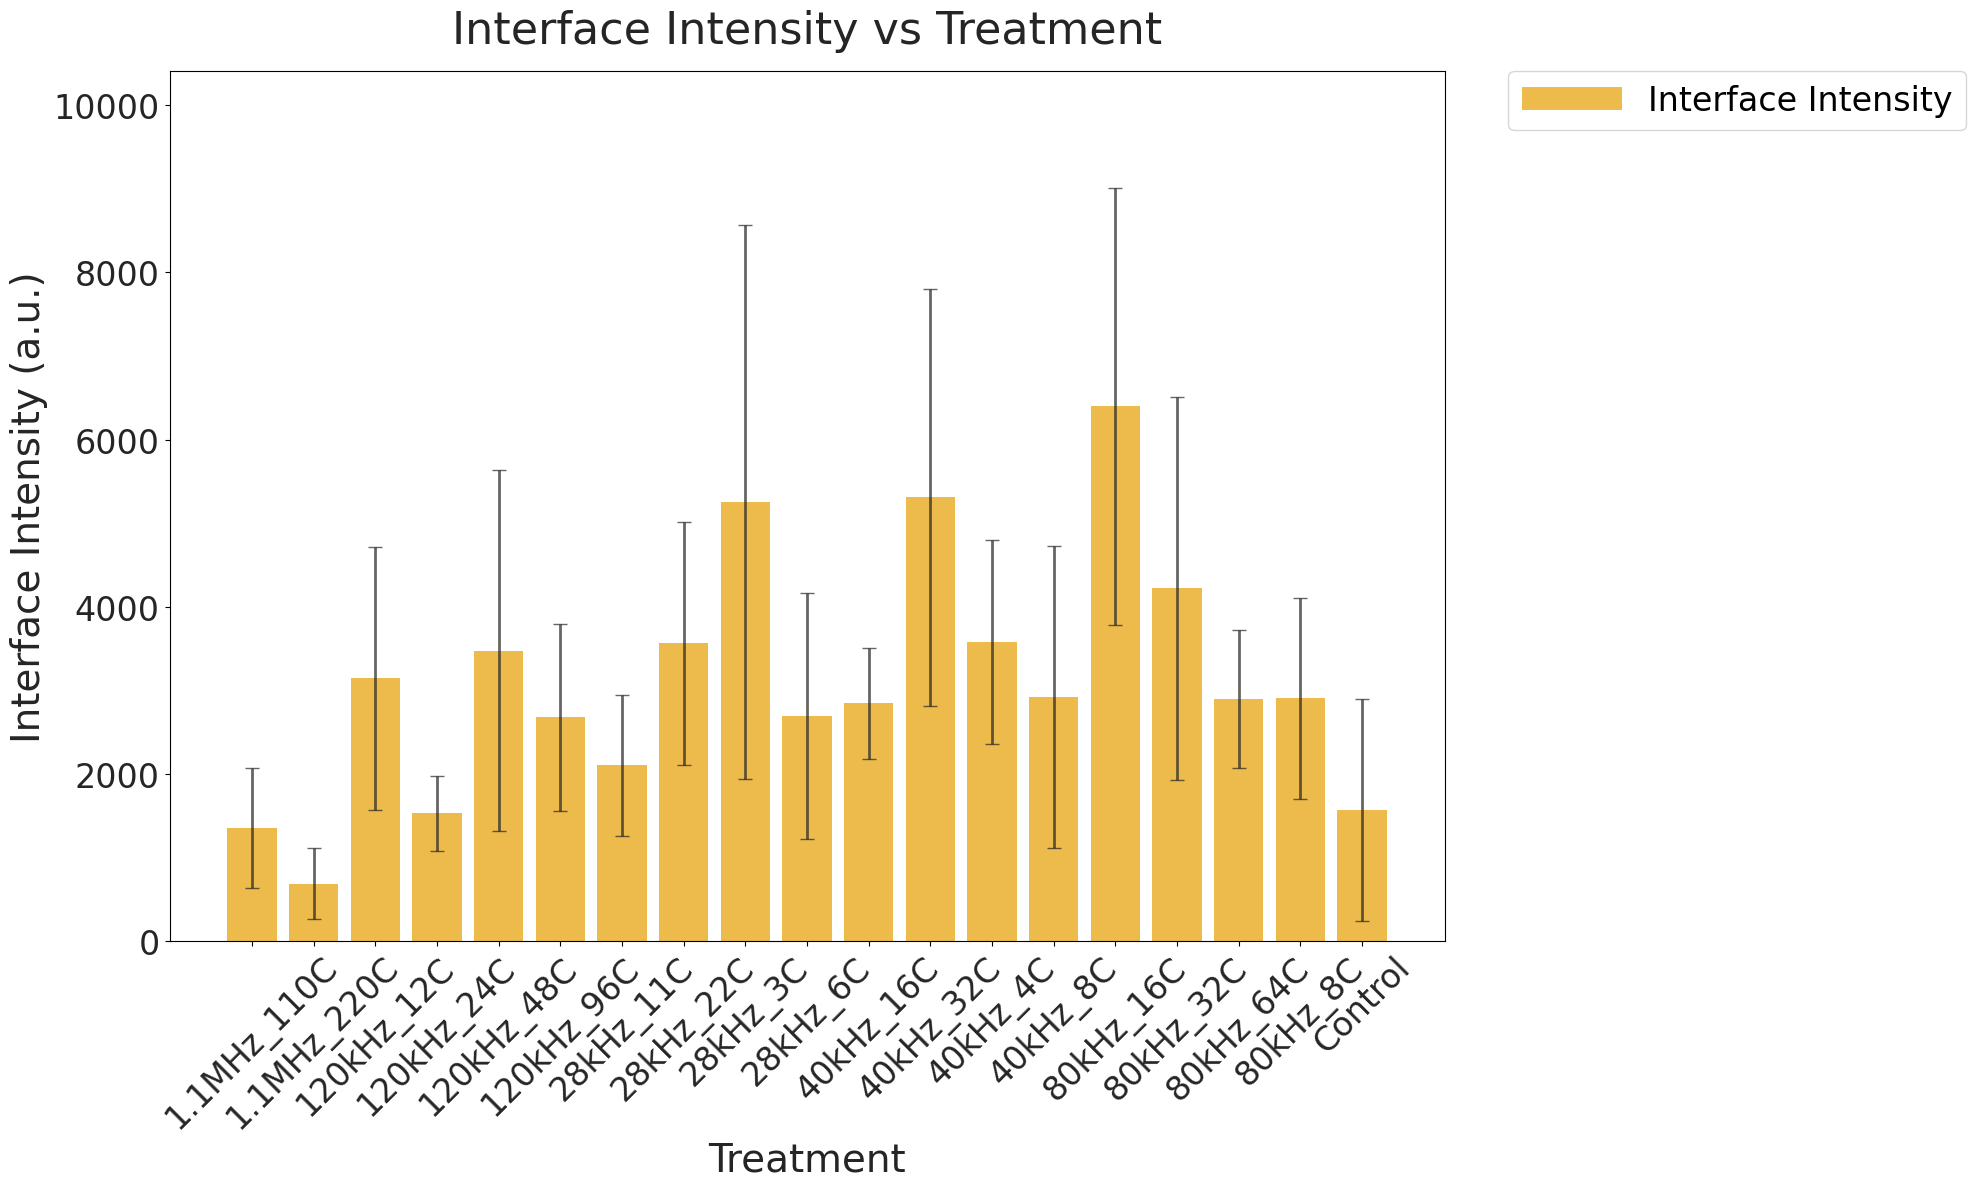


Generating interface distance plots...


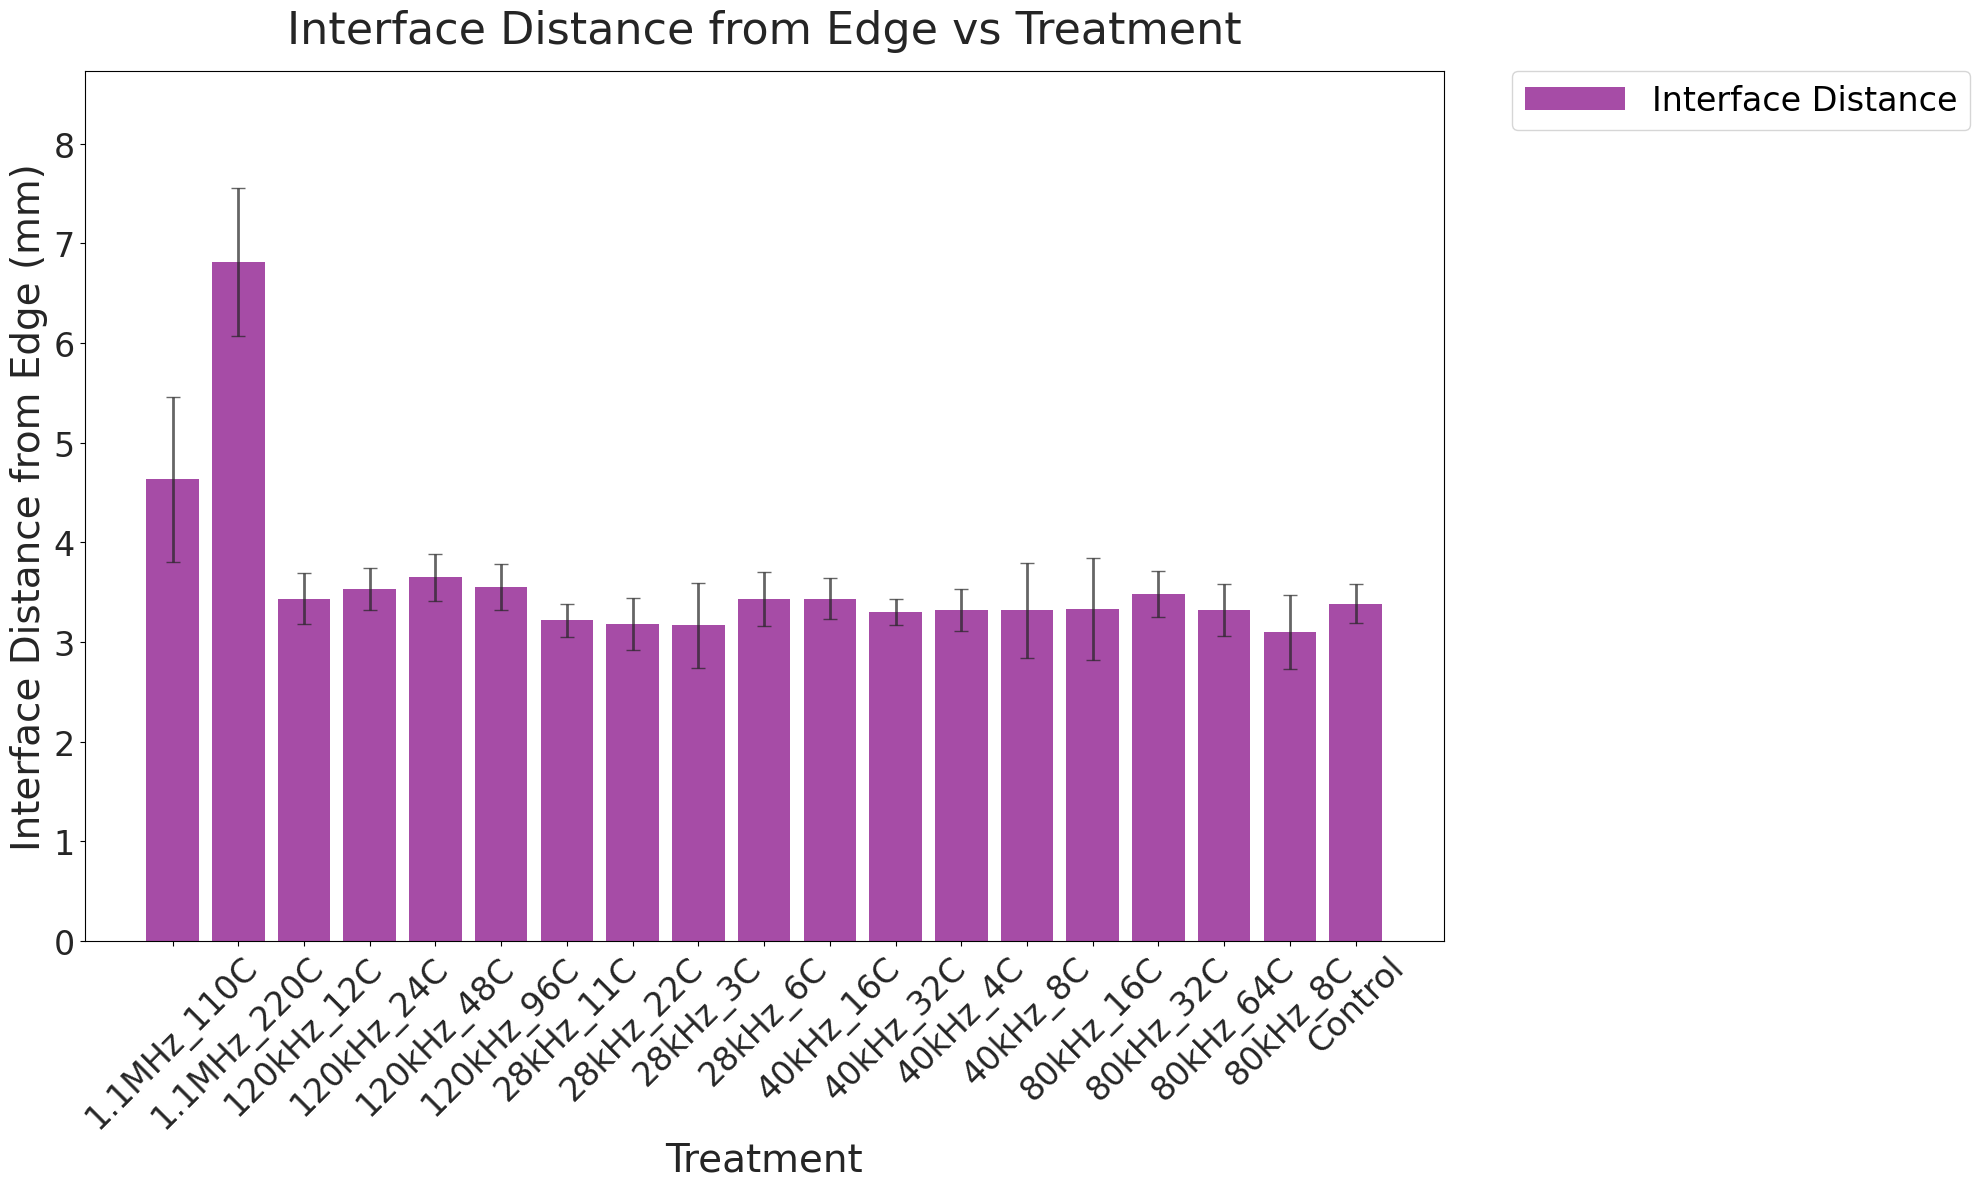


Generating penetration depth comparison plots...


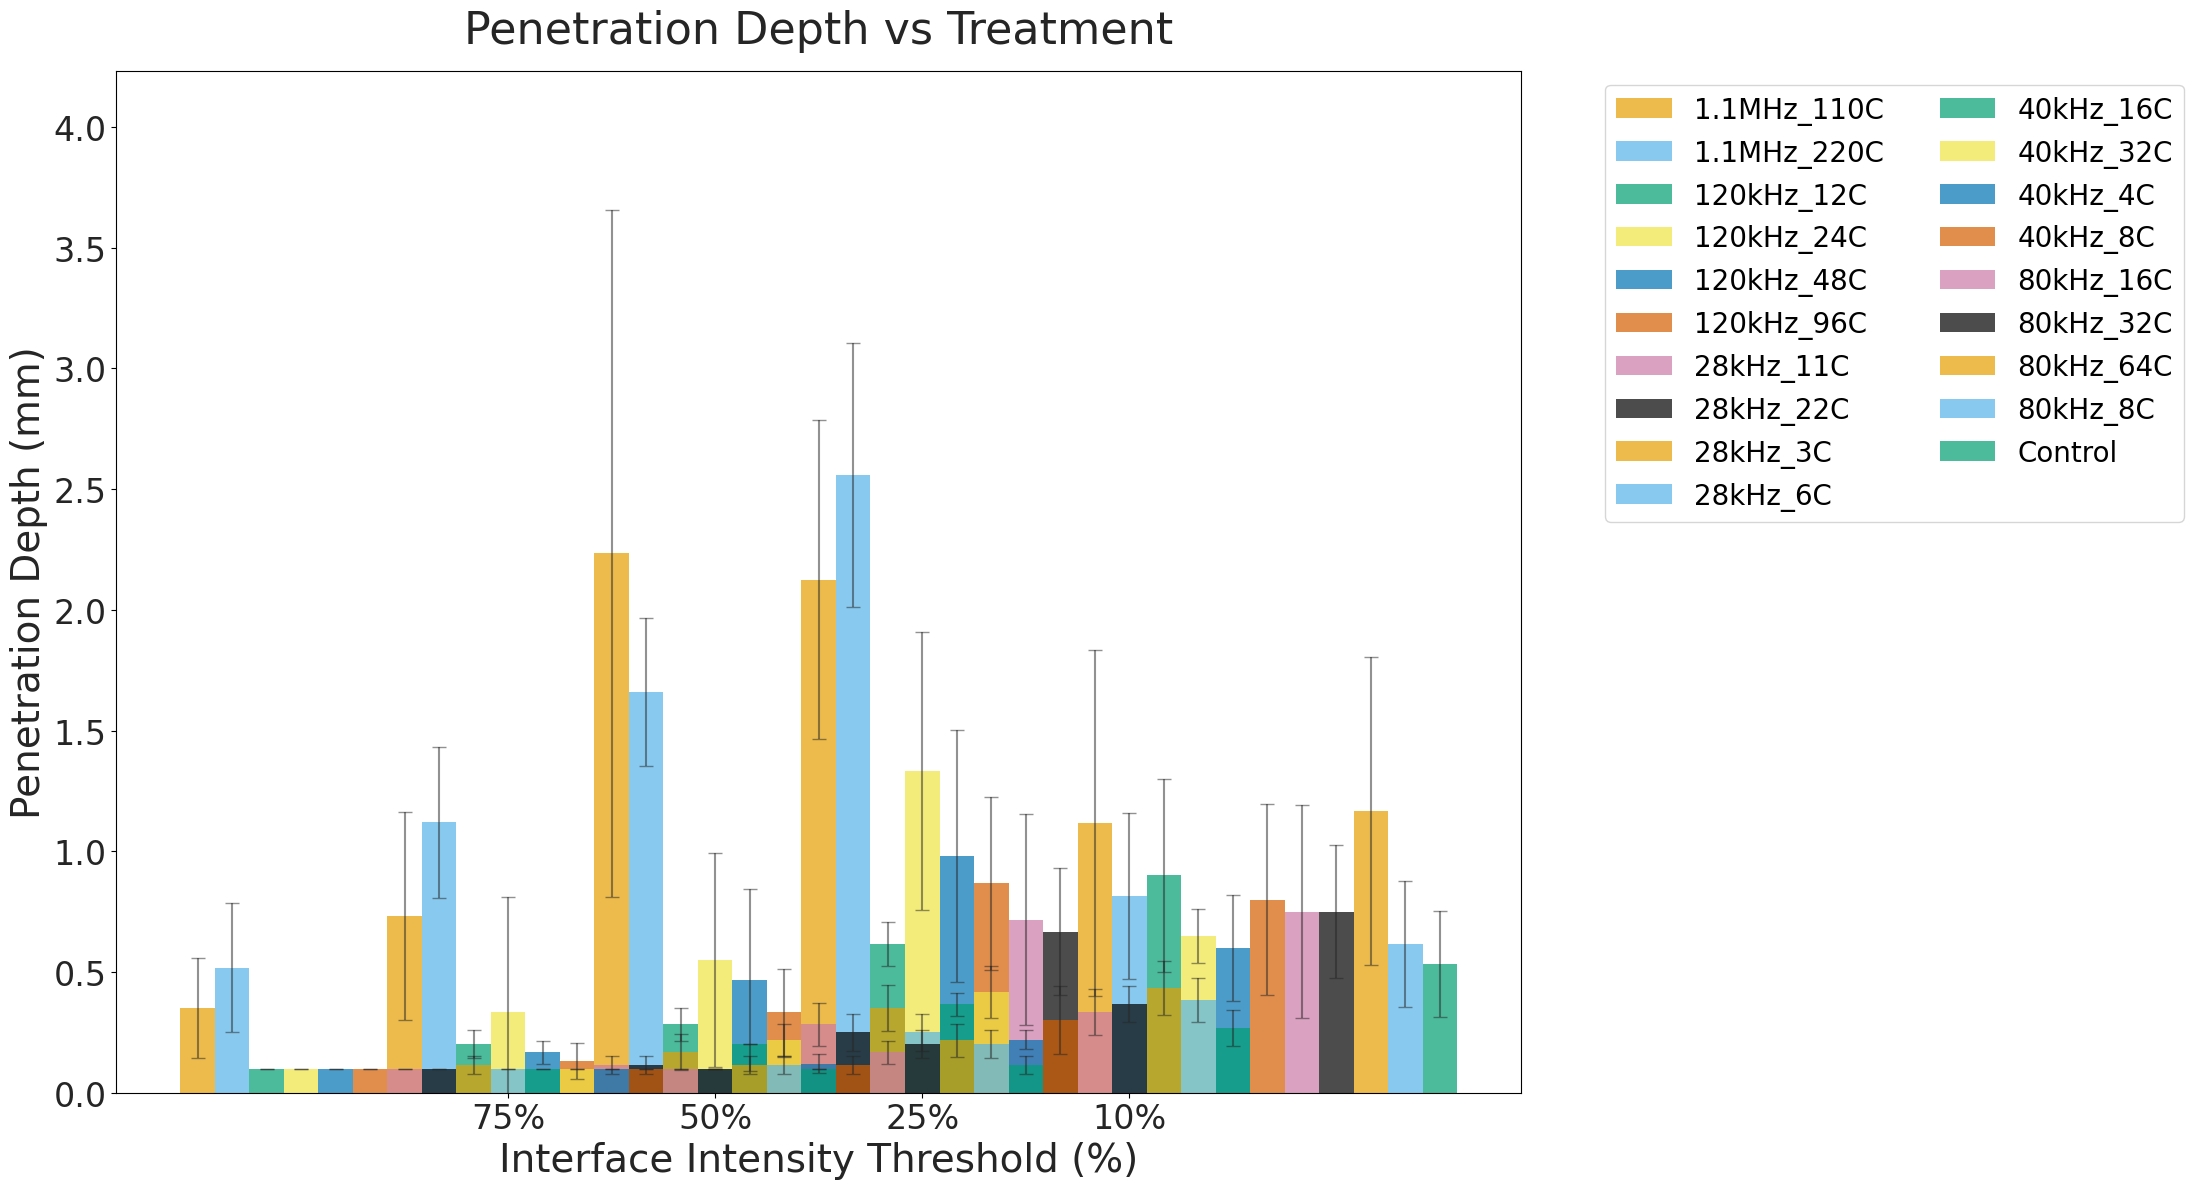


Generating intensity bar plots...


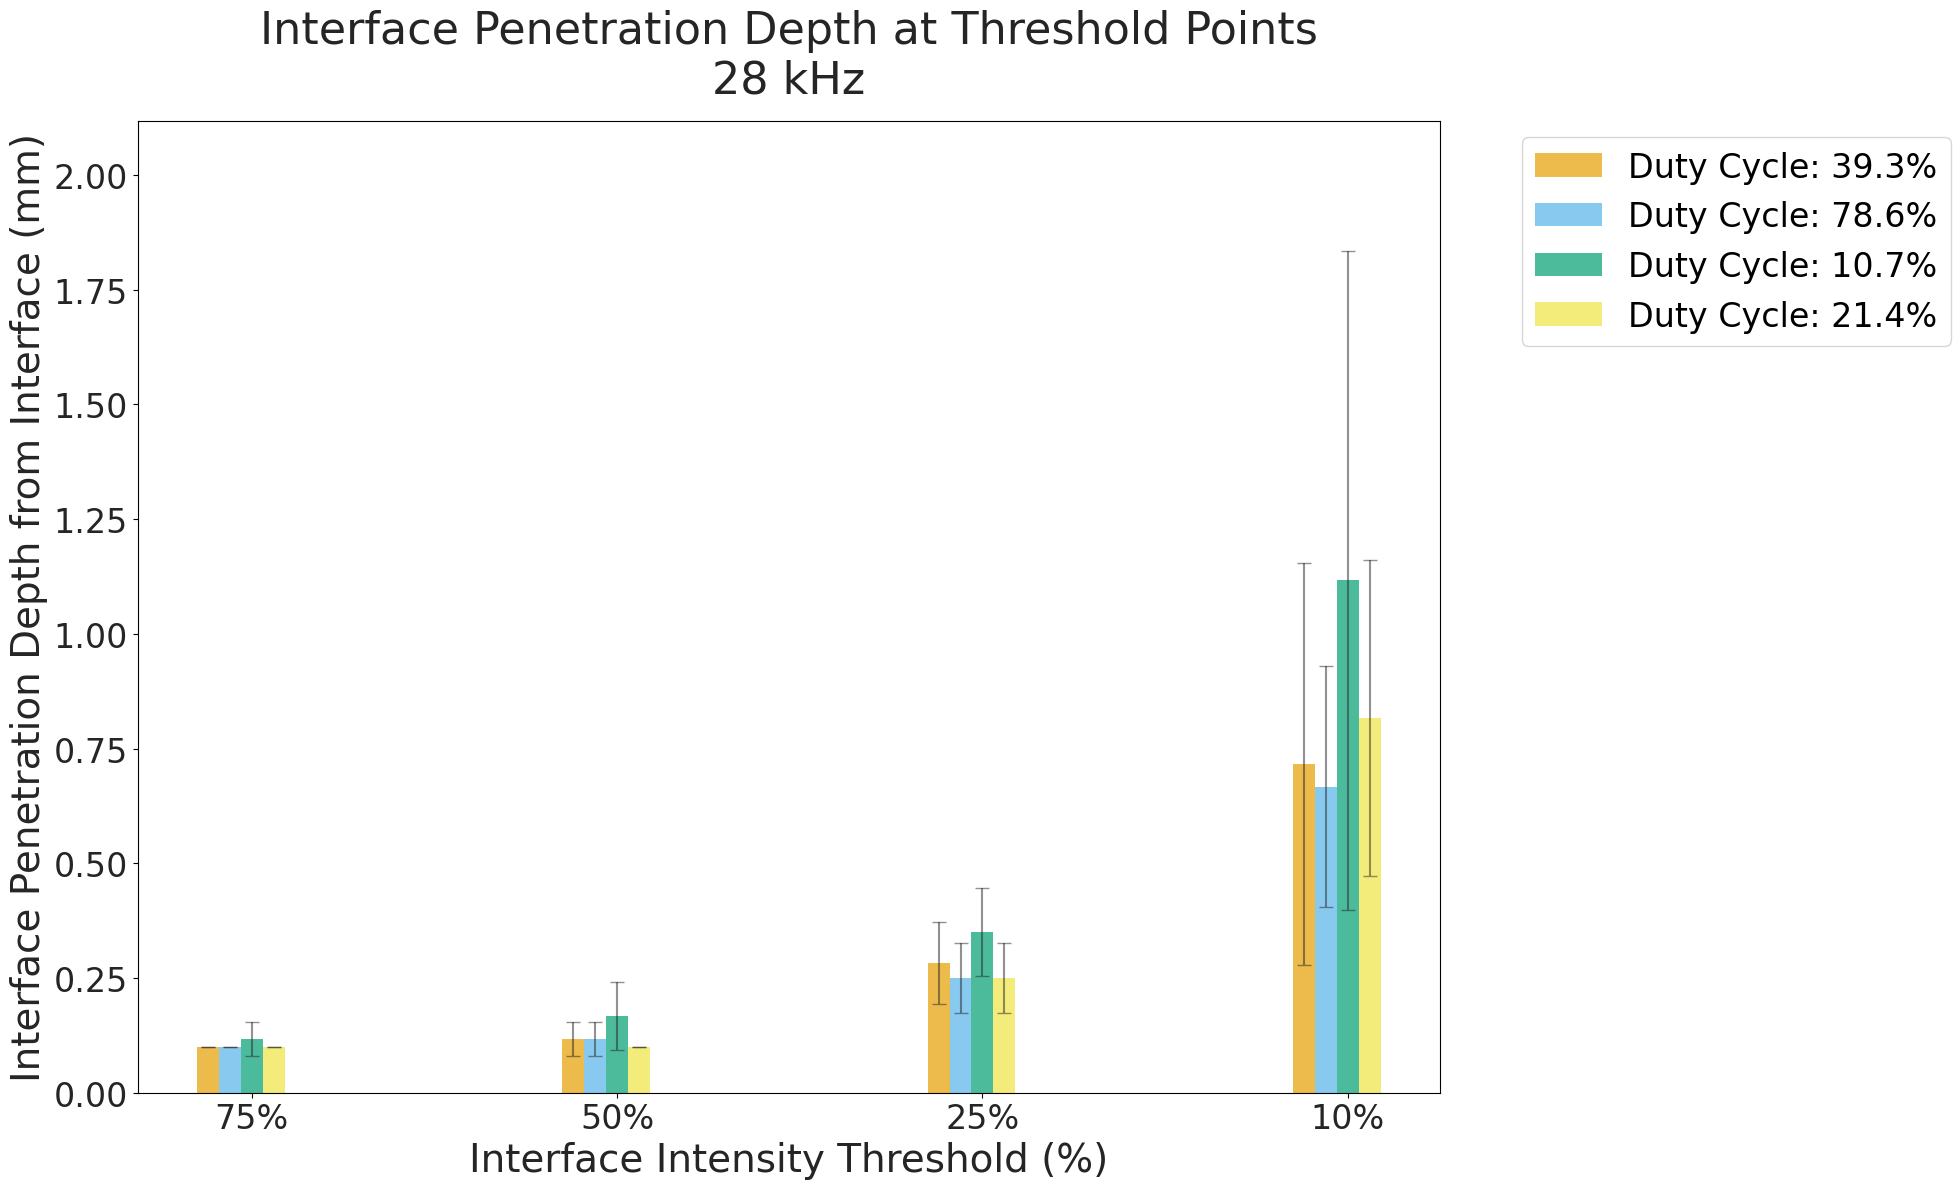

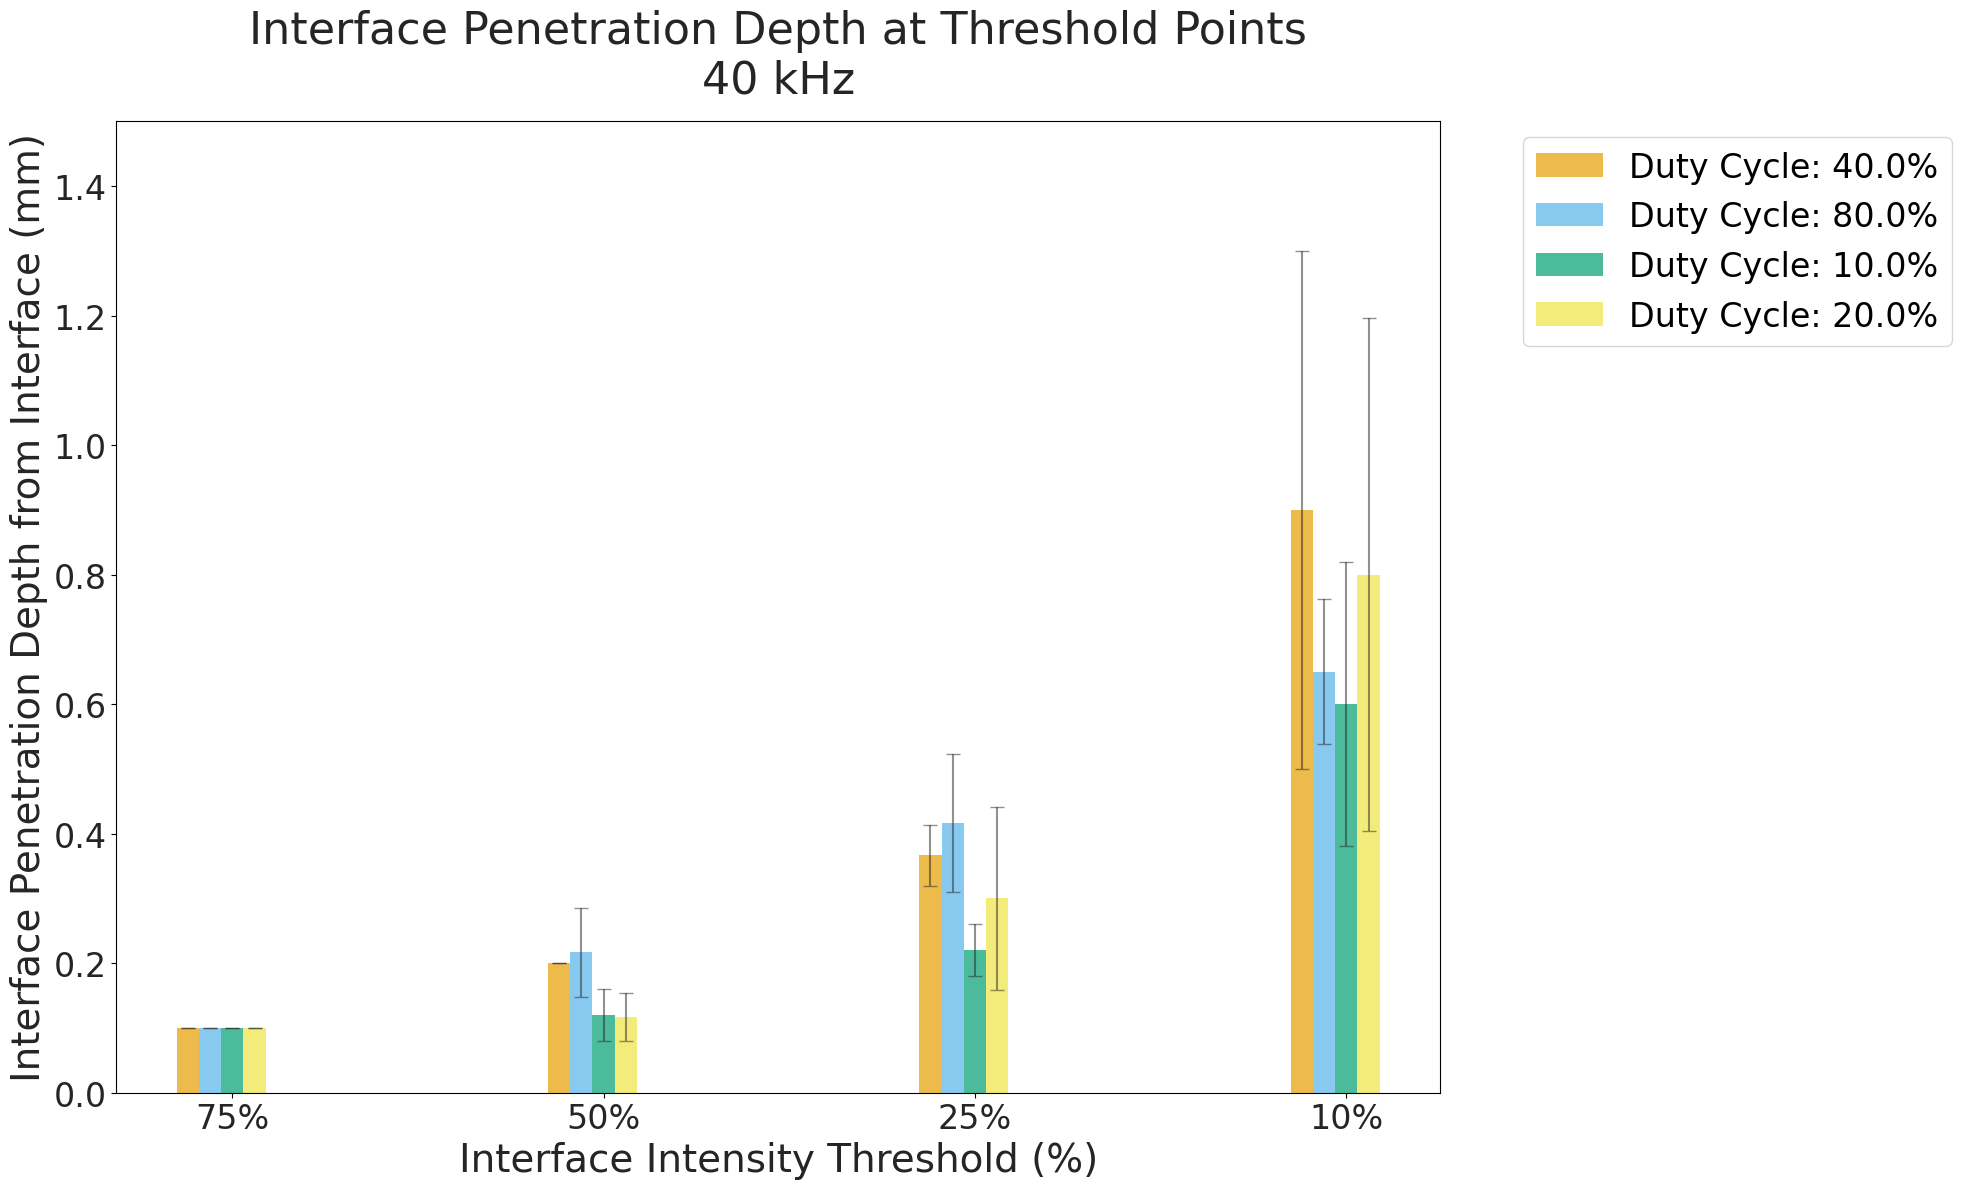

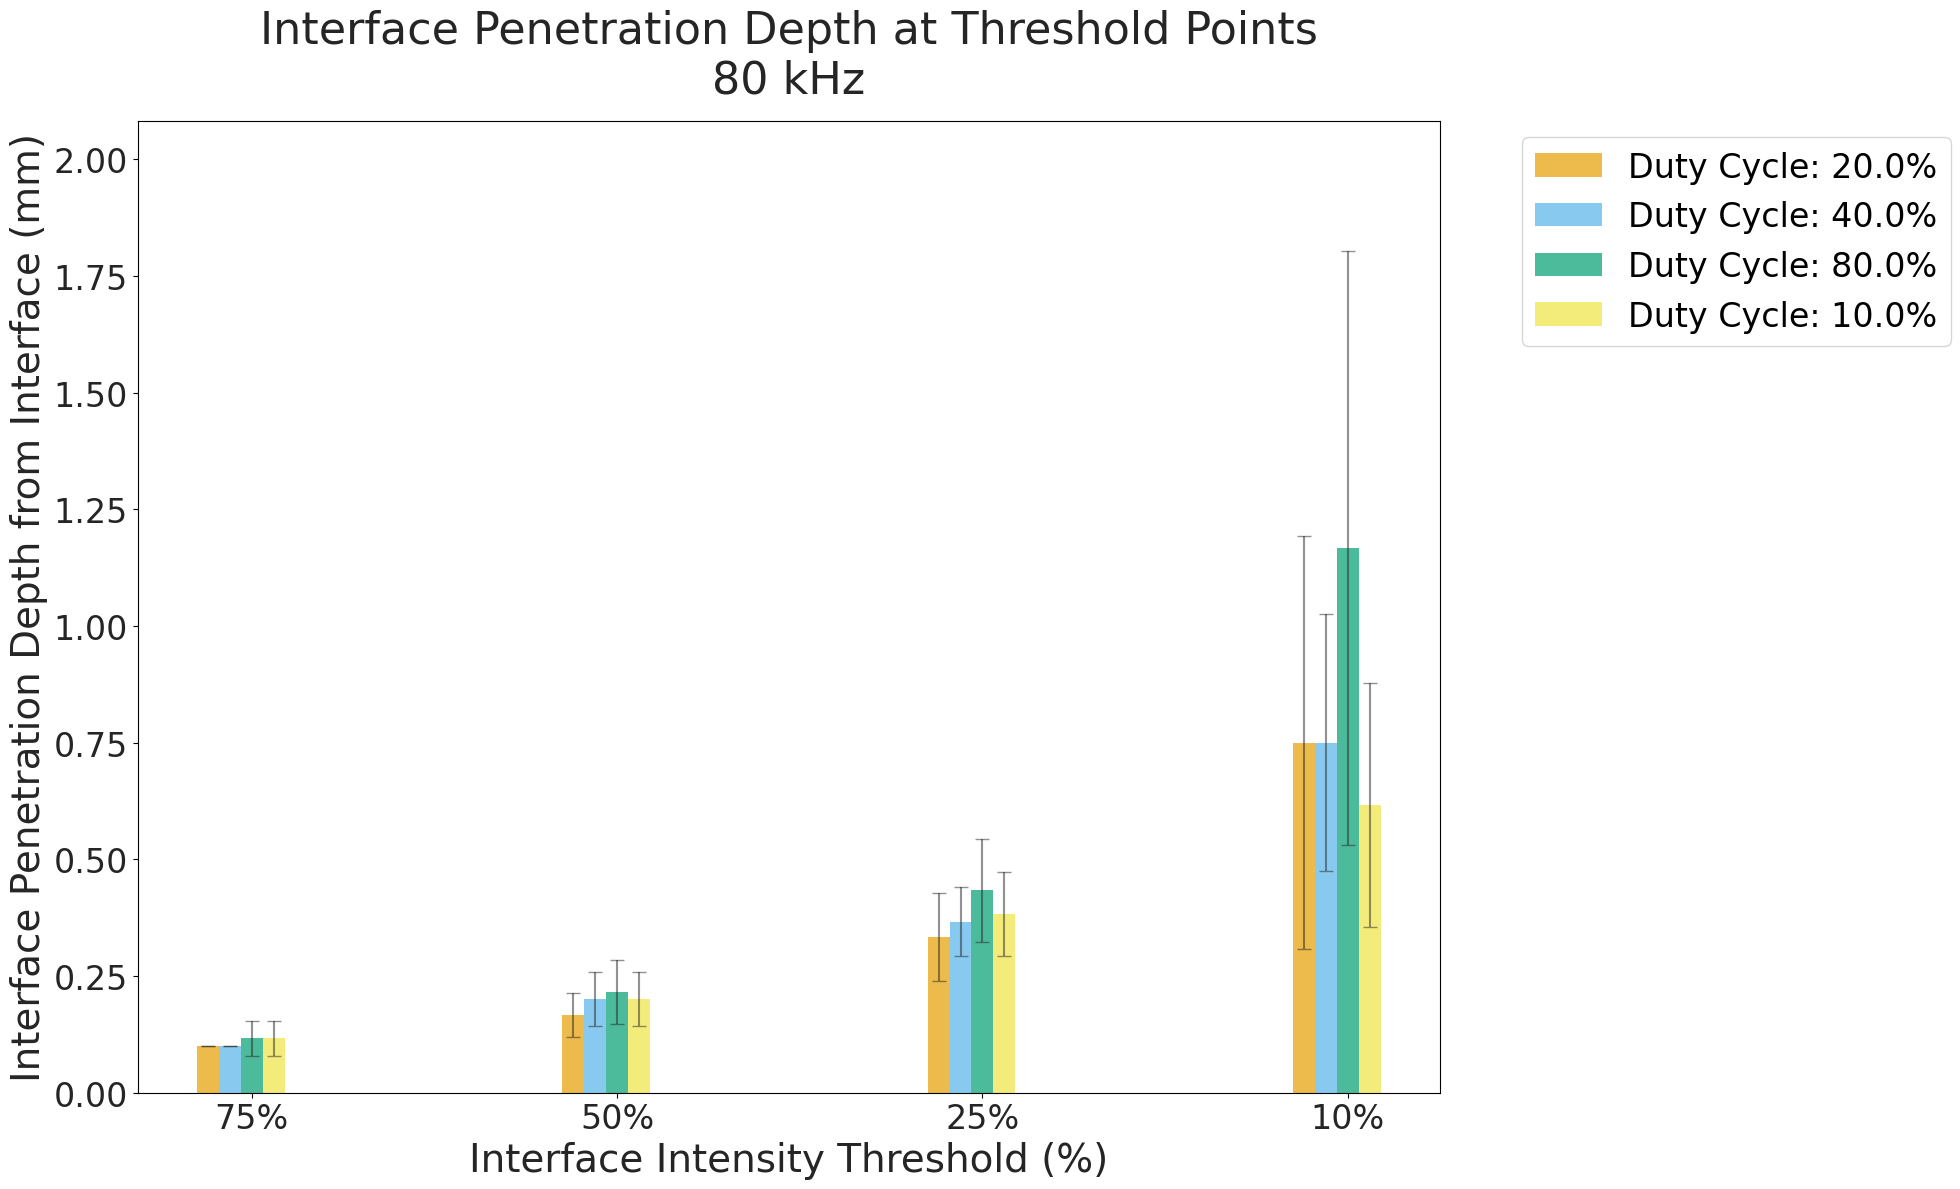

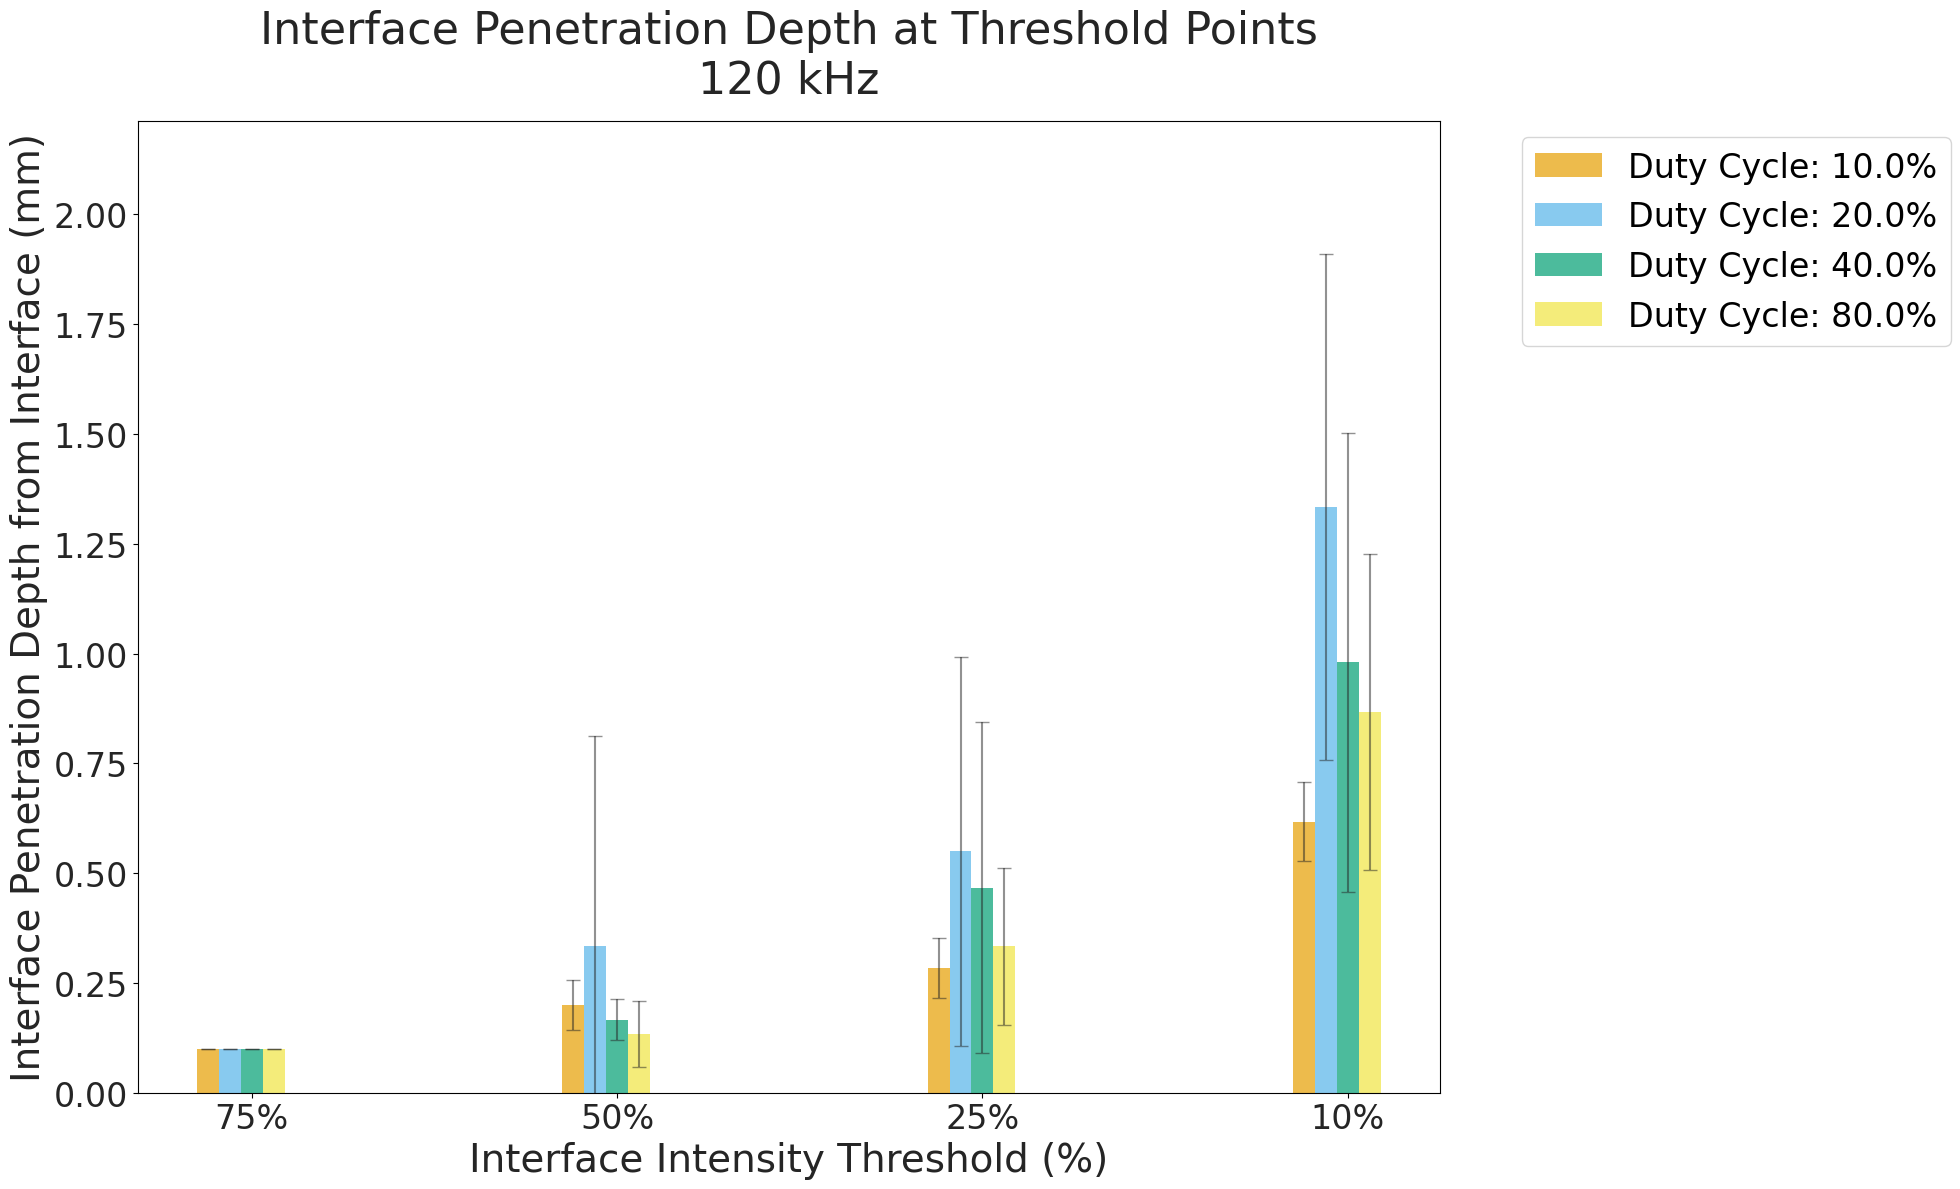

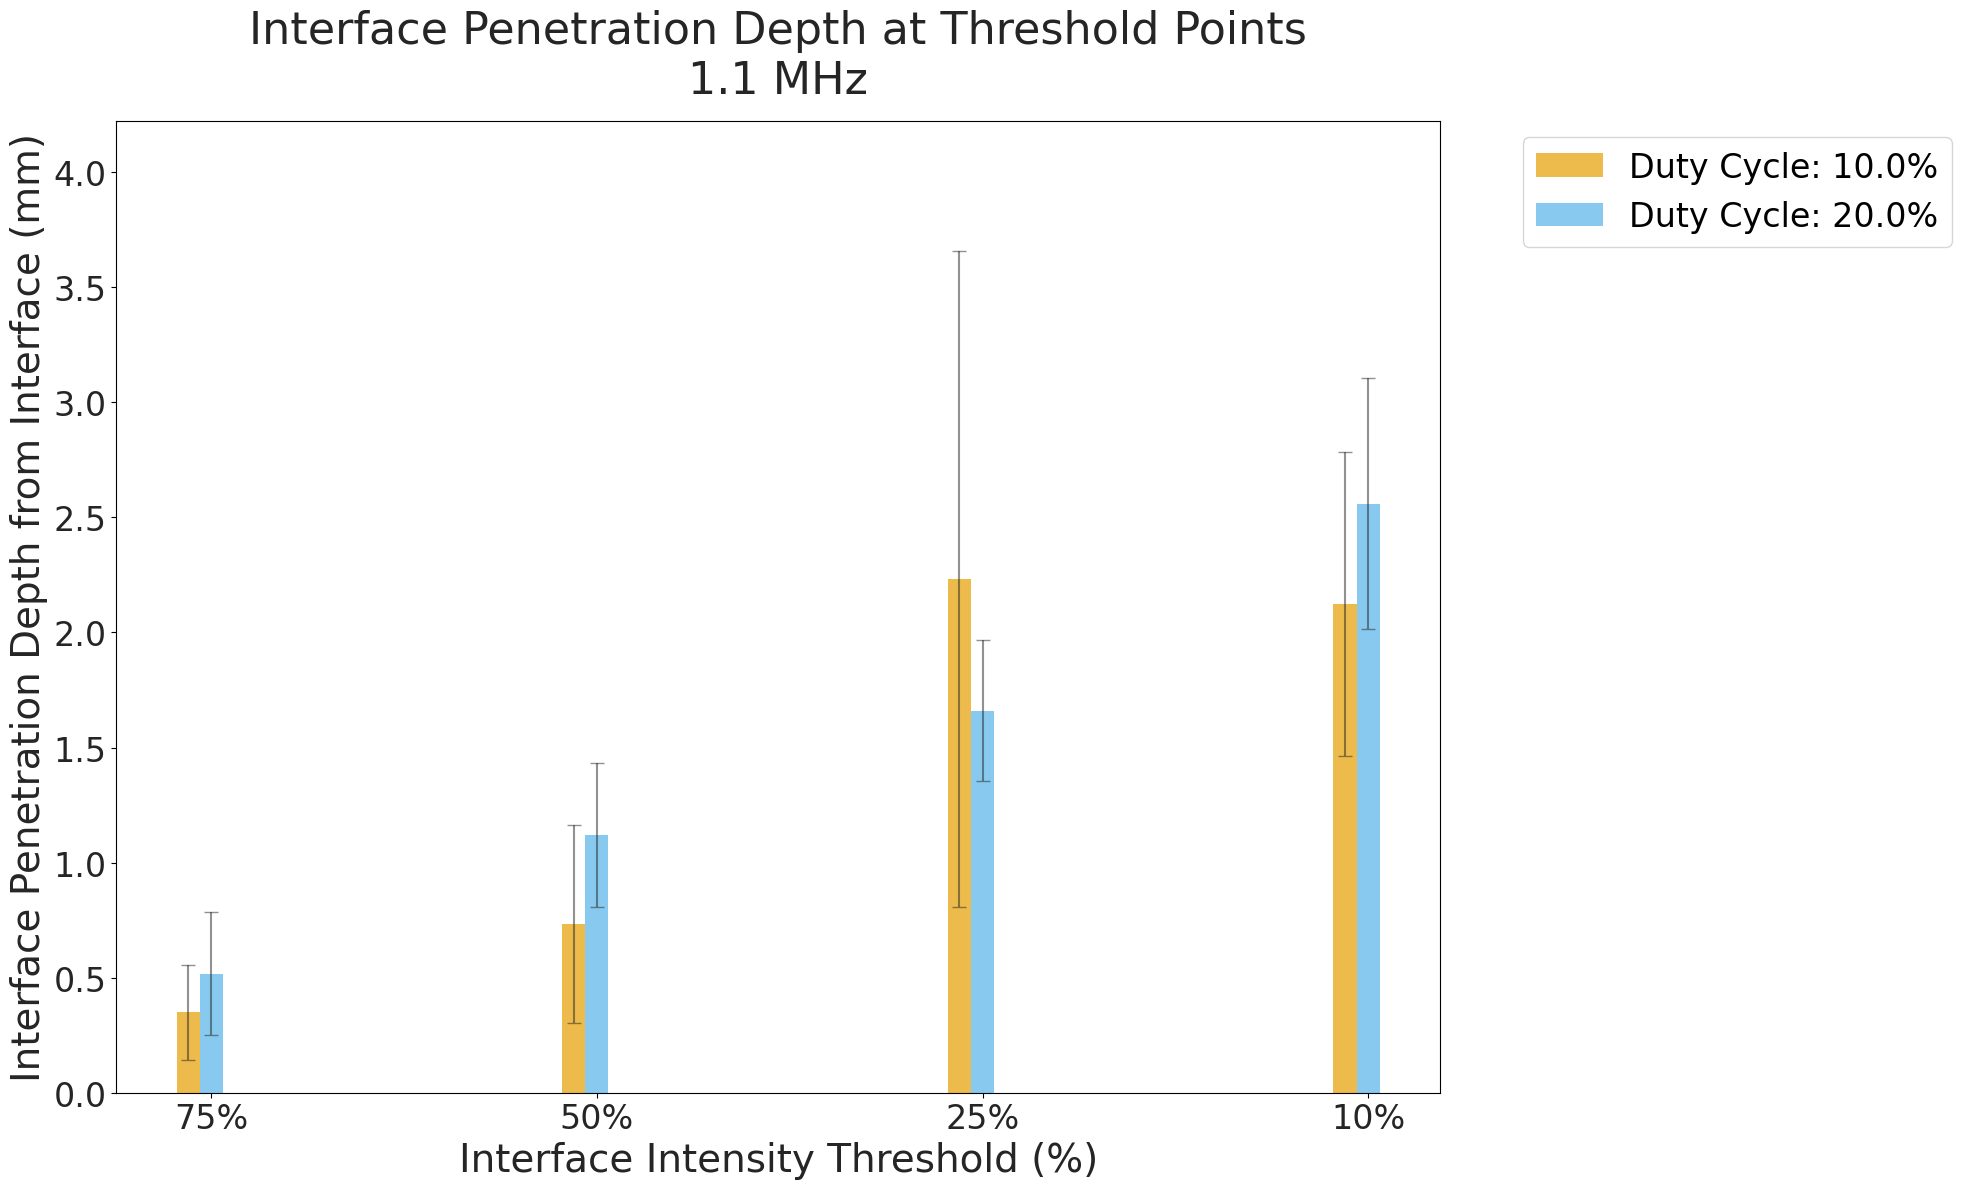


Generating COM shift plots by frequency...


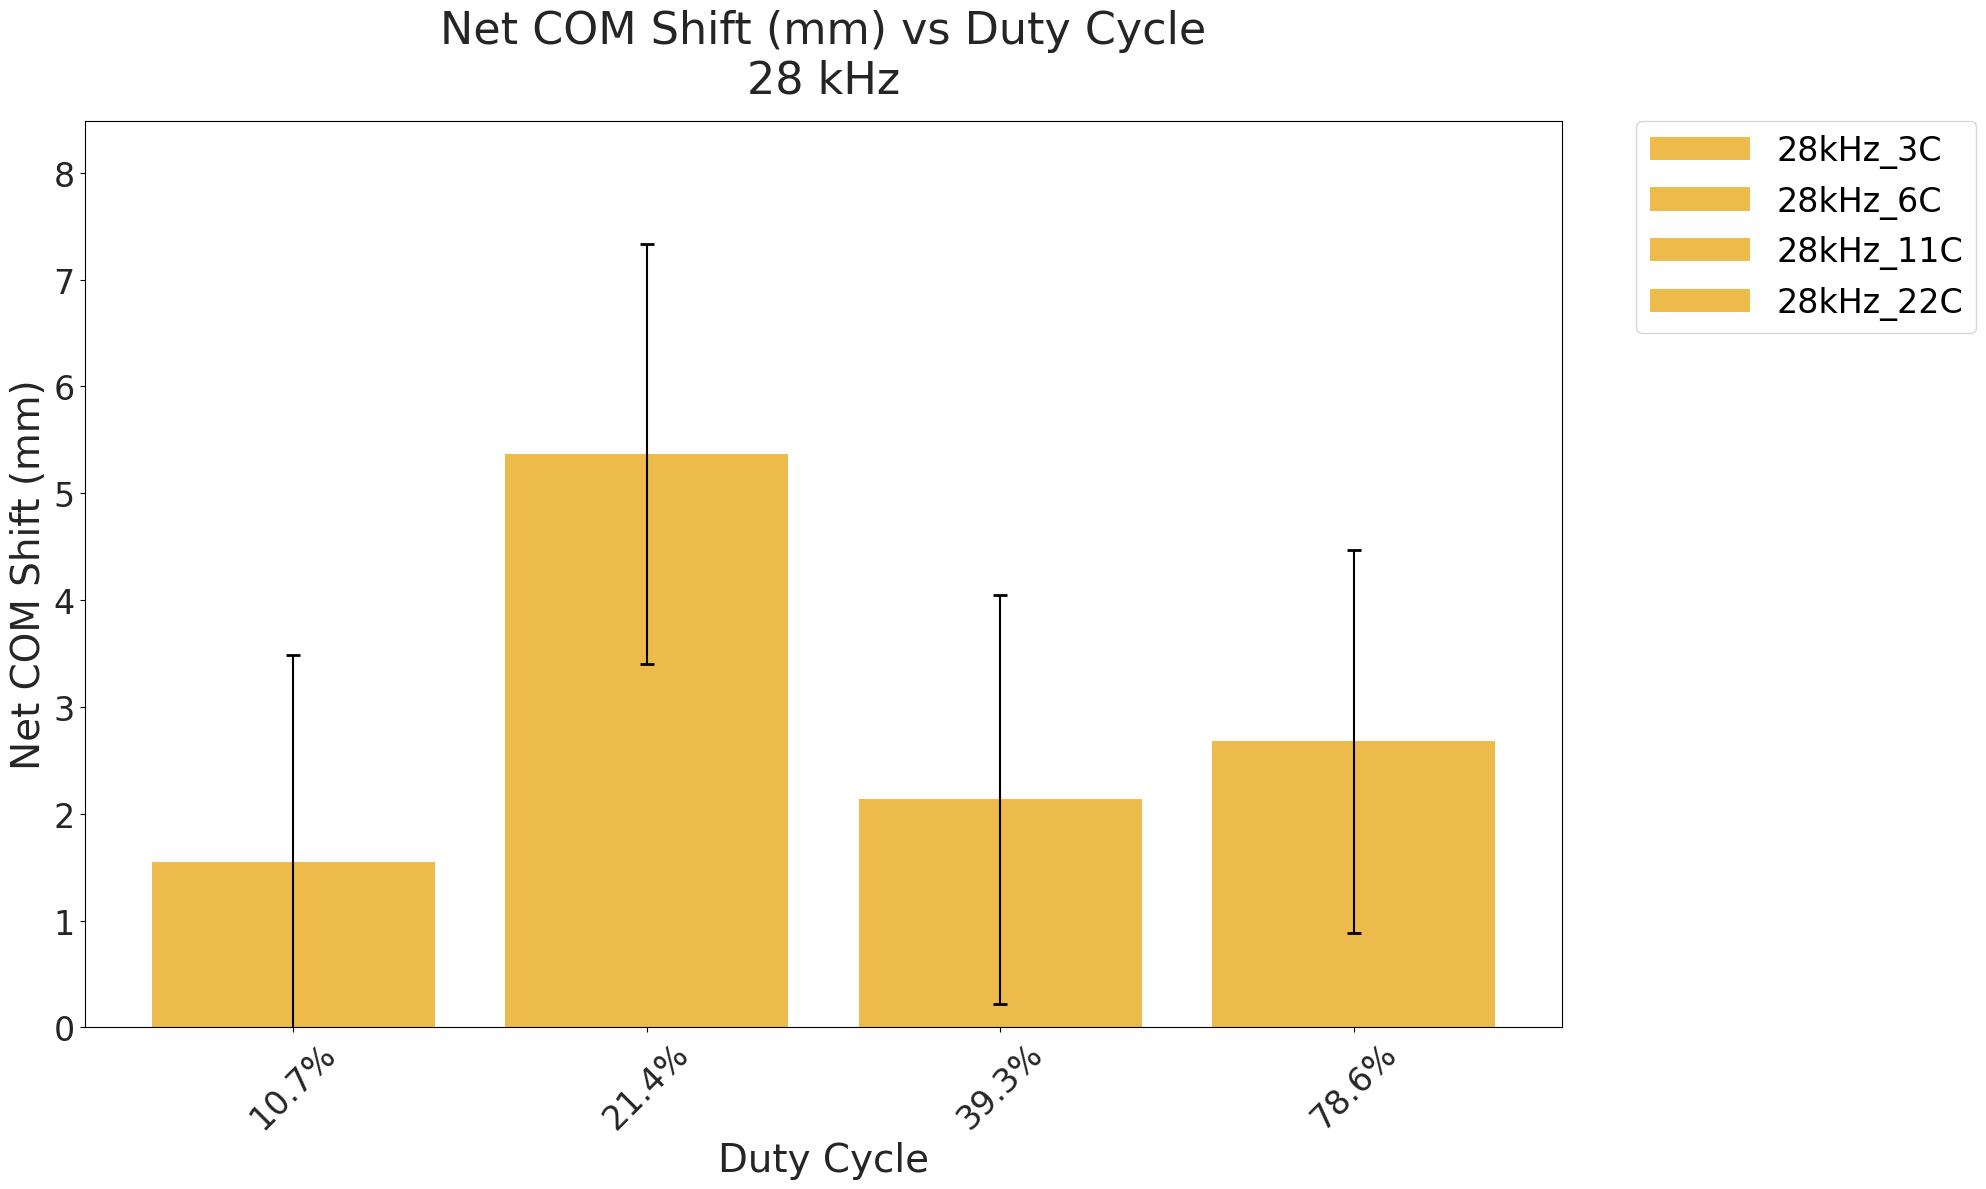

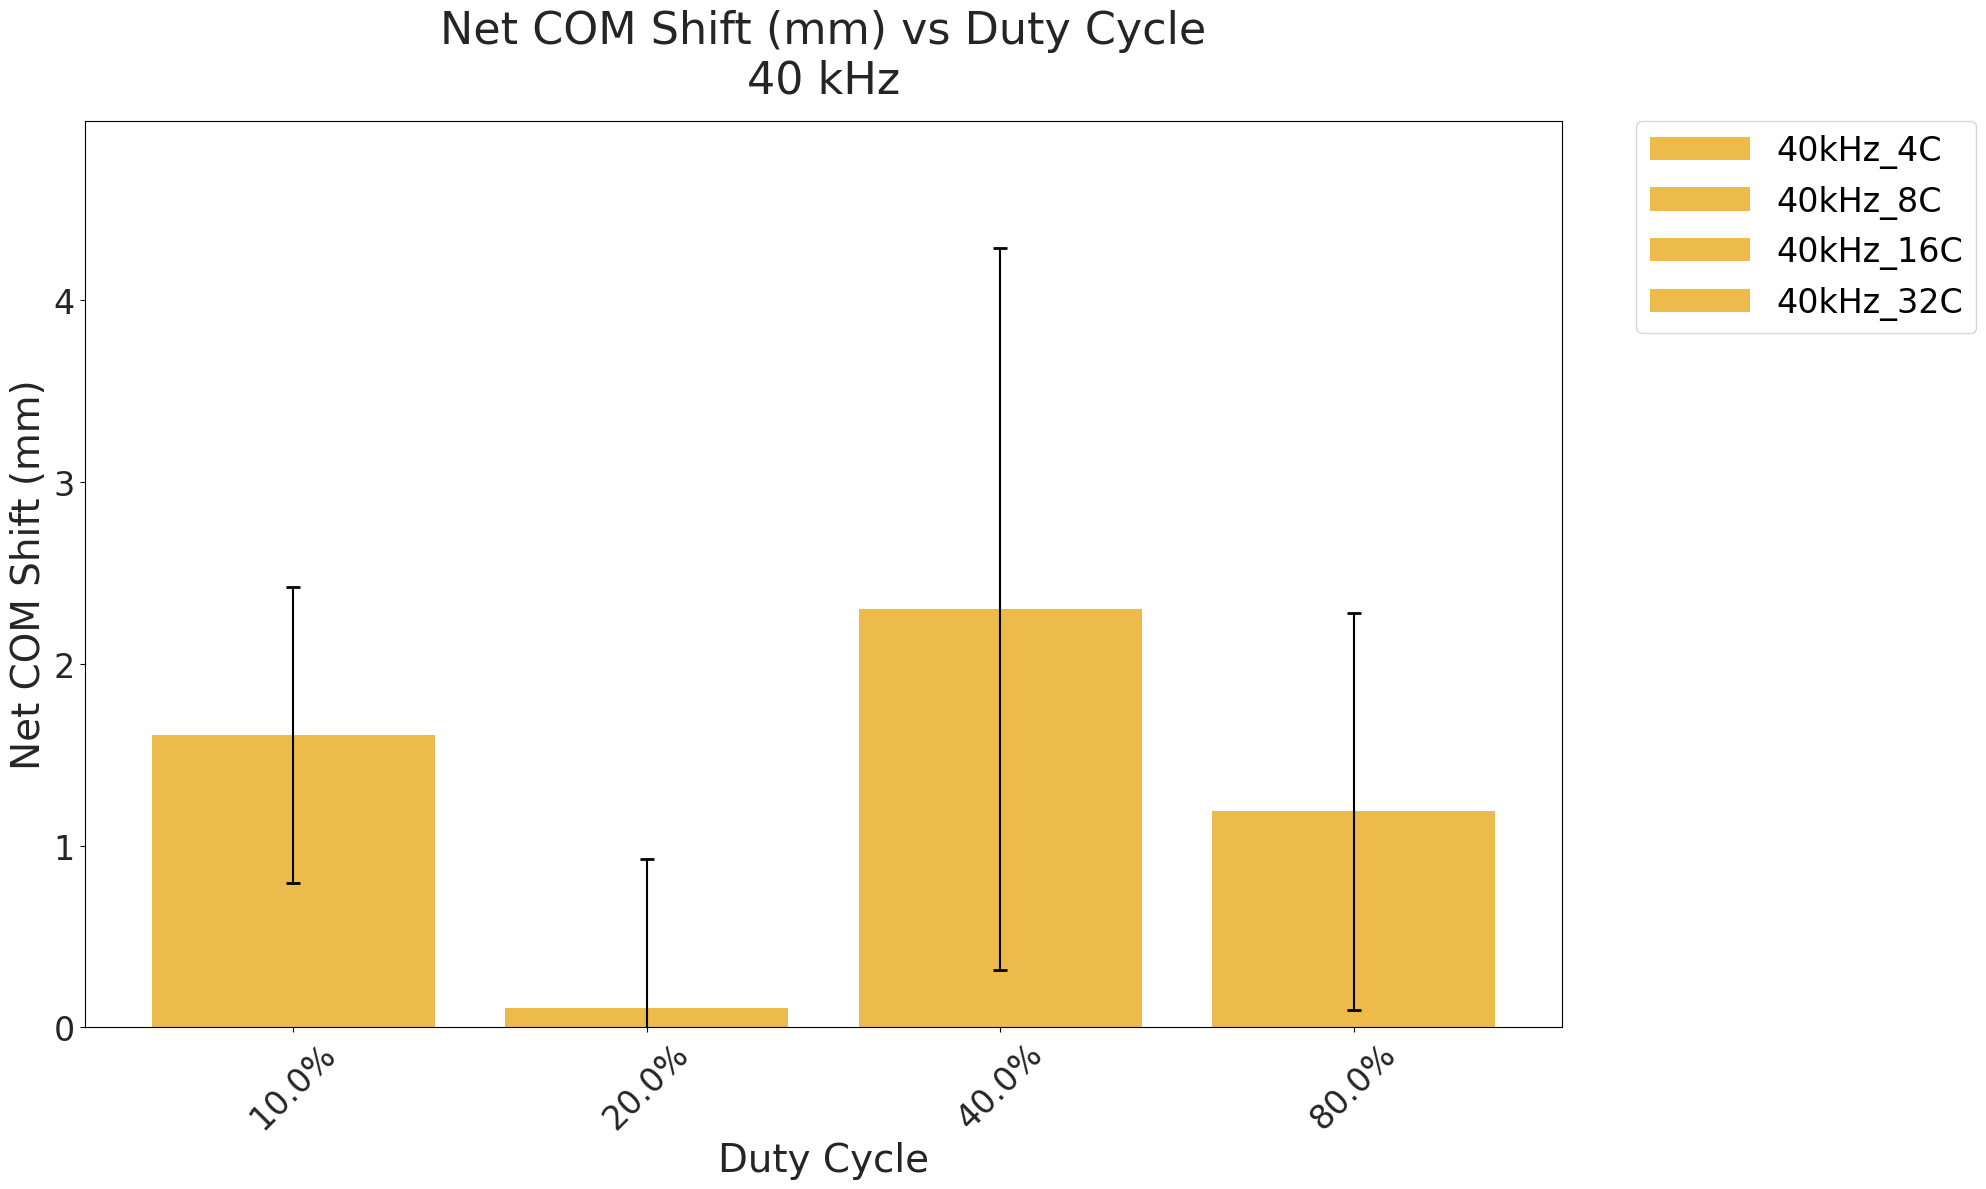

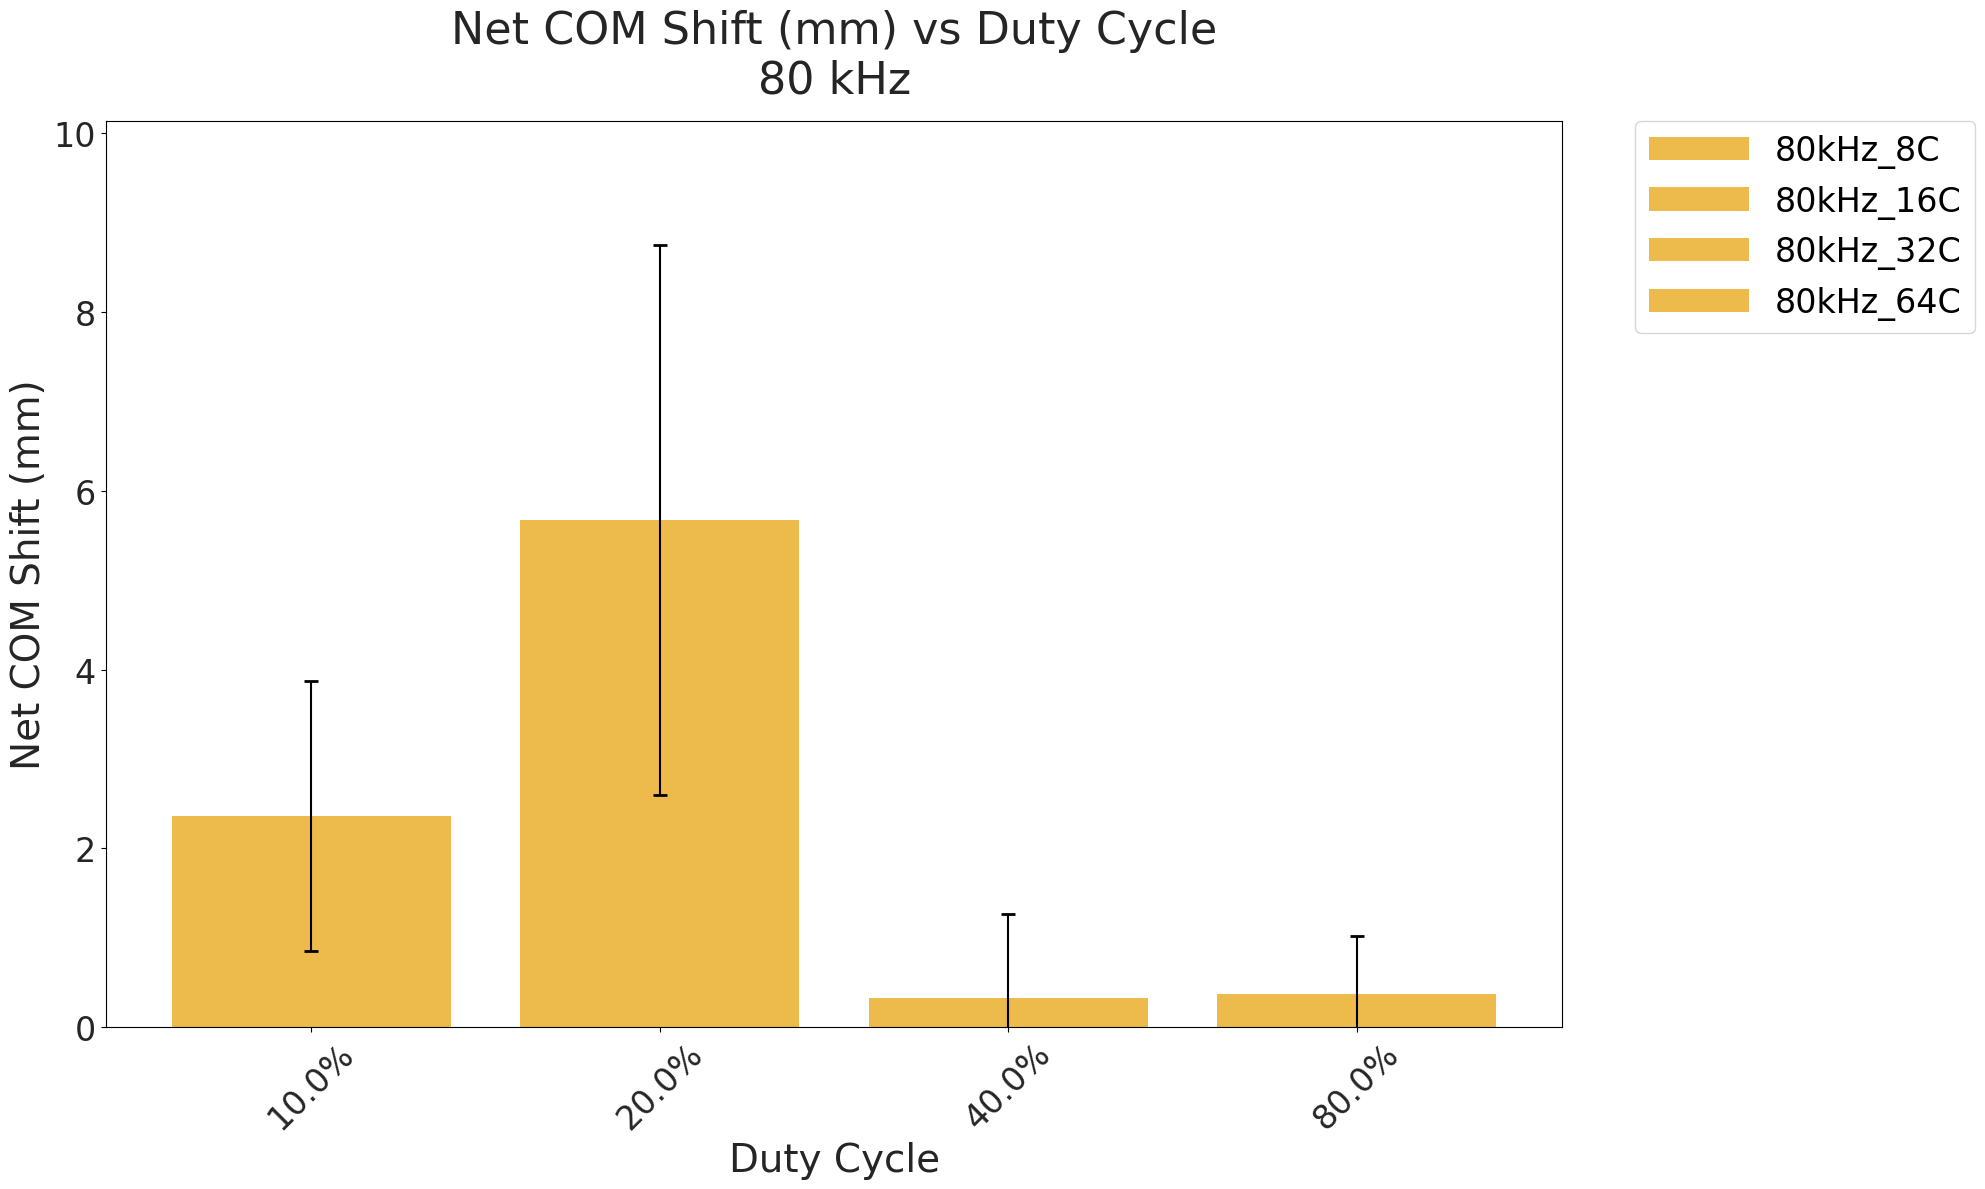

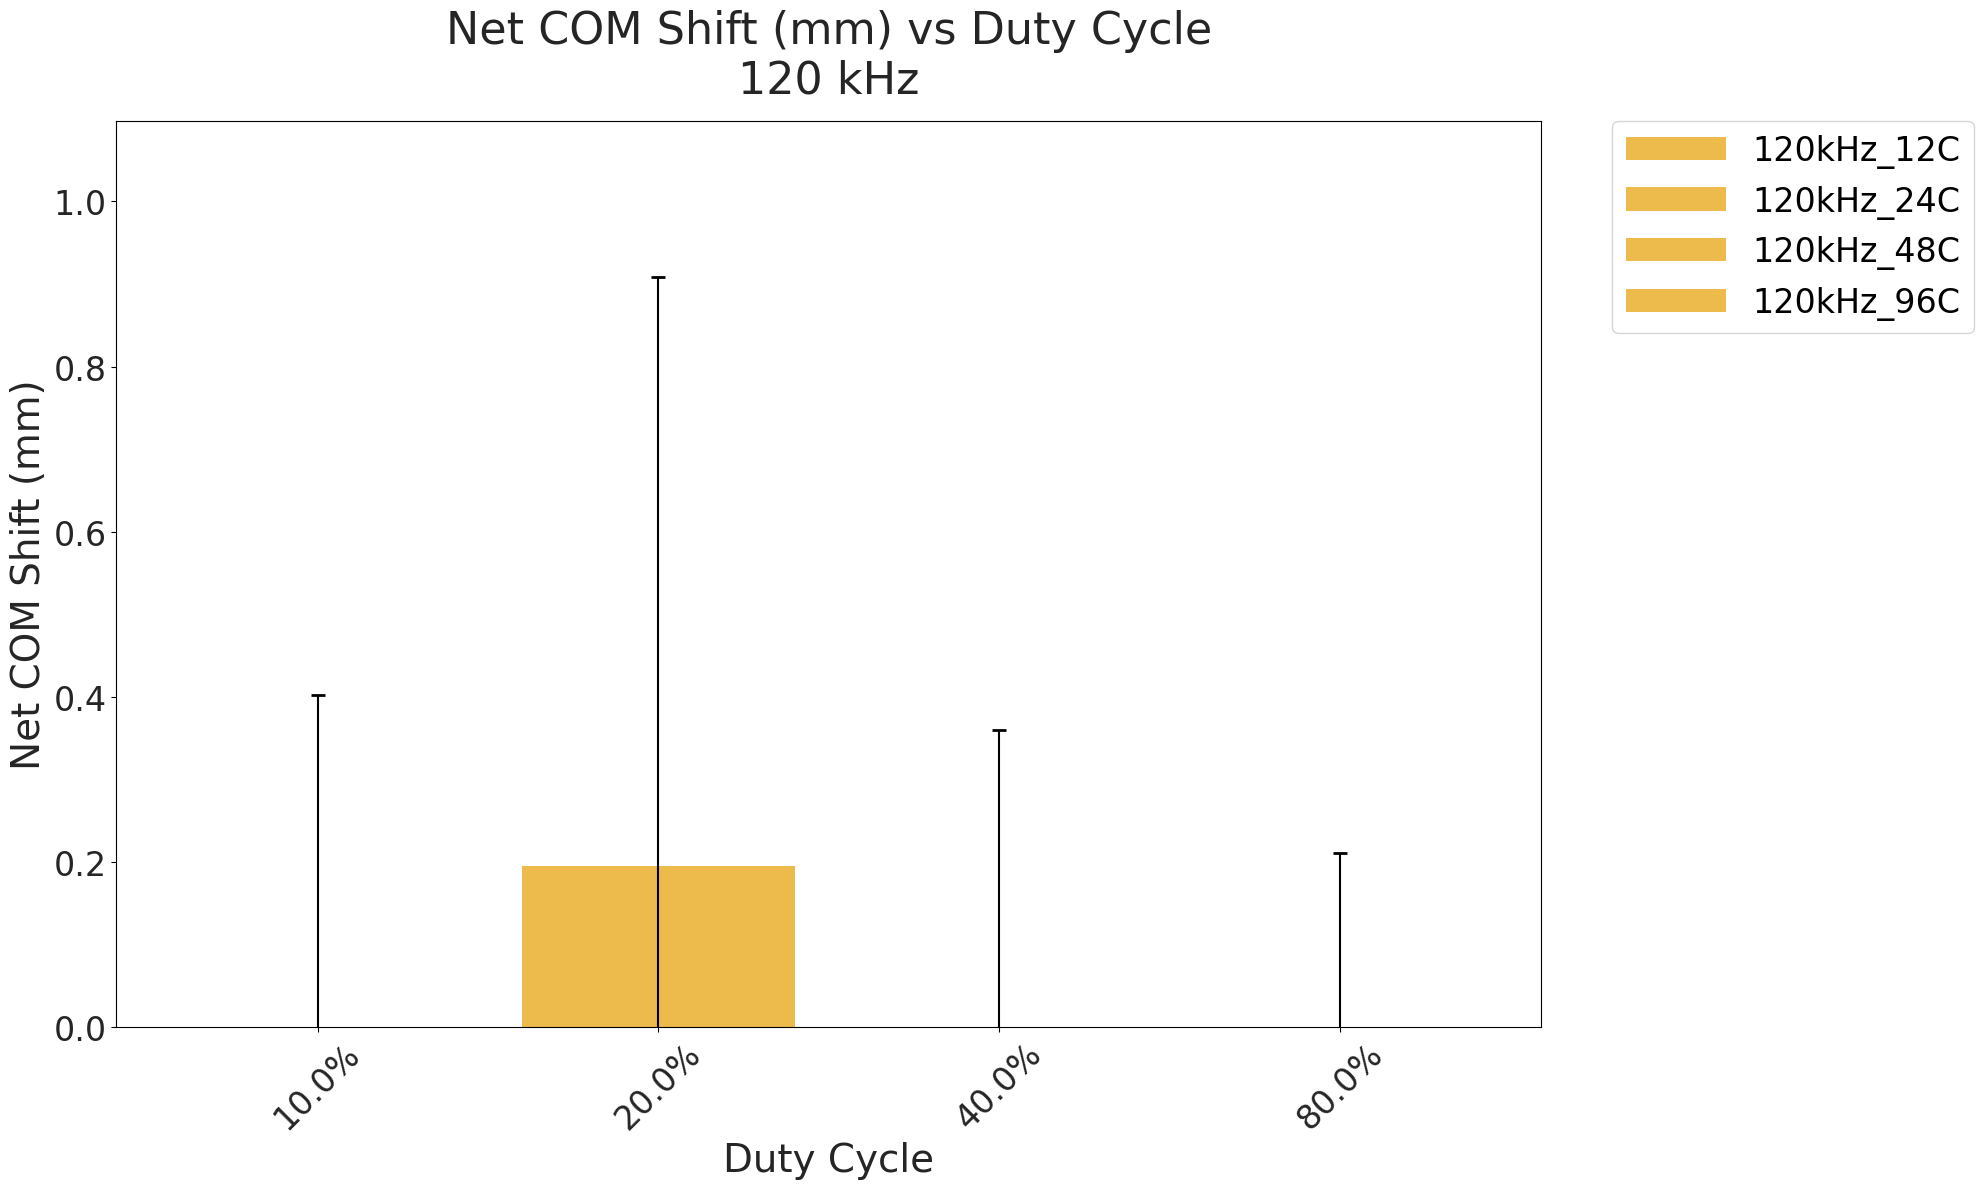

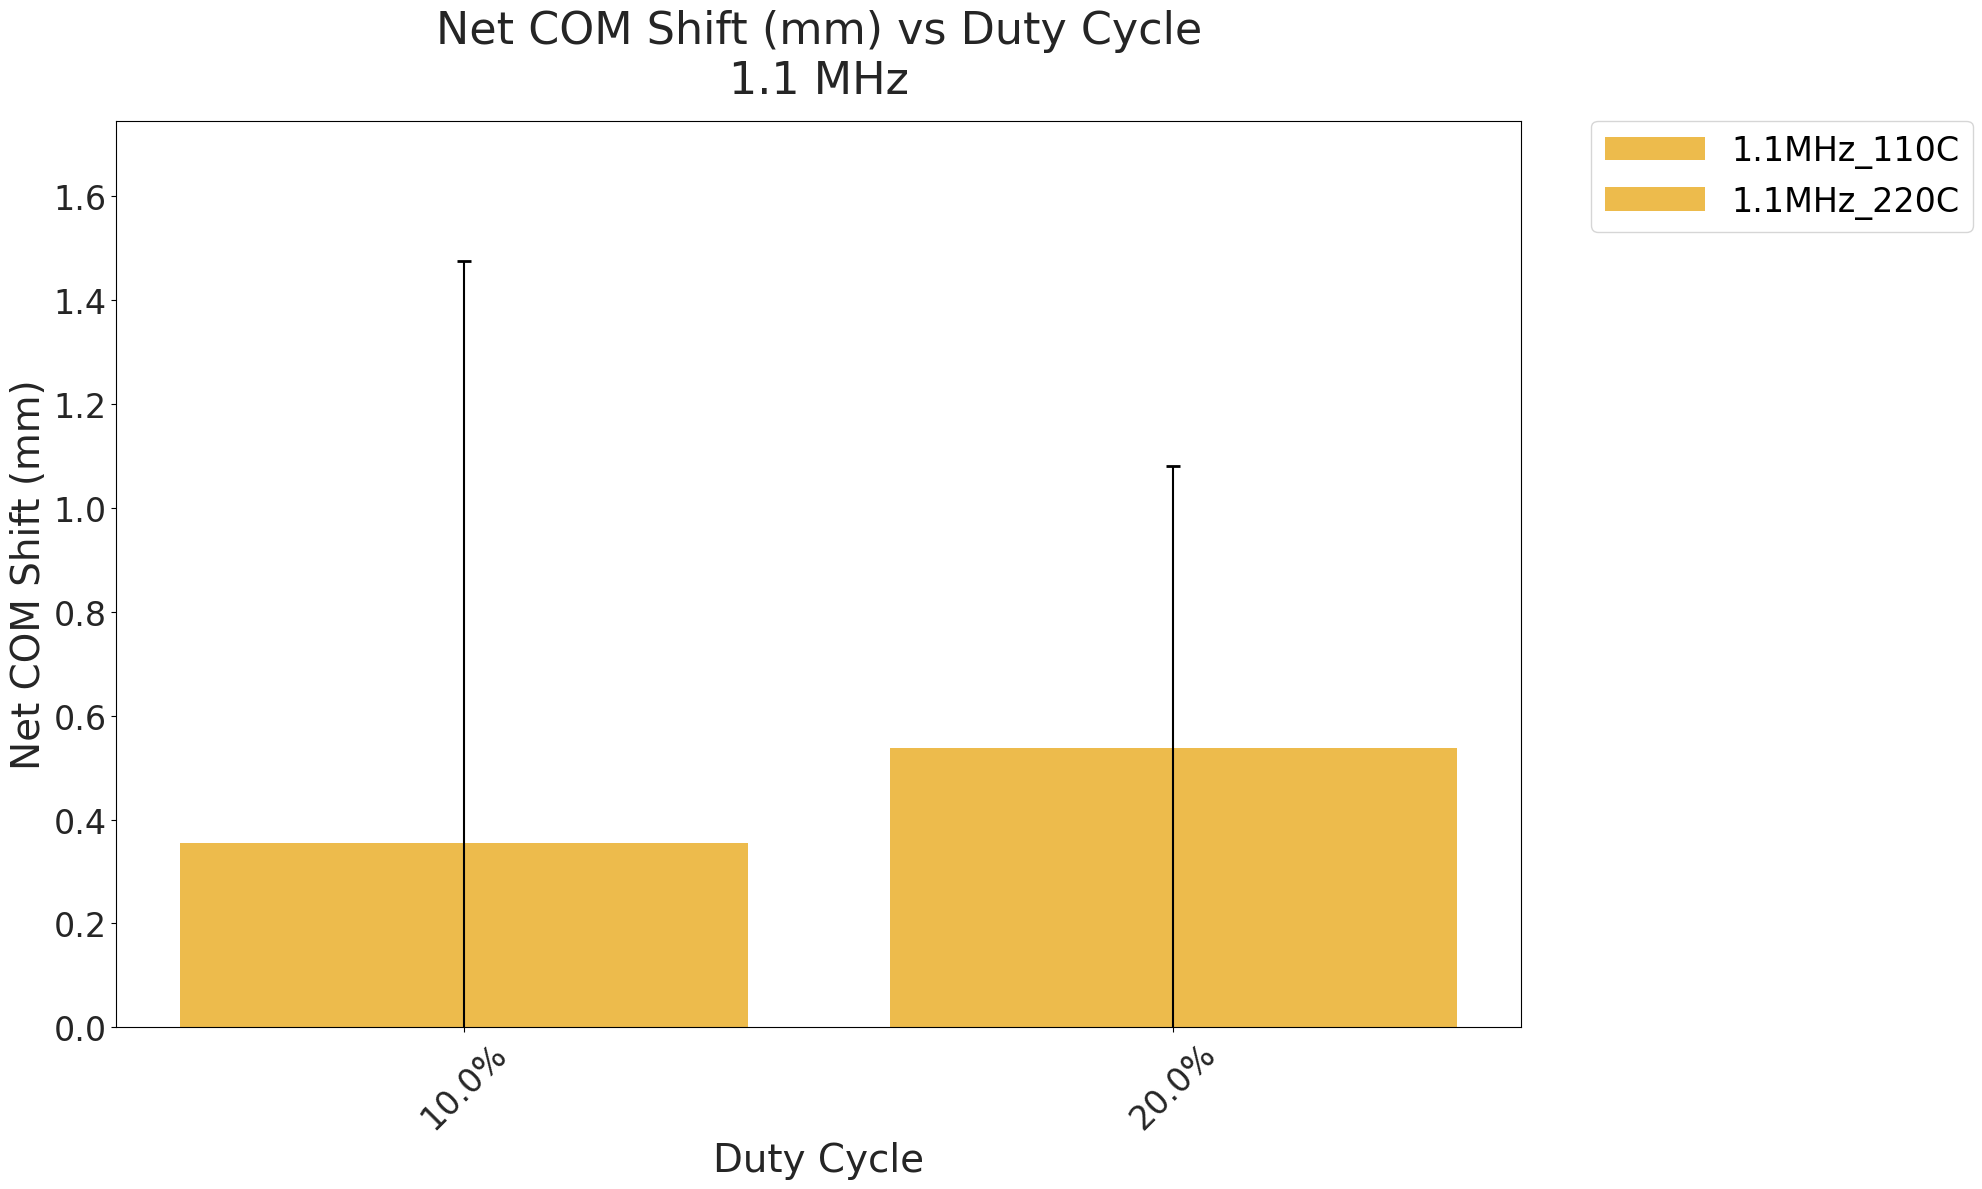

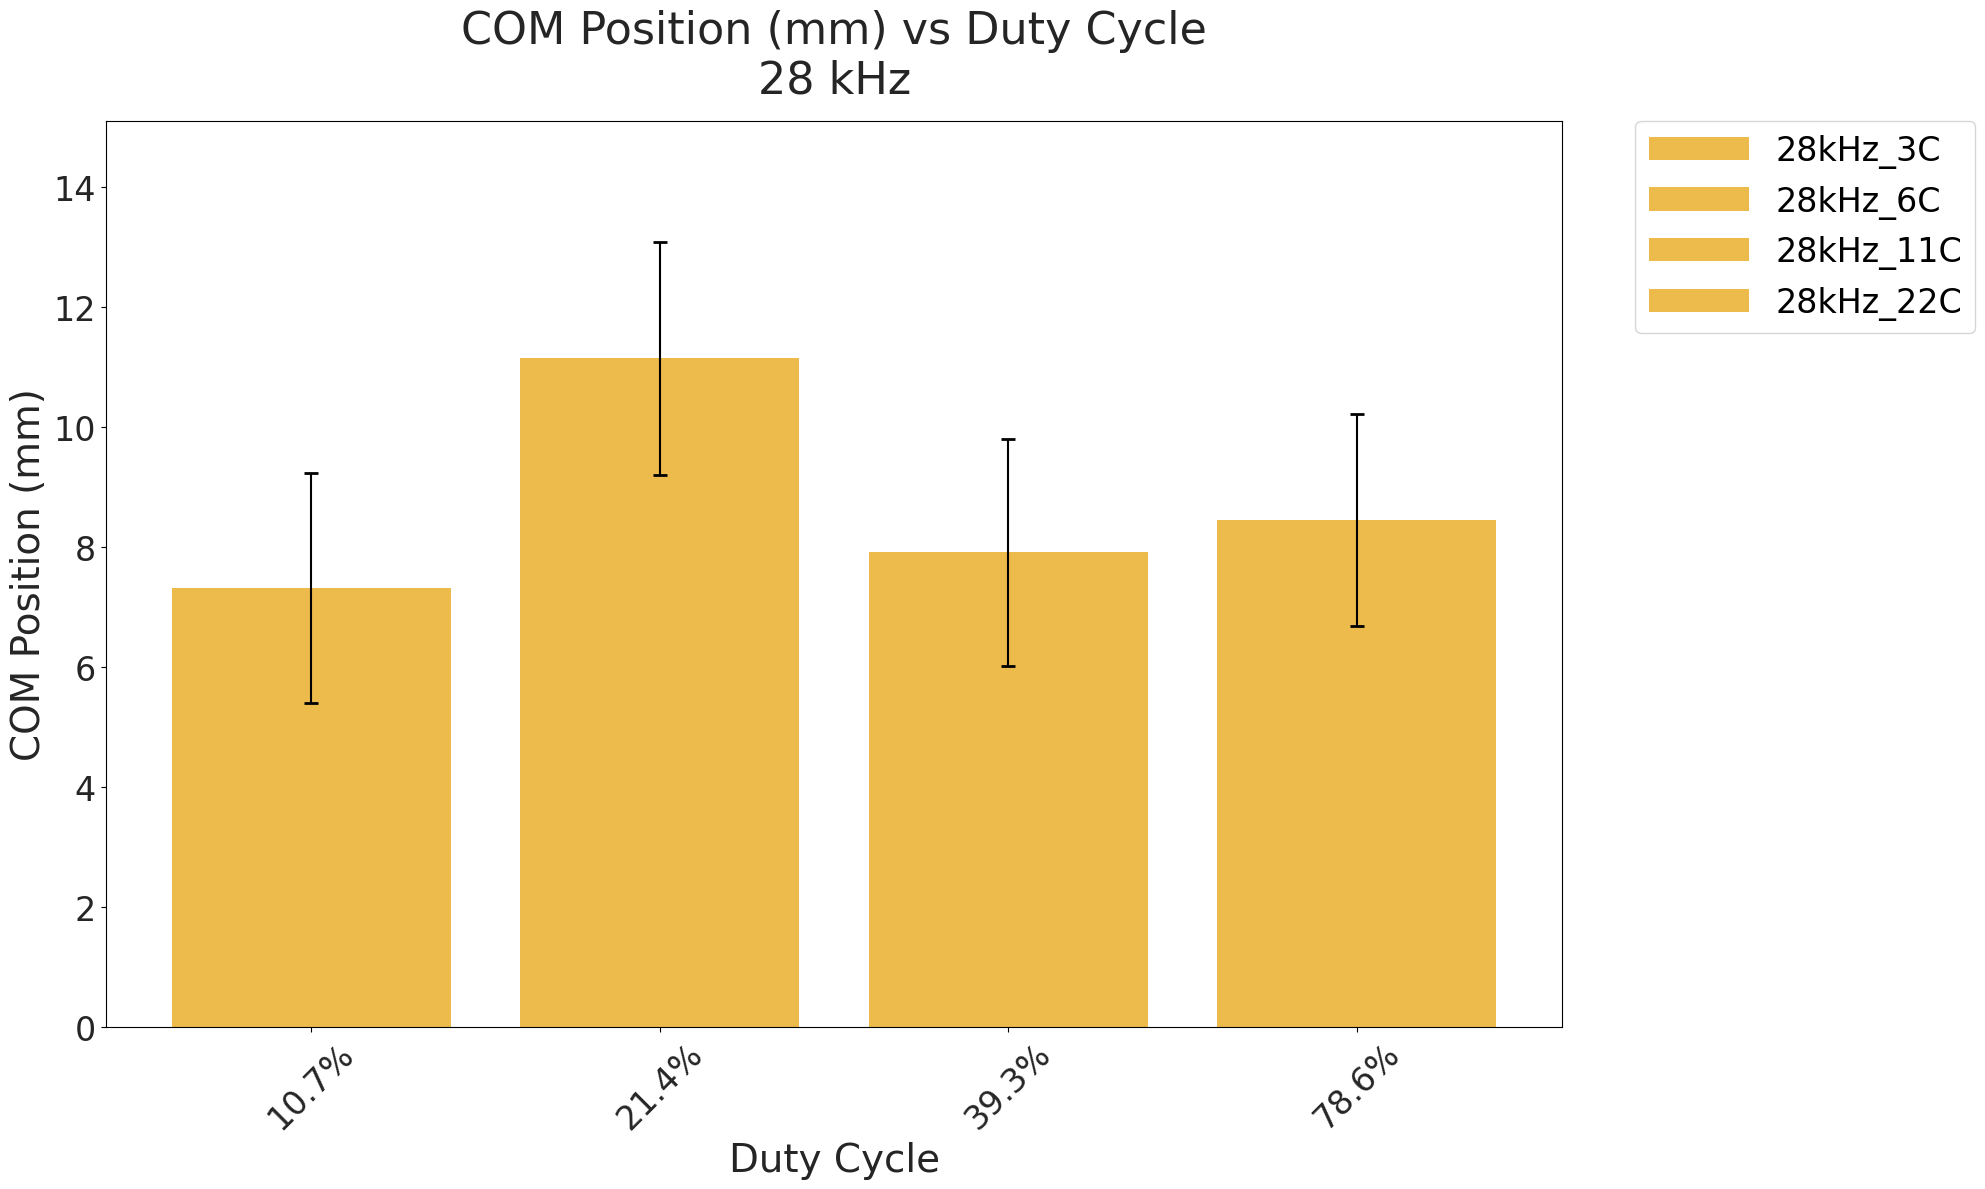

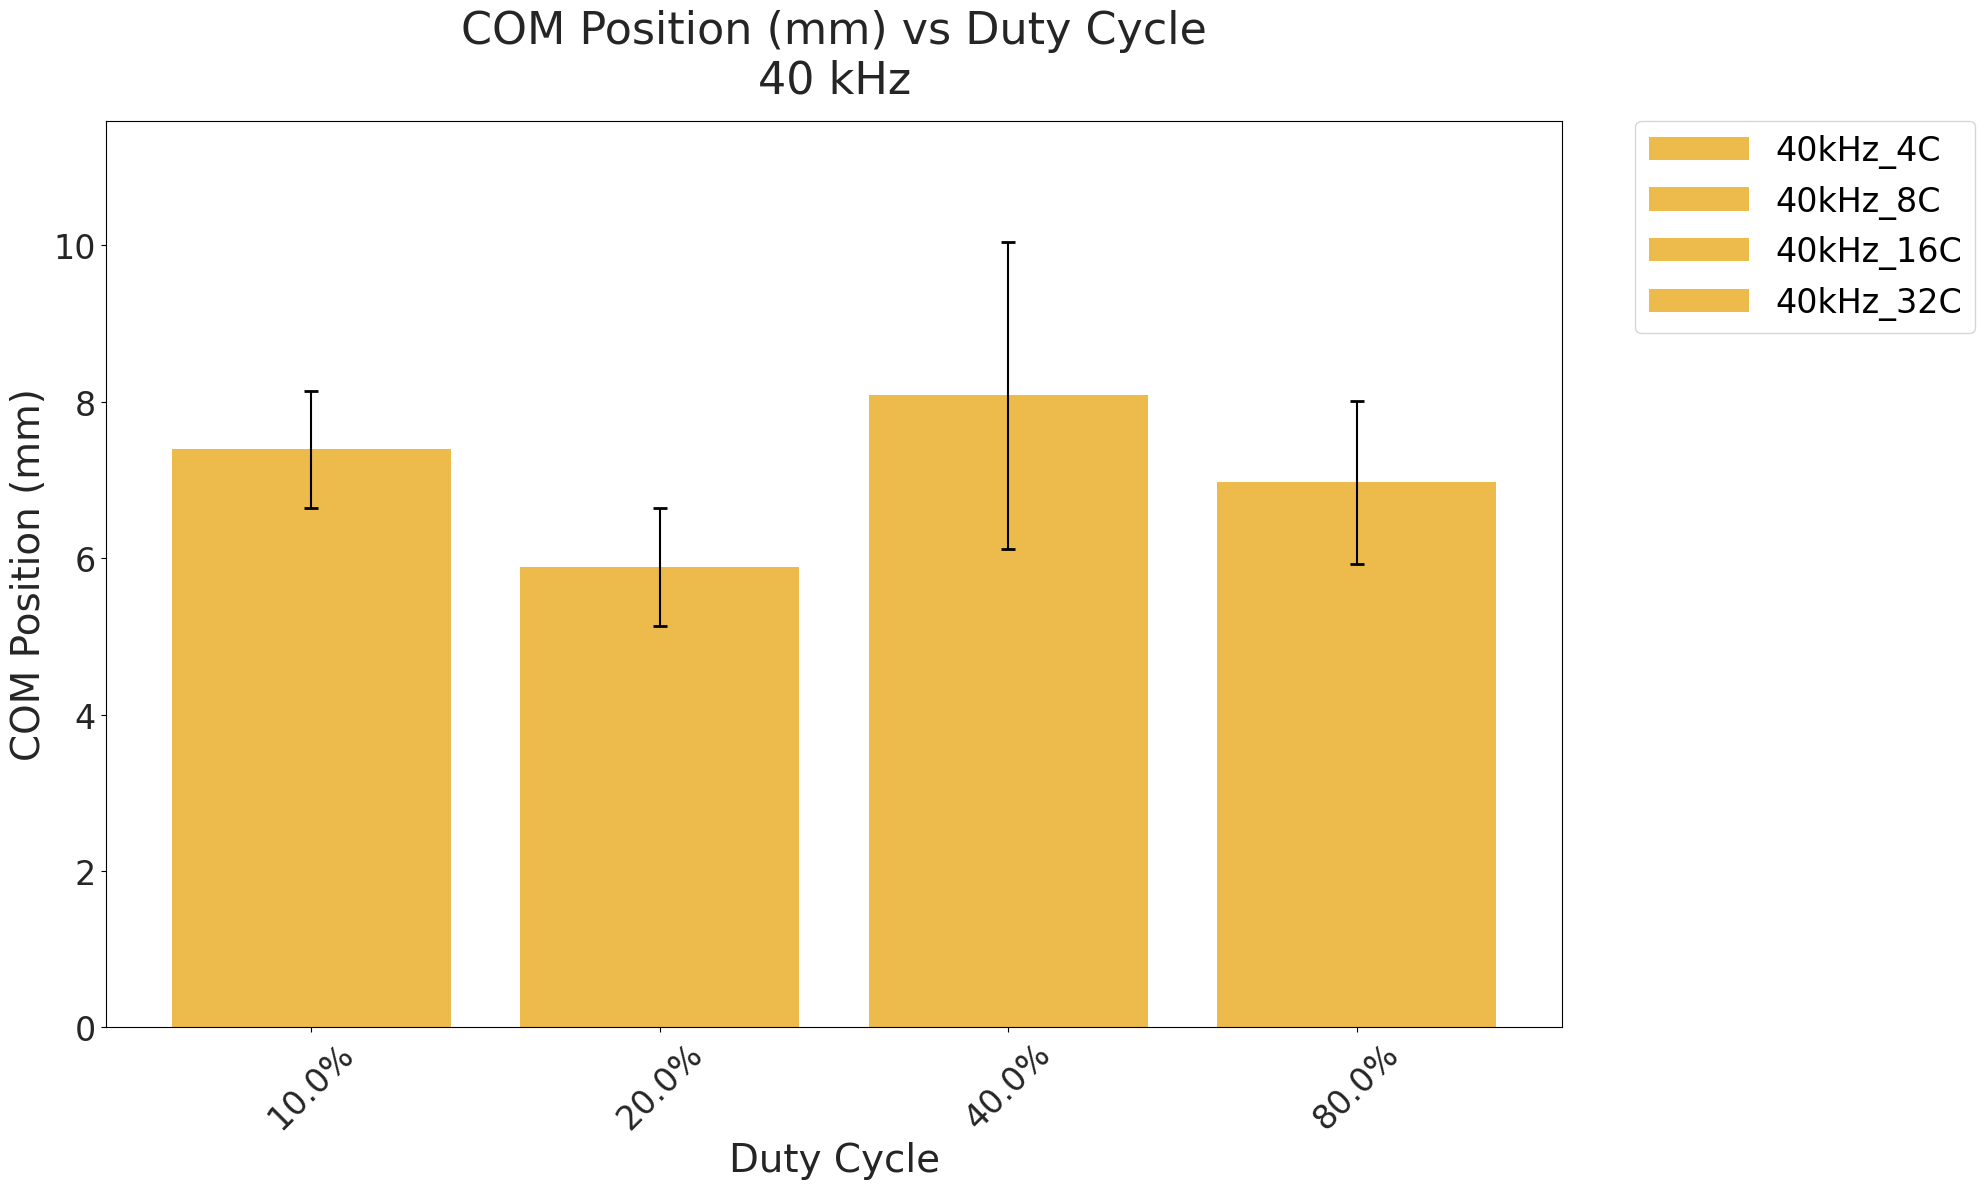

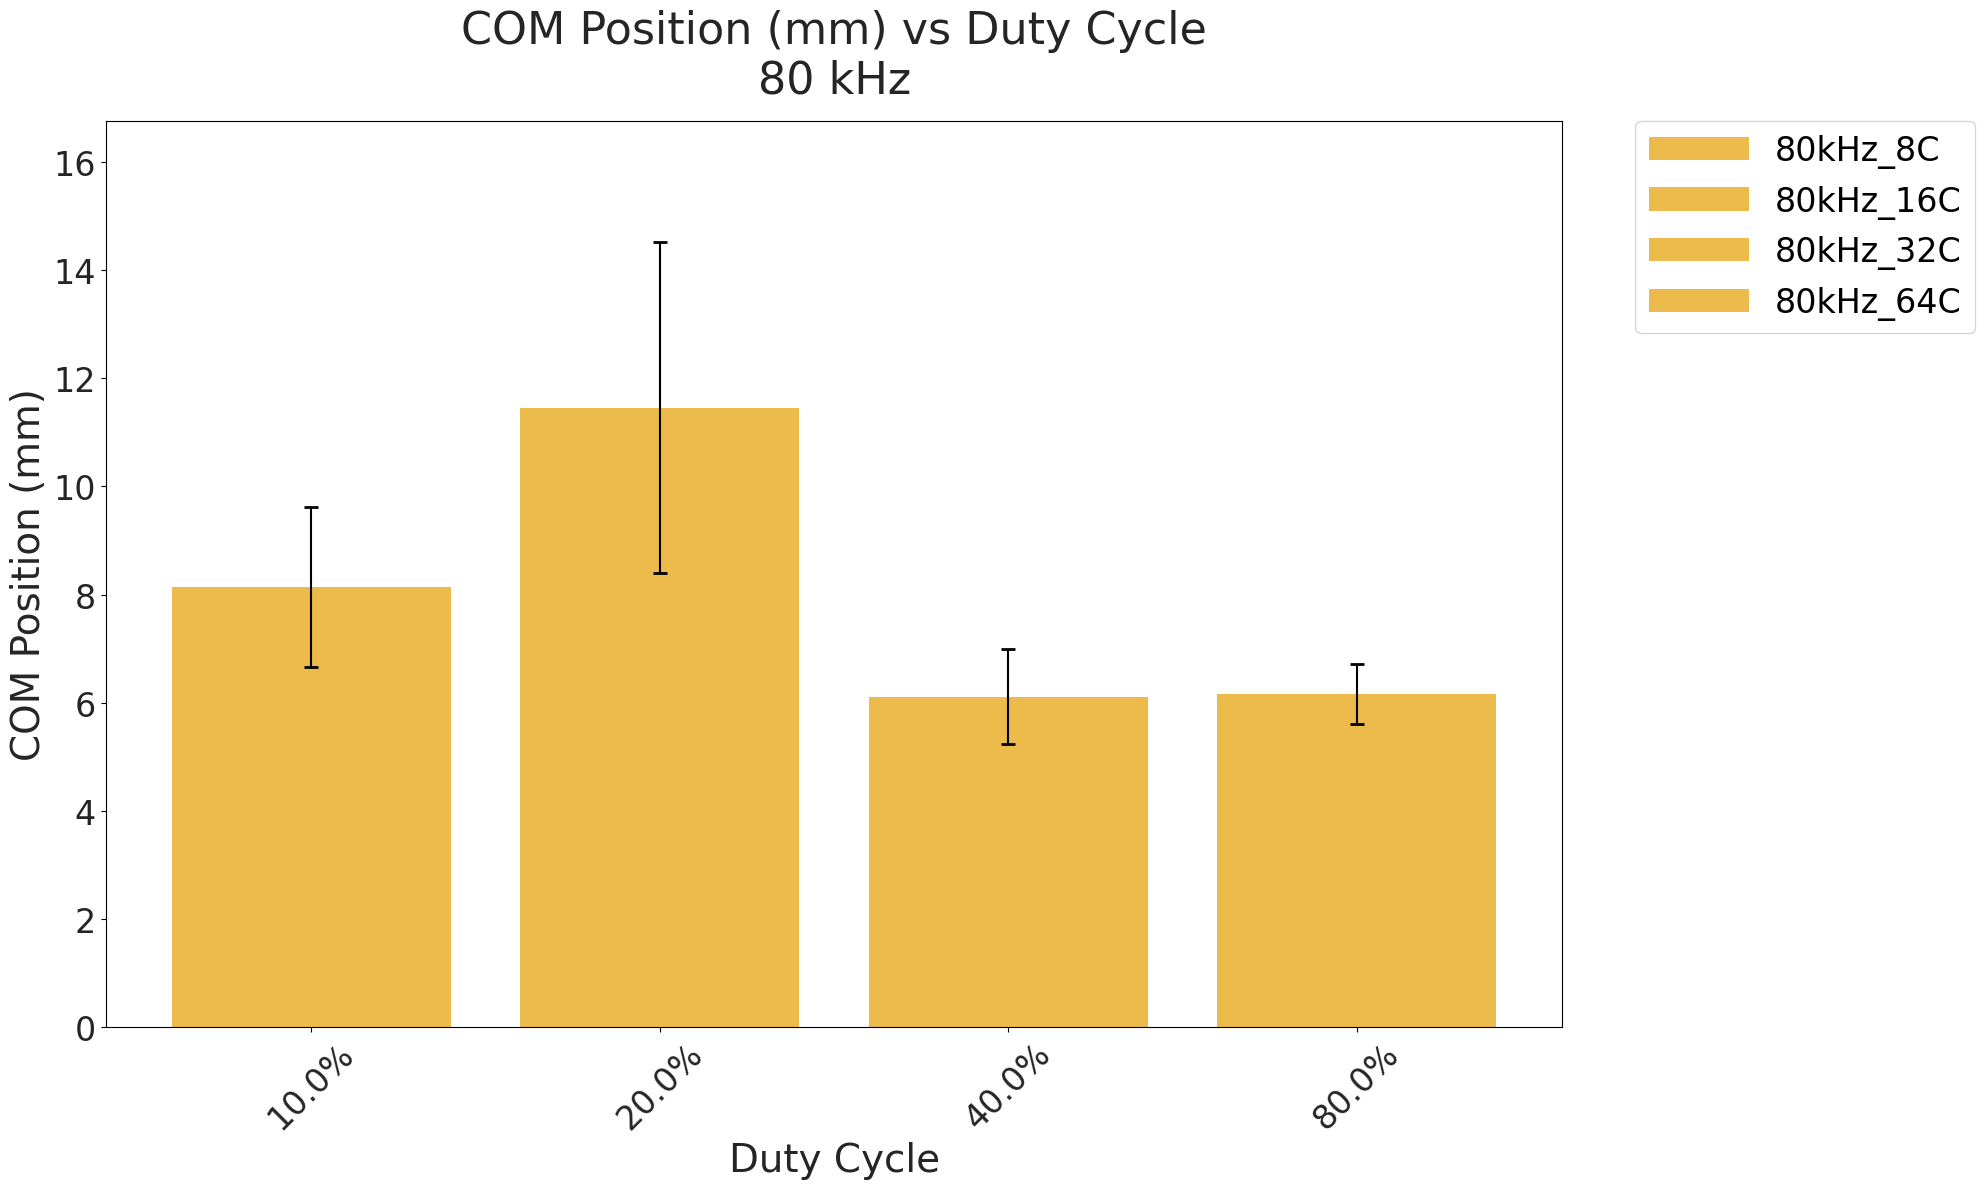

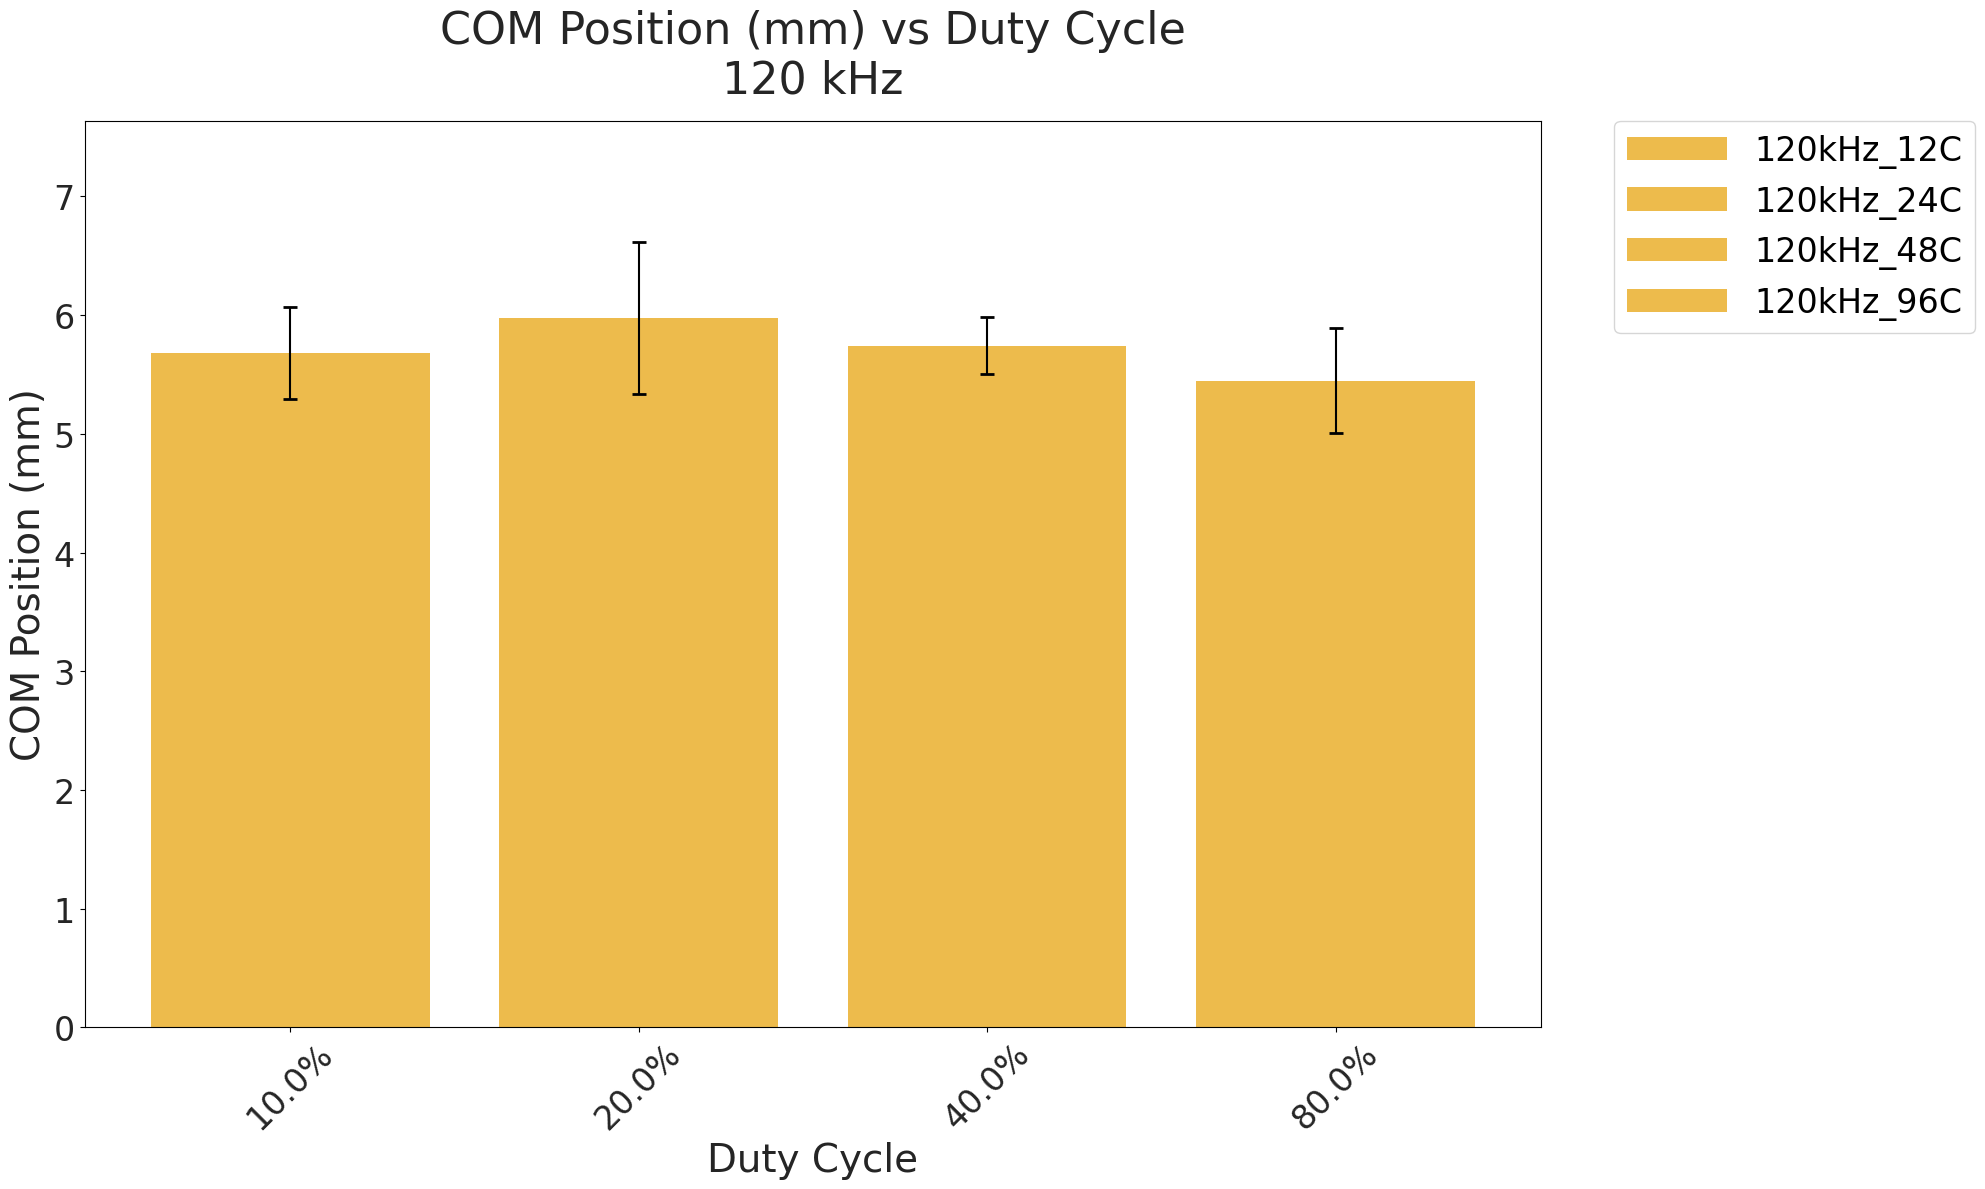

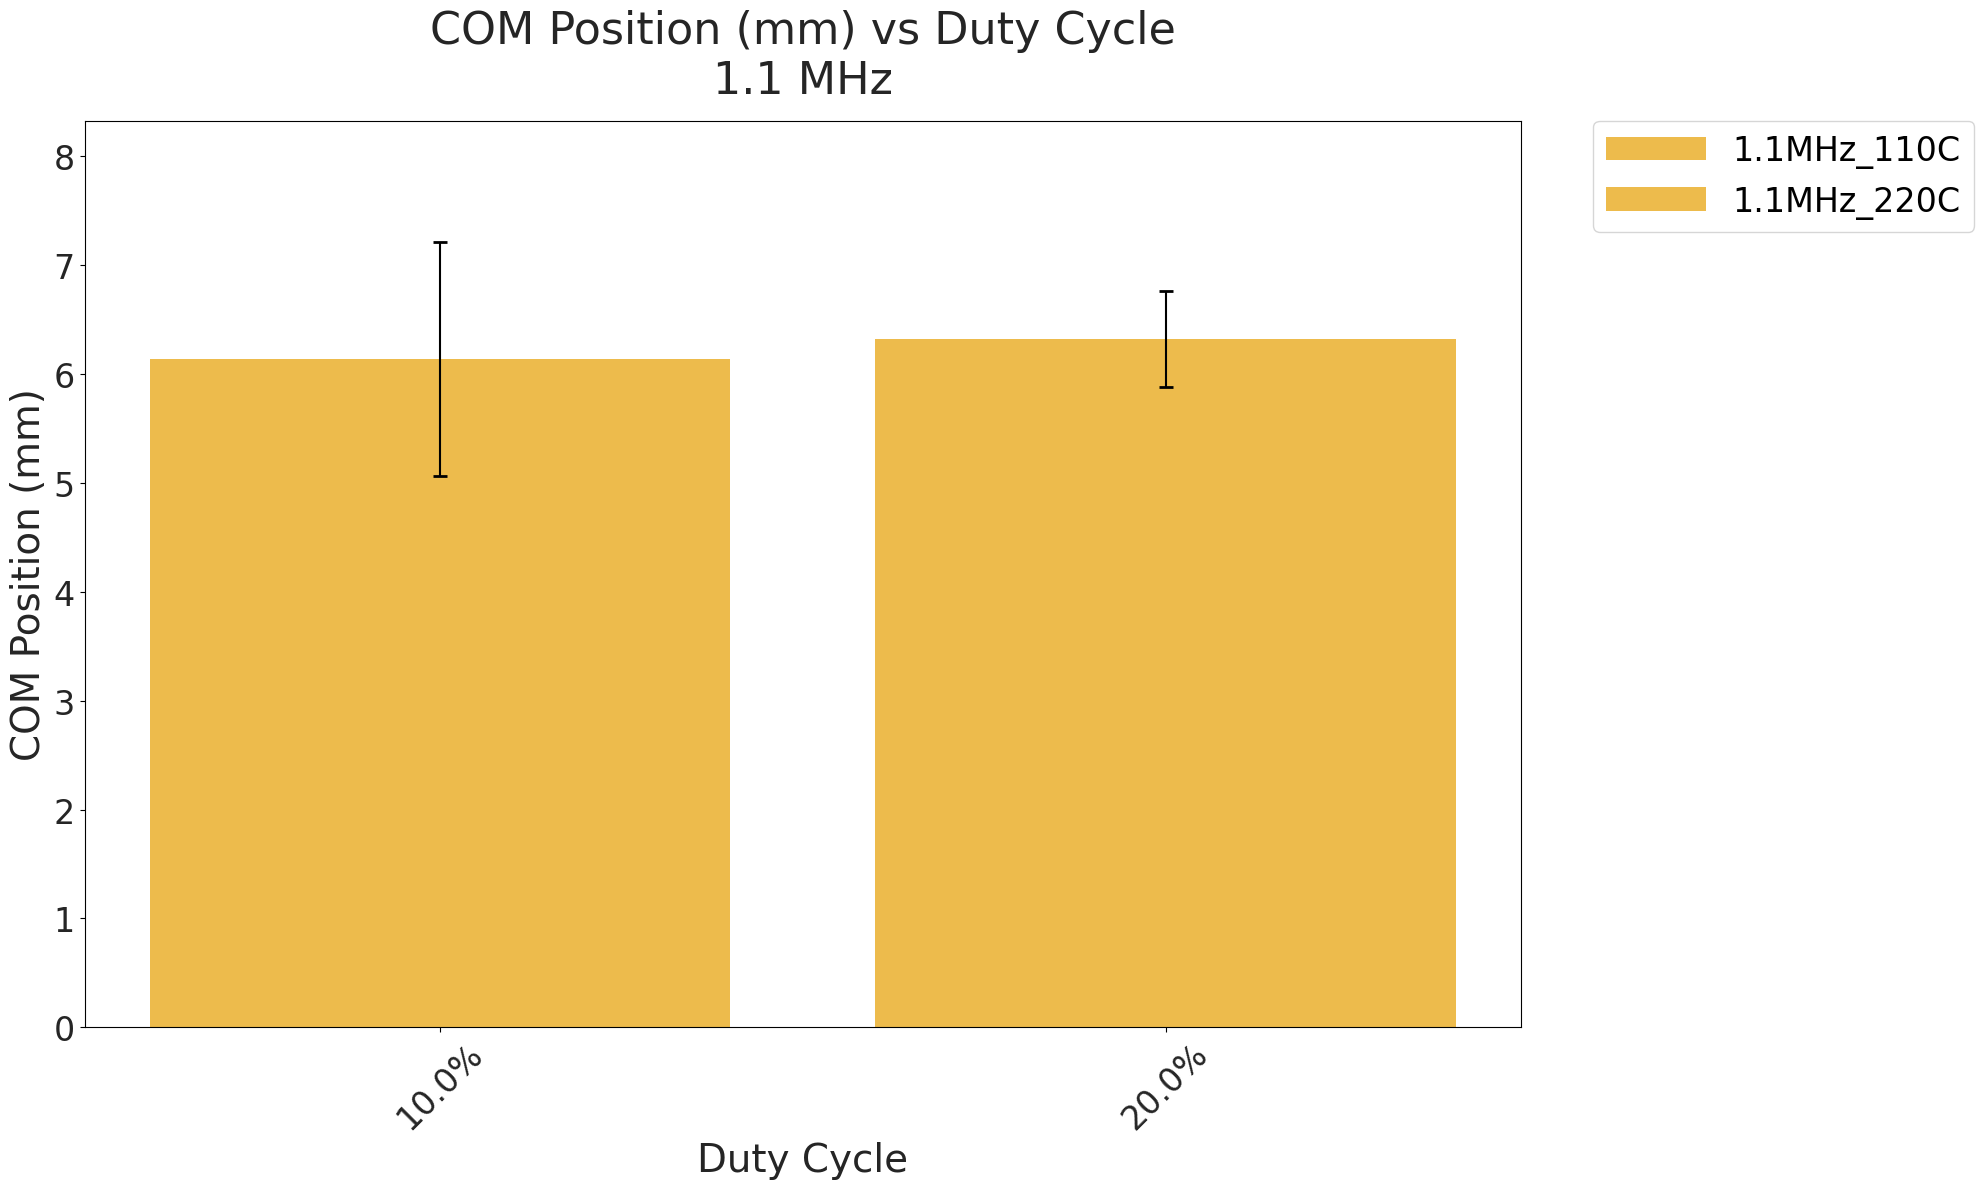

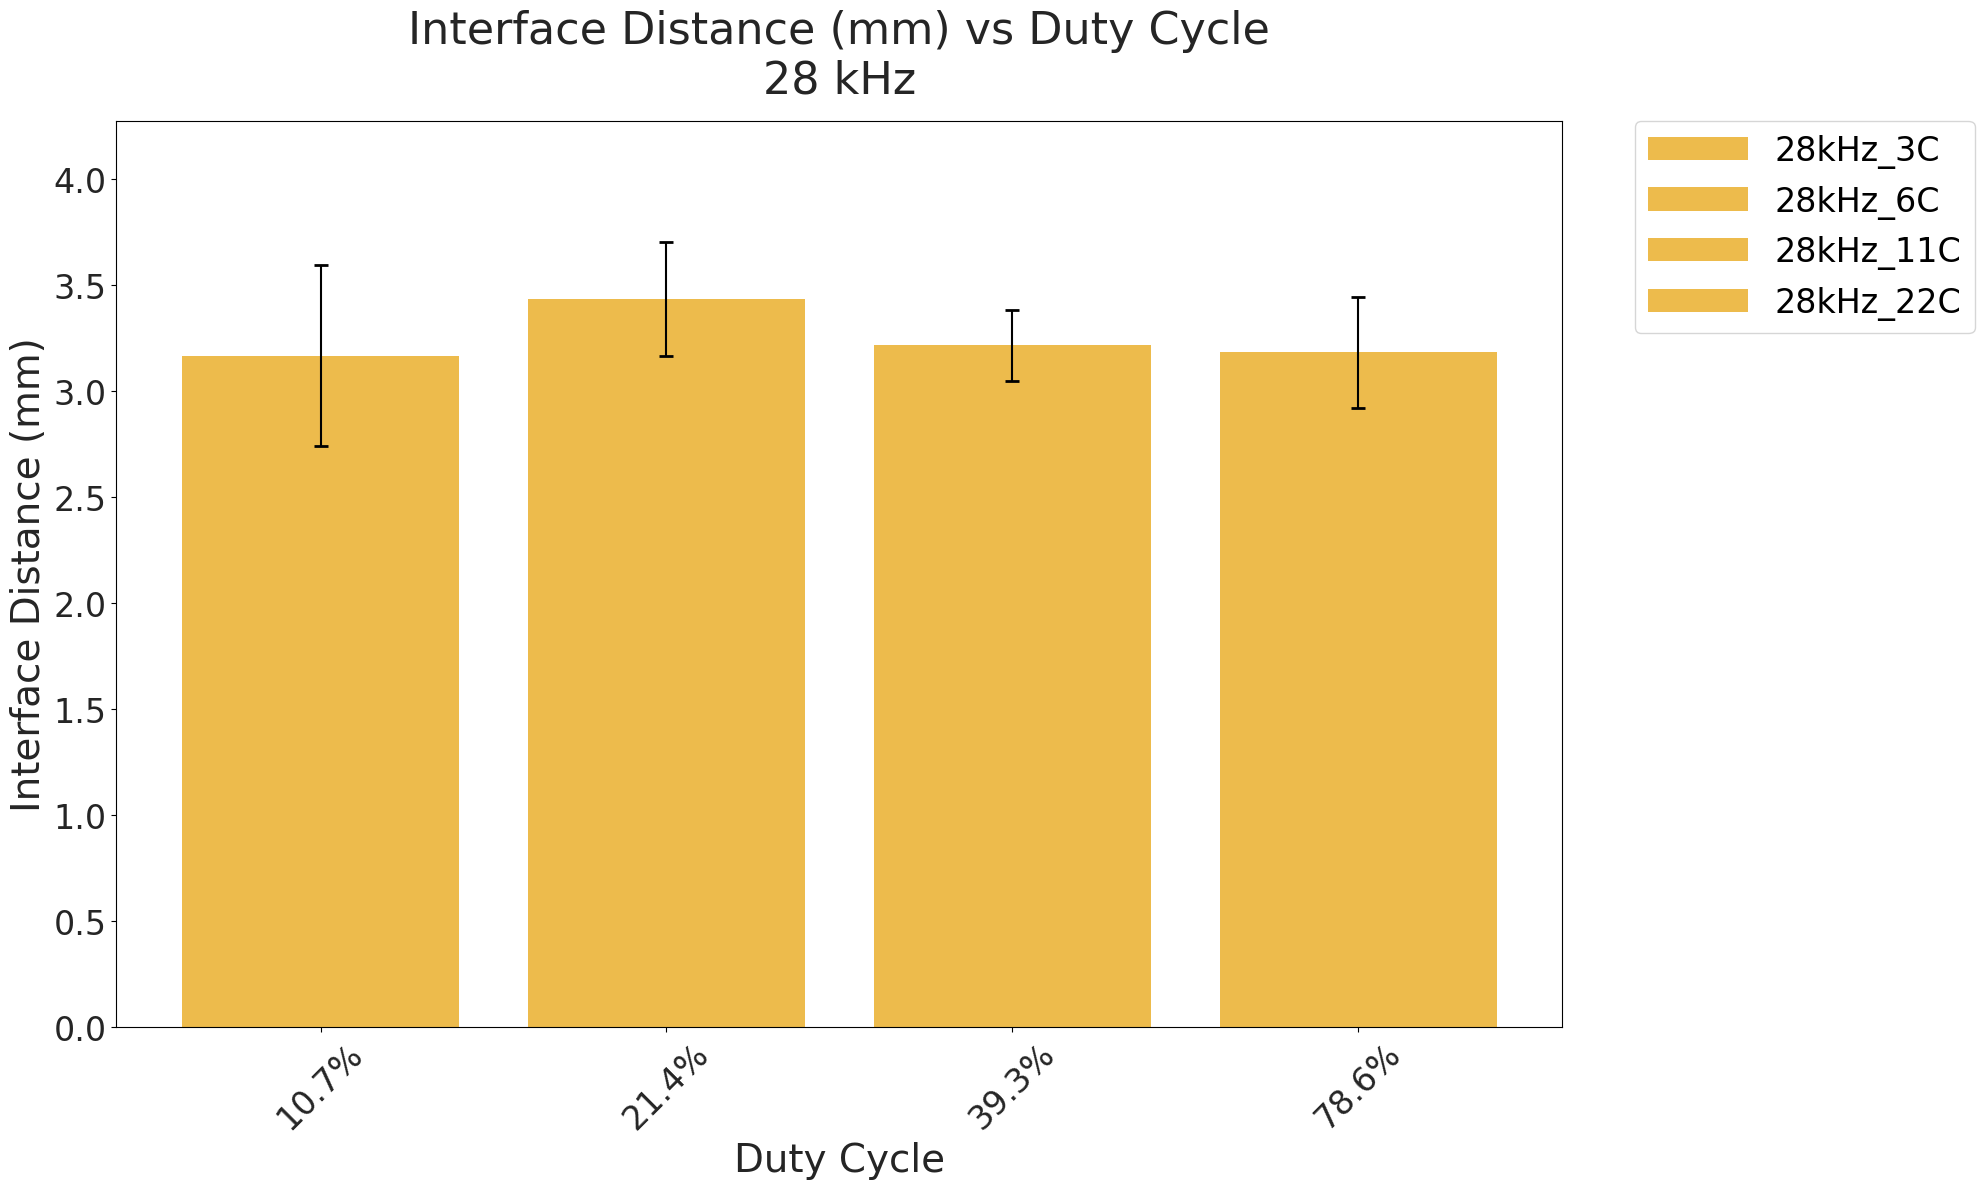

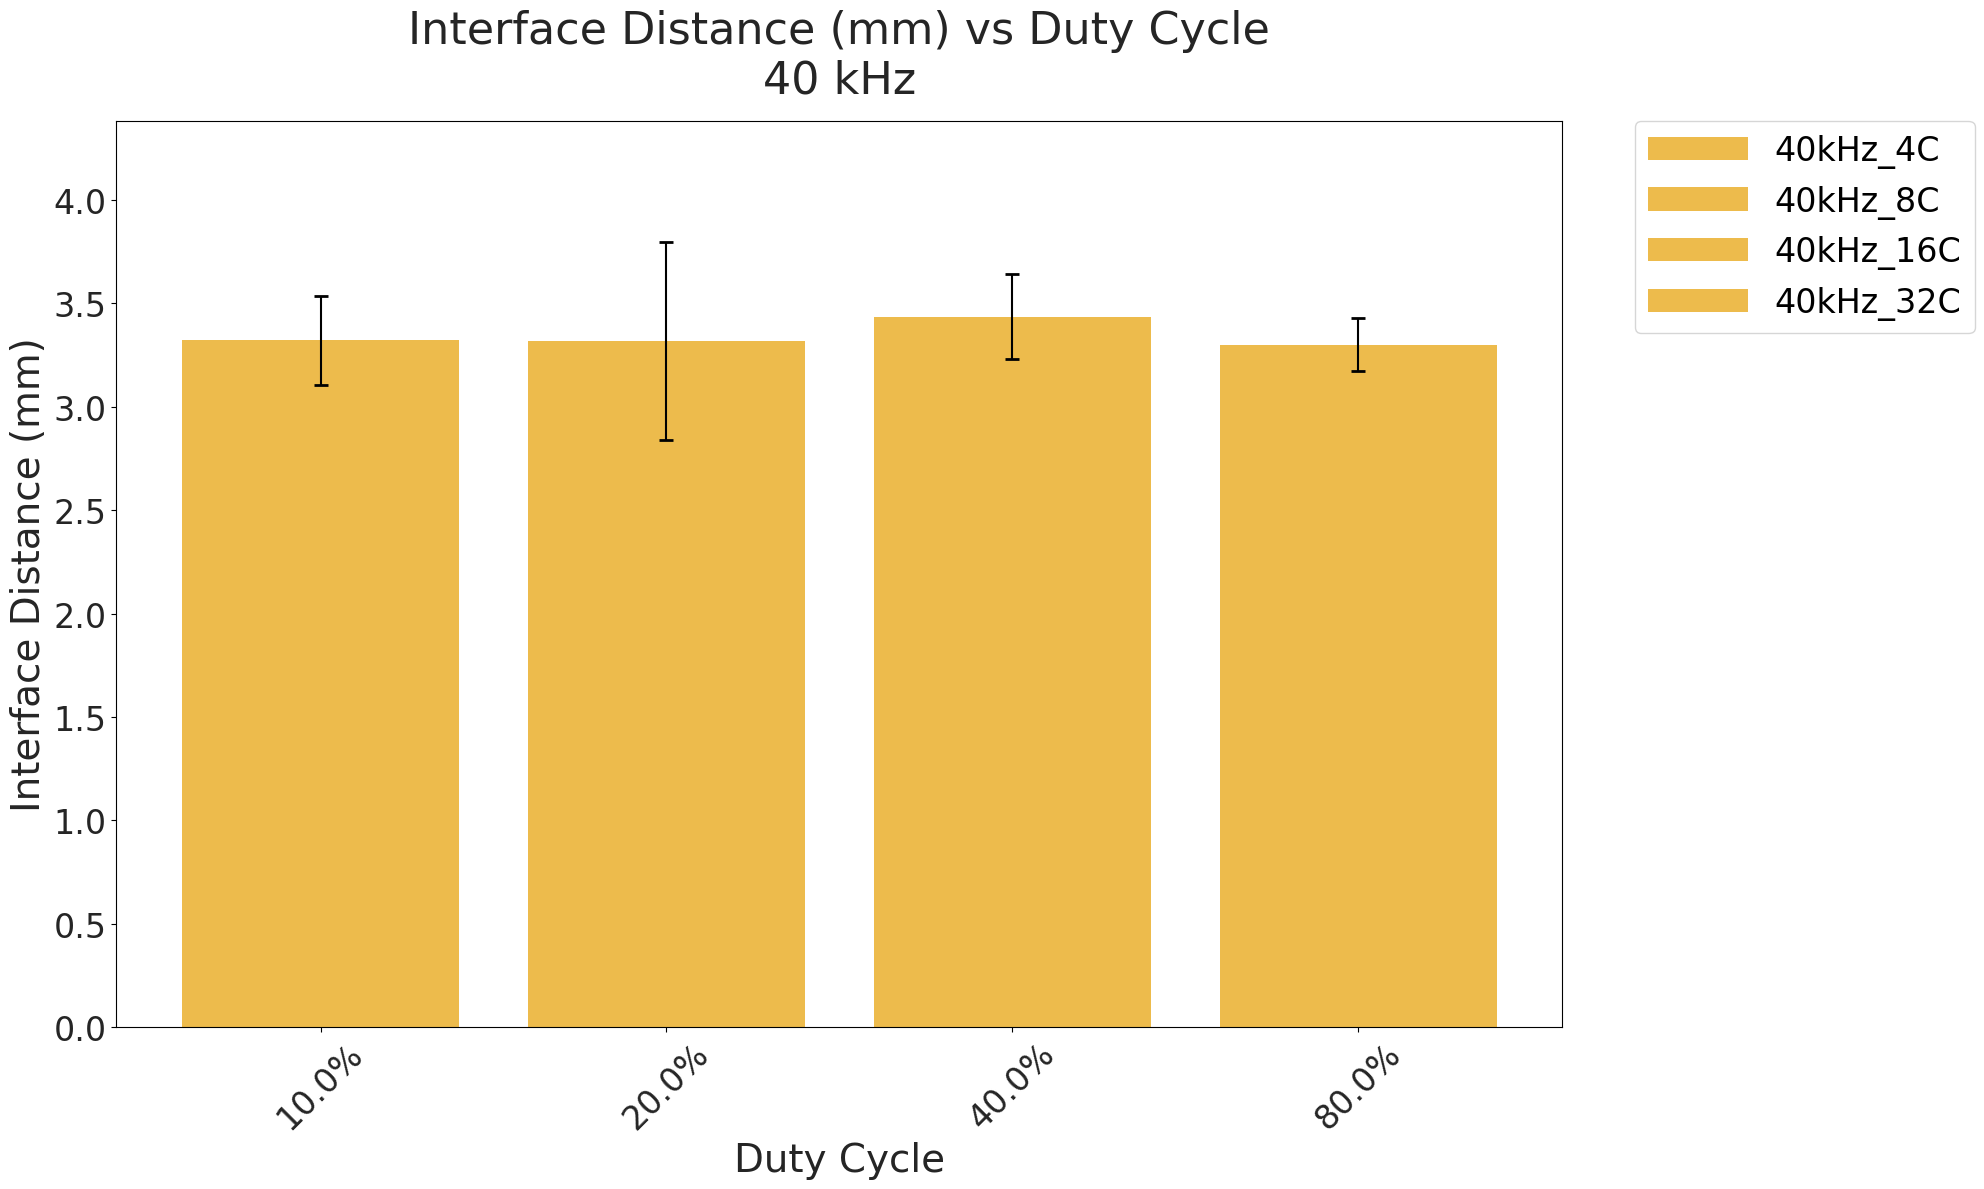

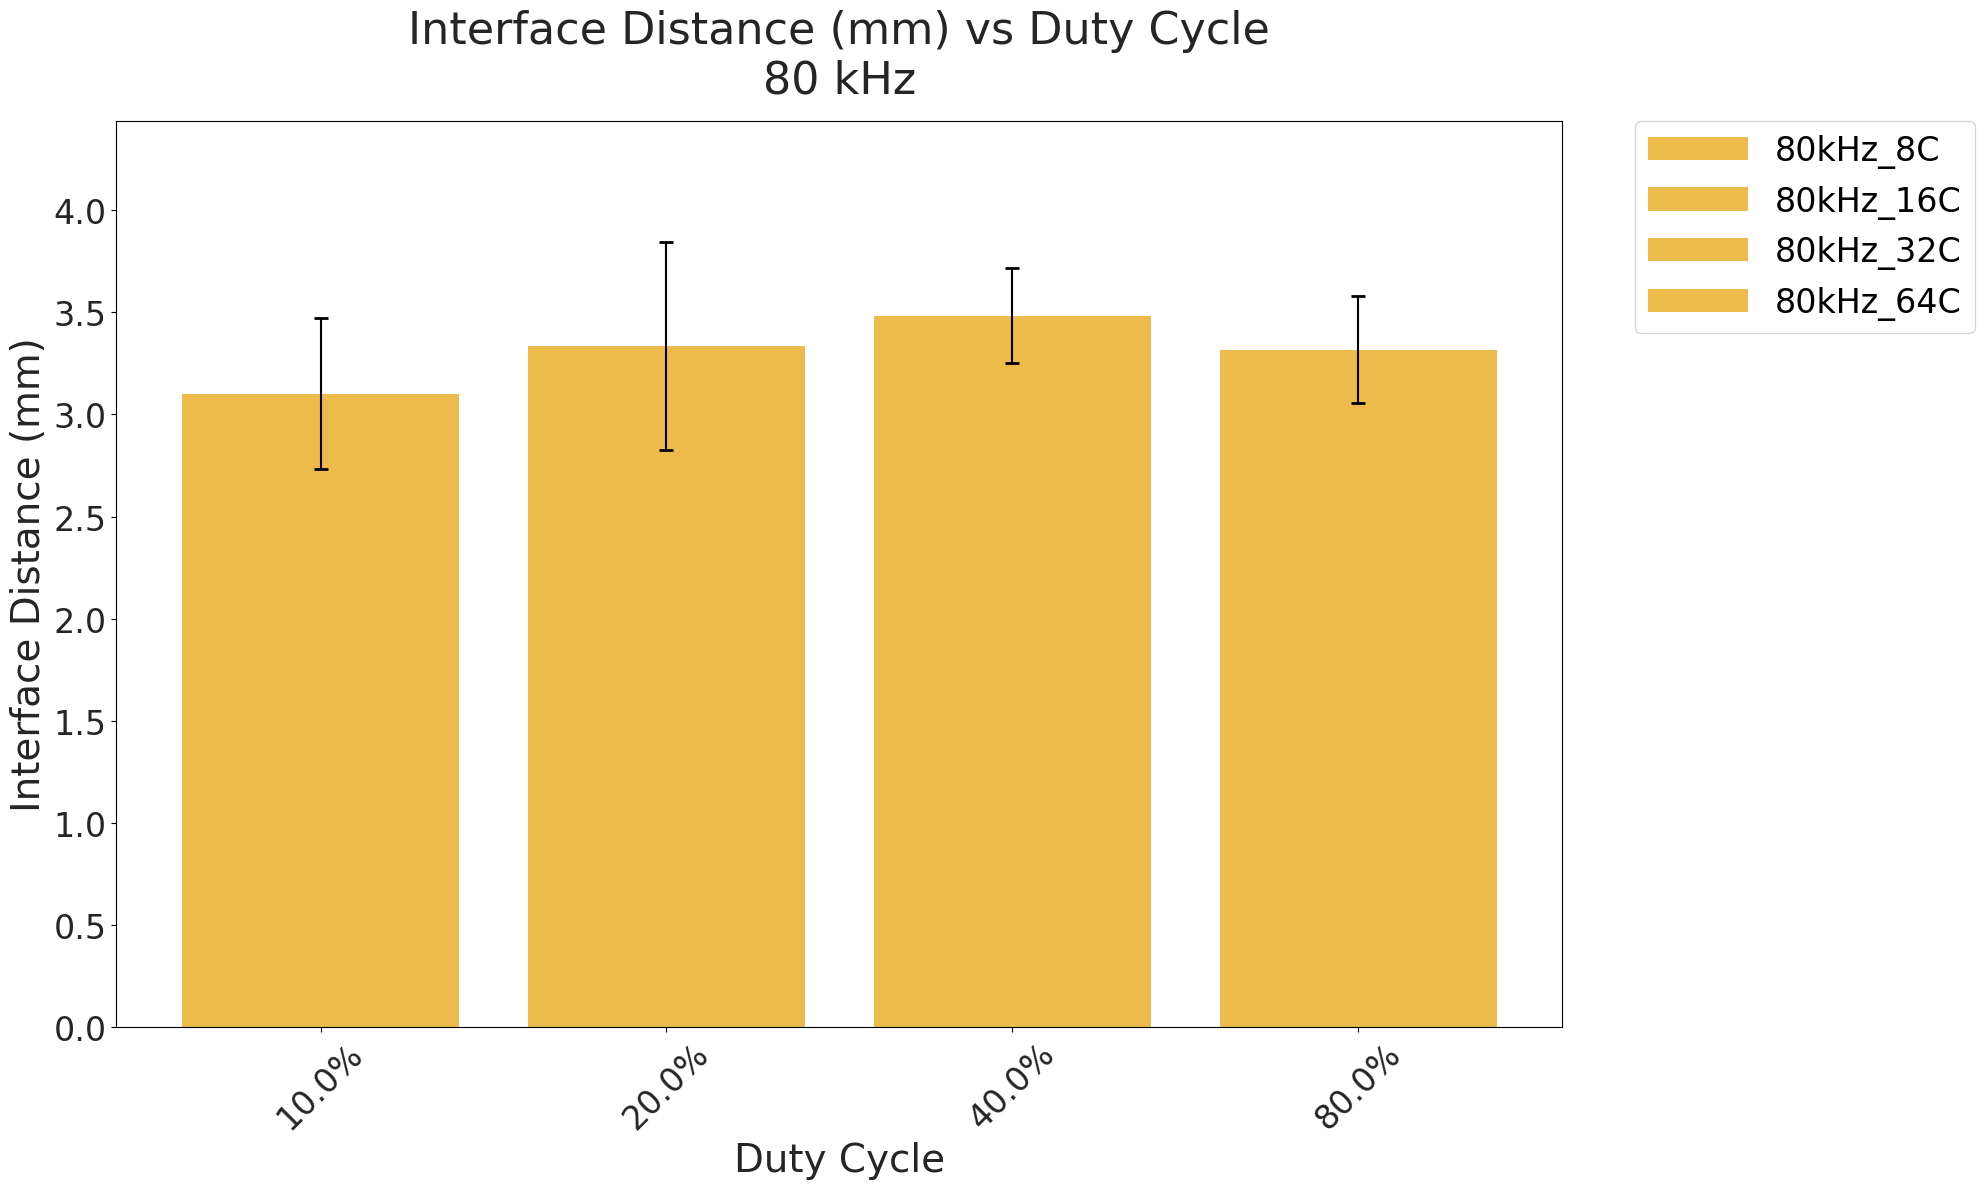

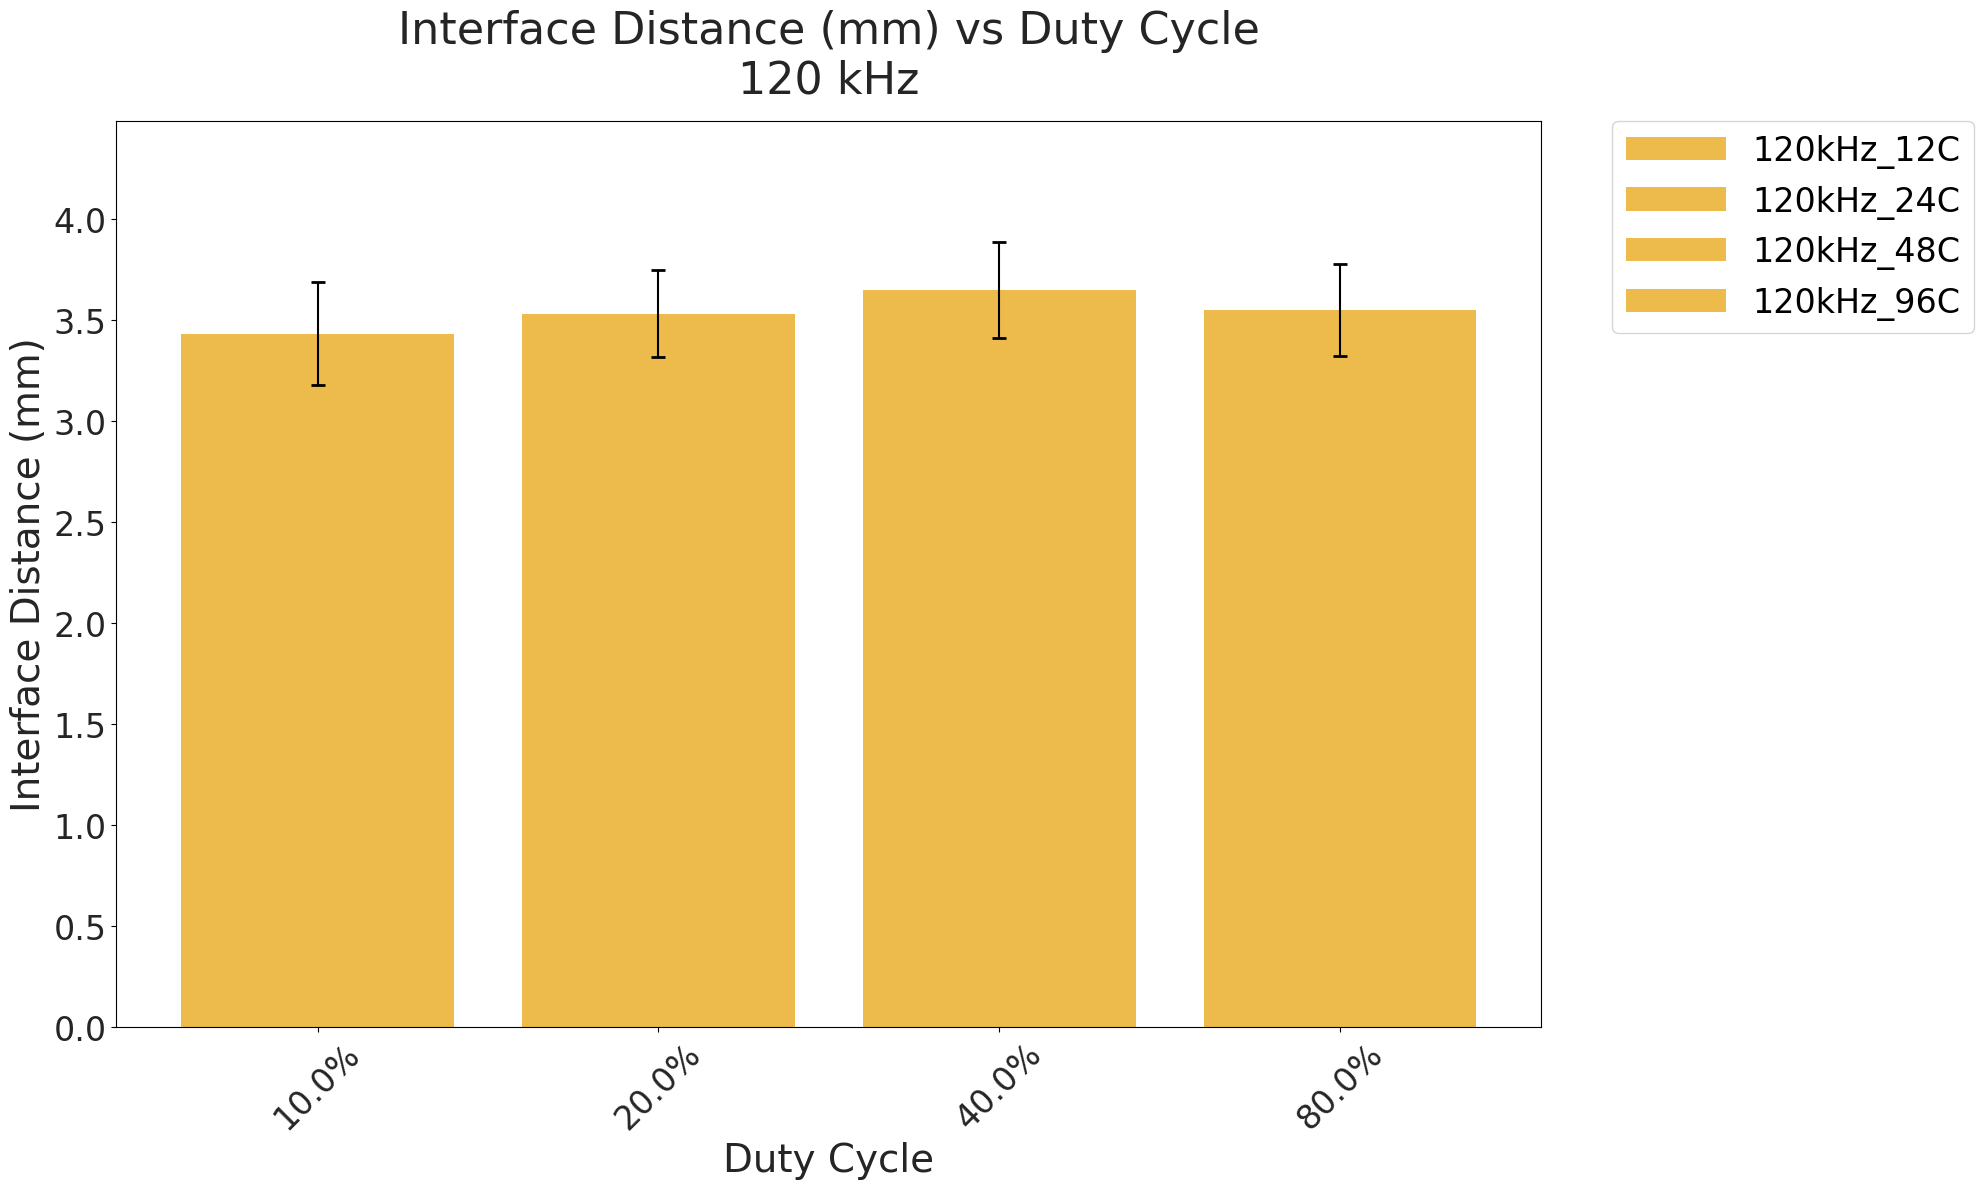

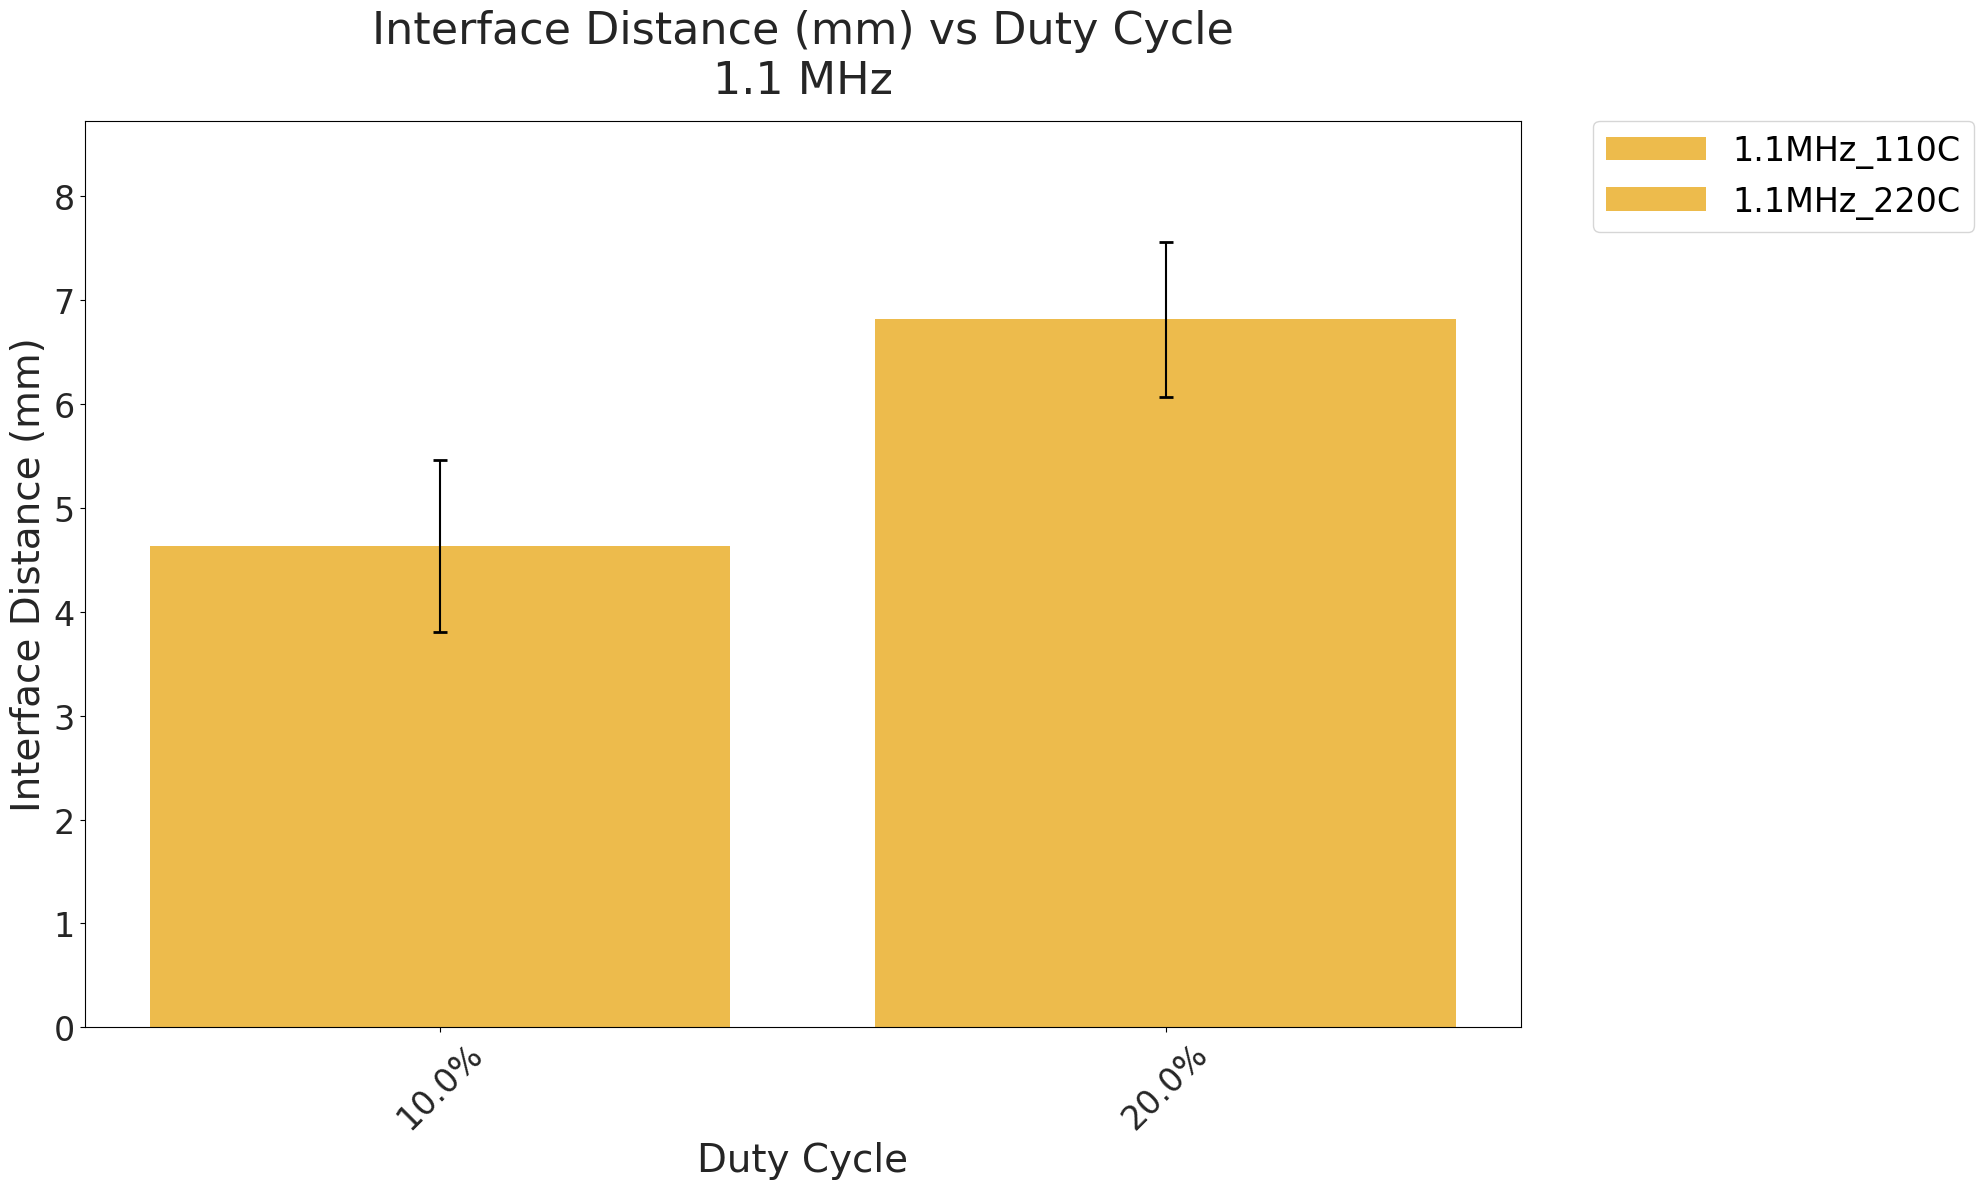


Generating COM shift plots by duty cycle...


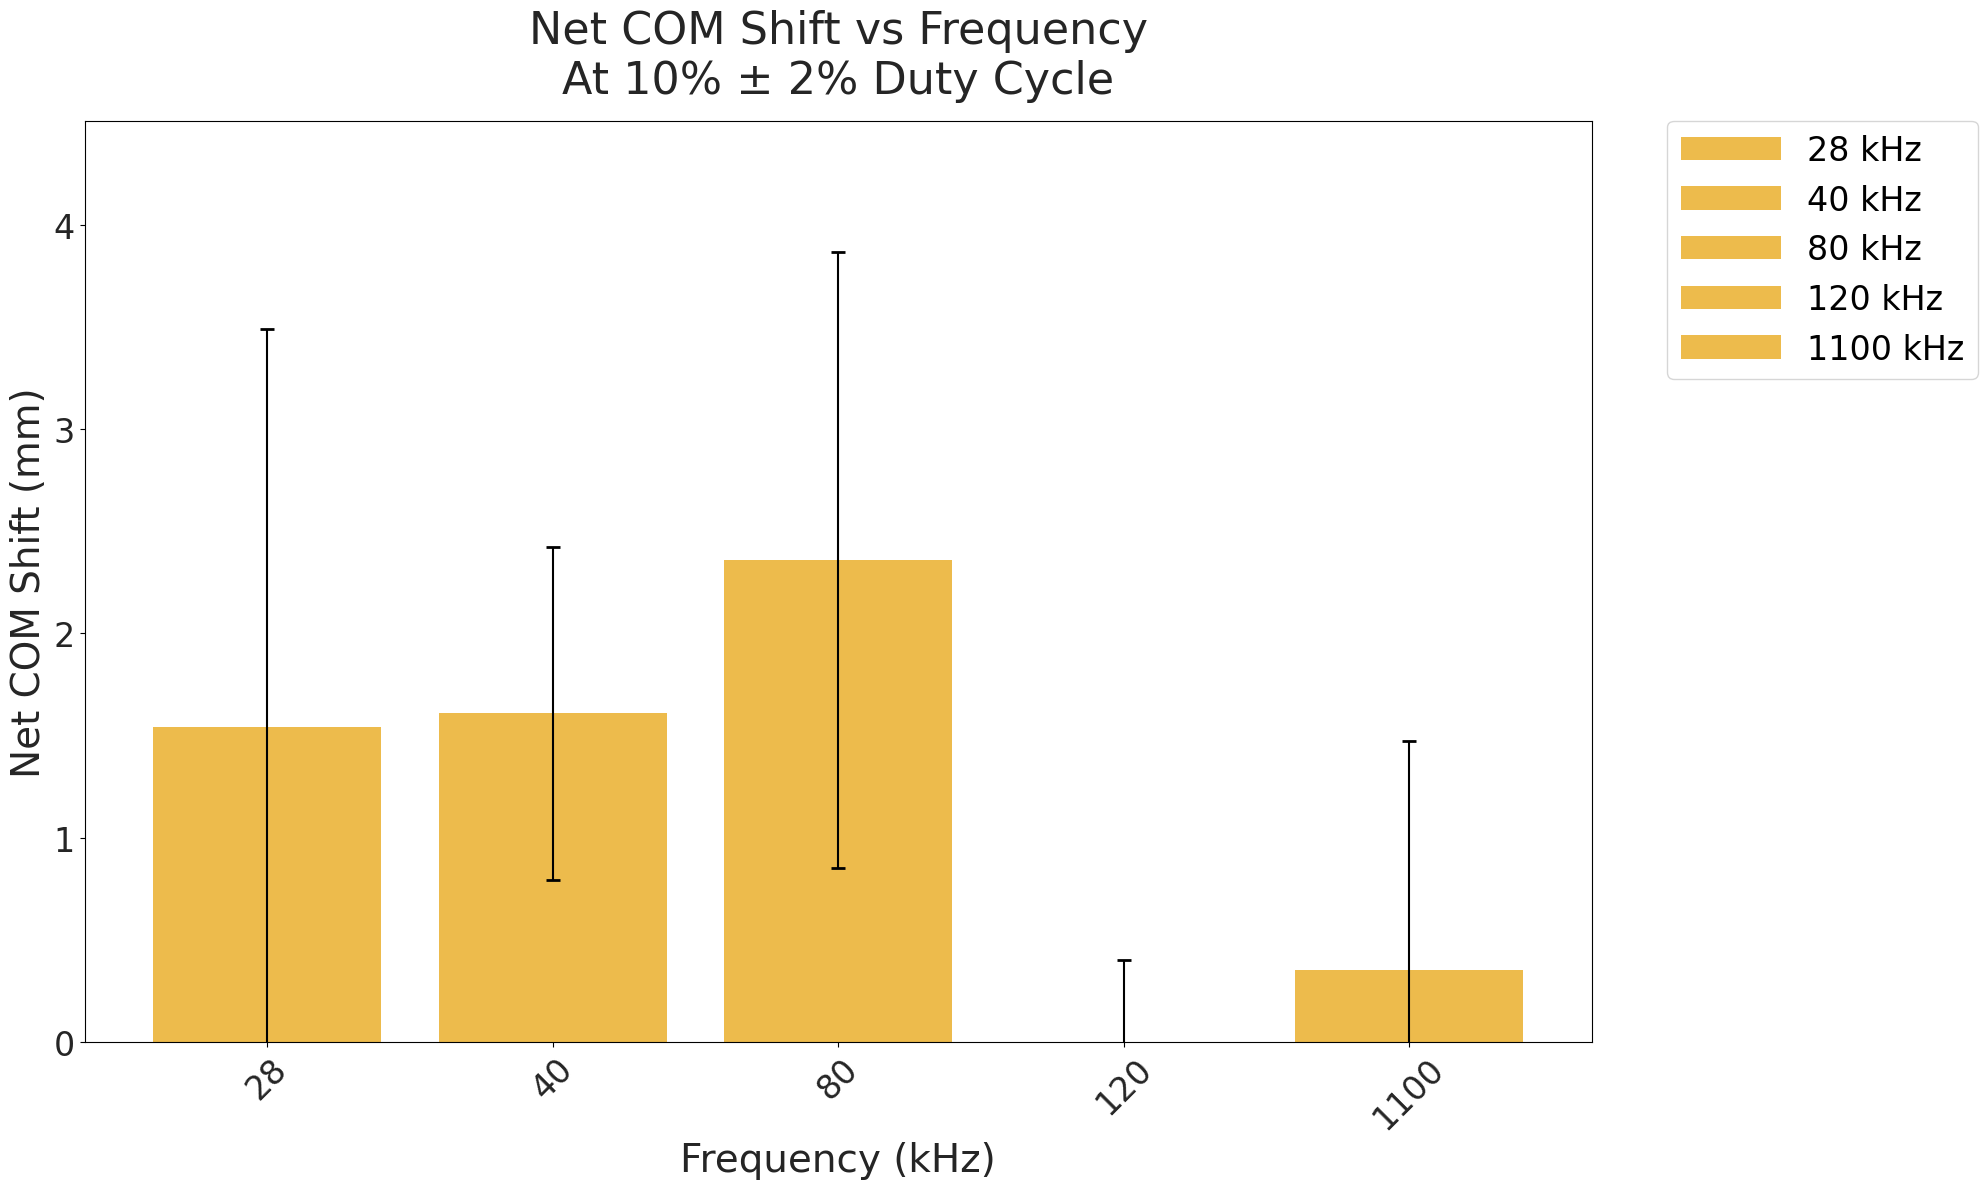

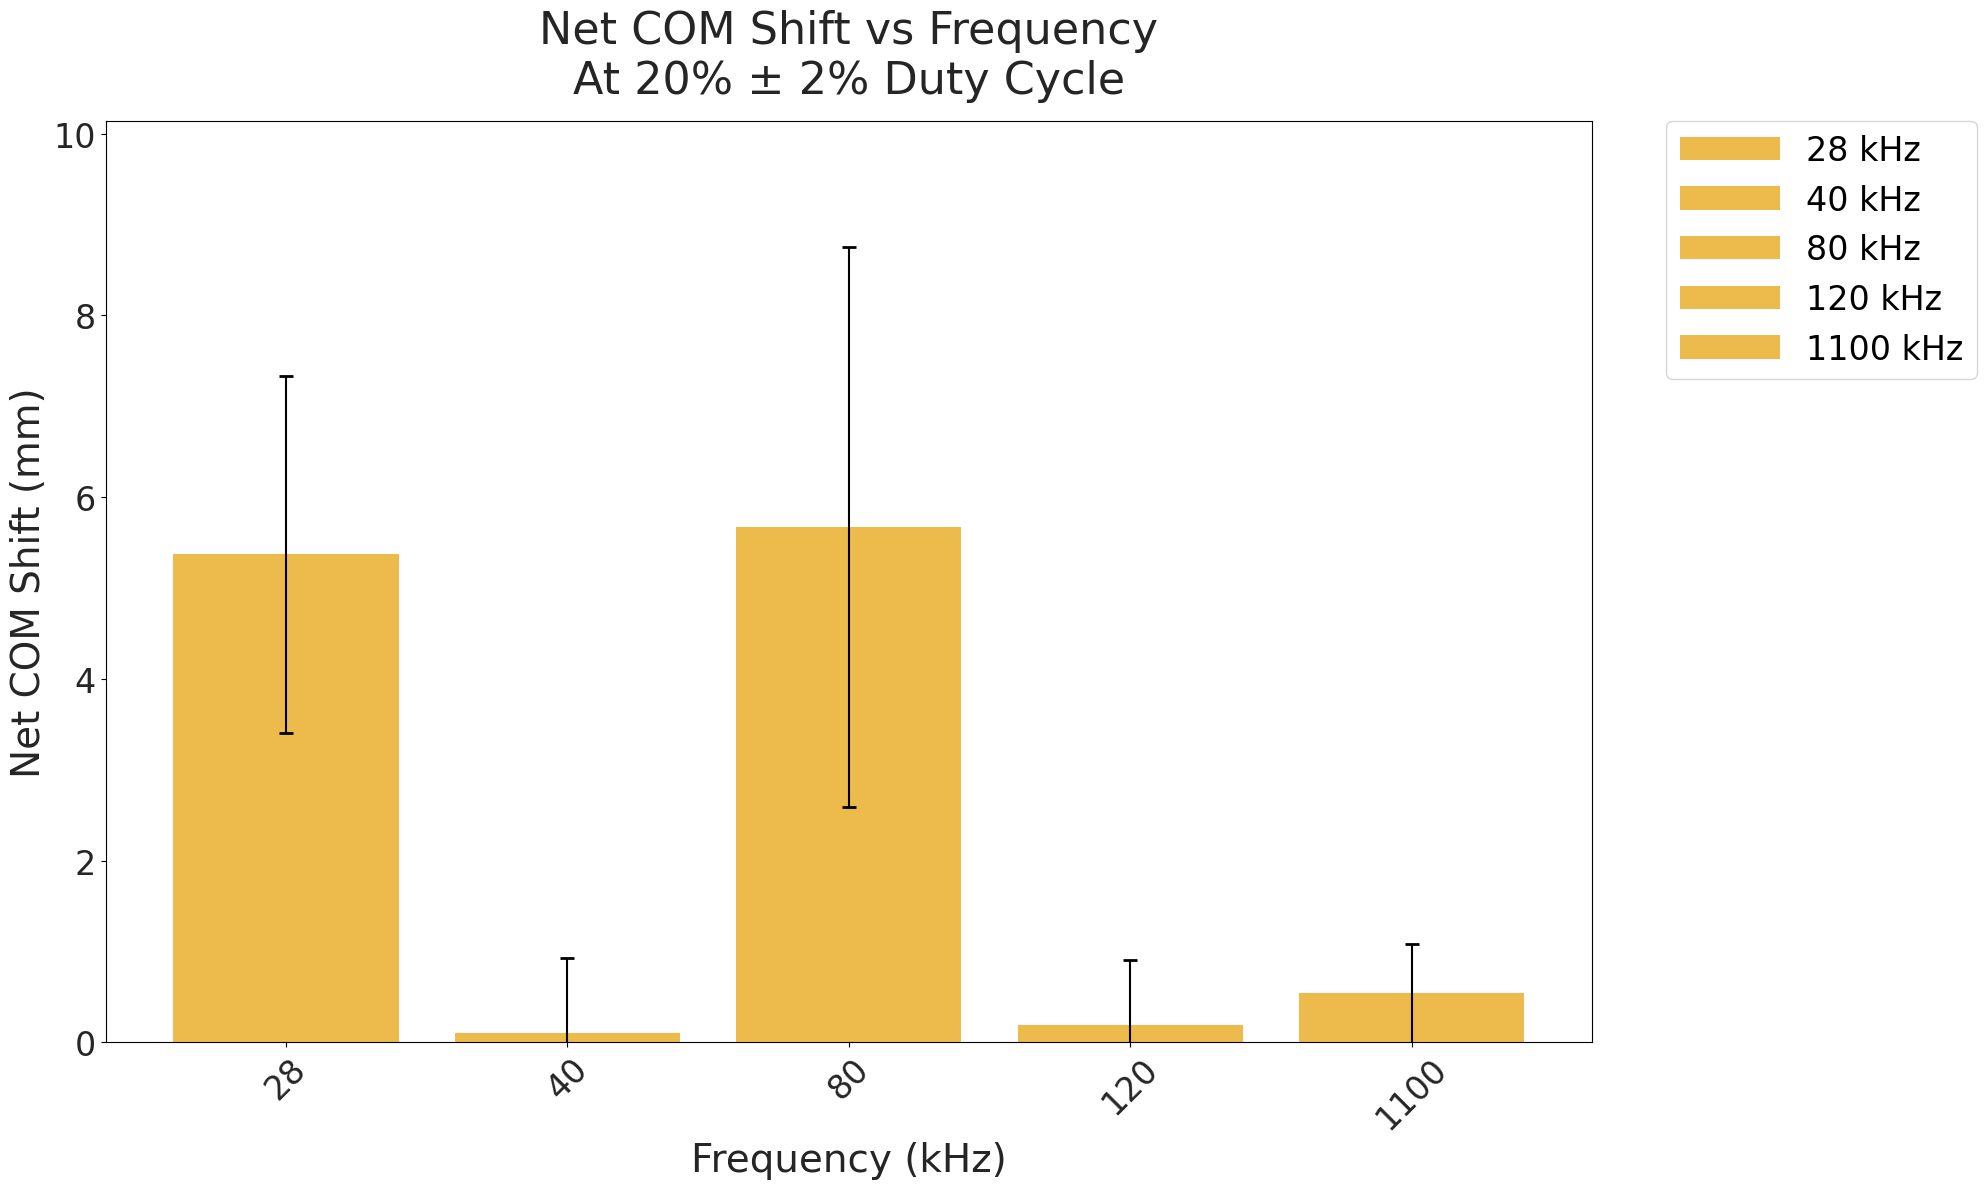

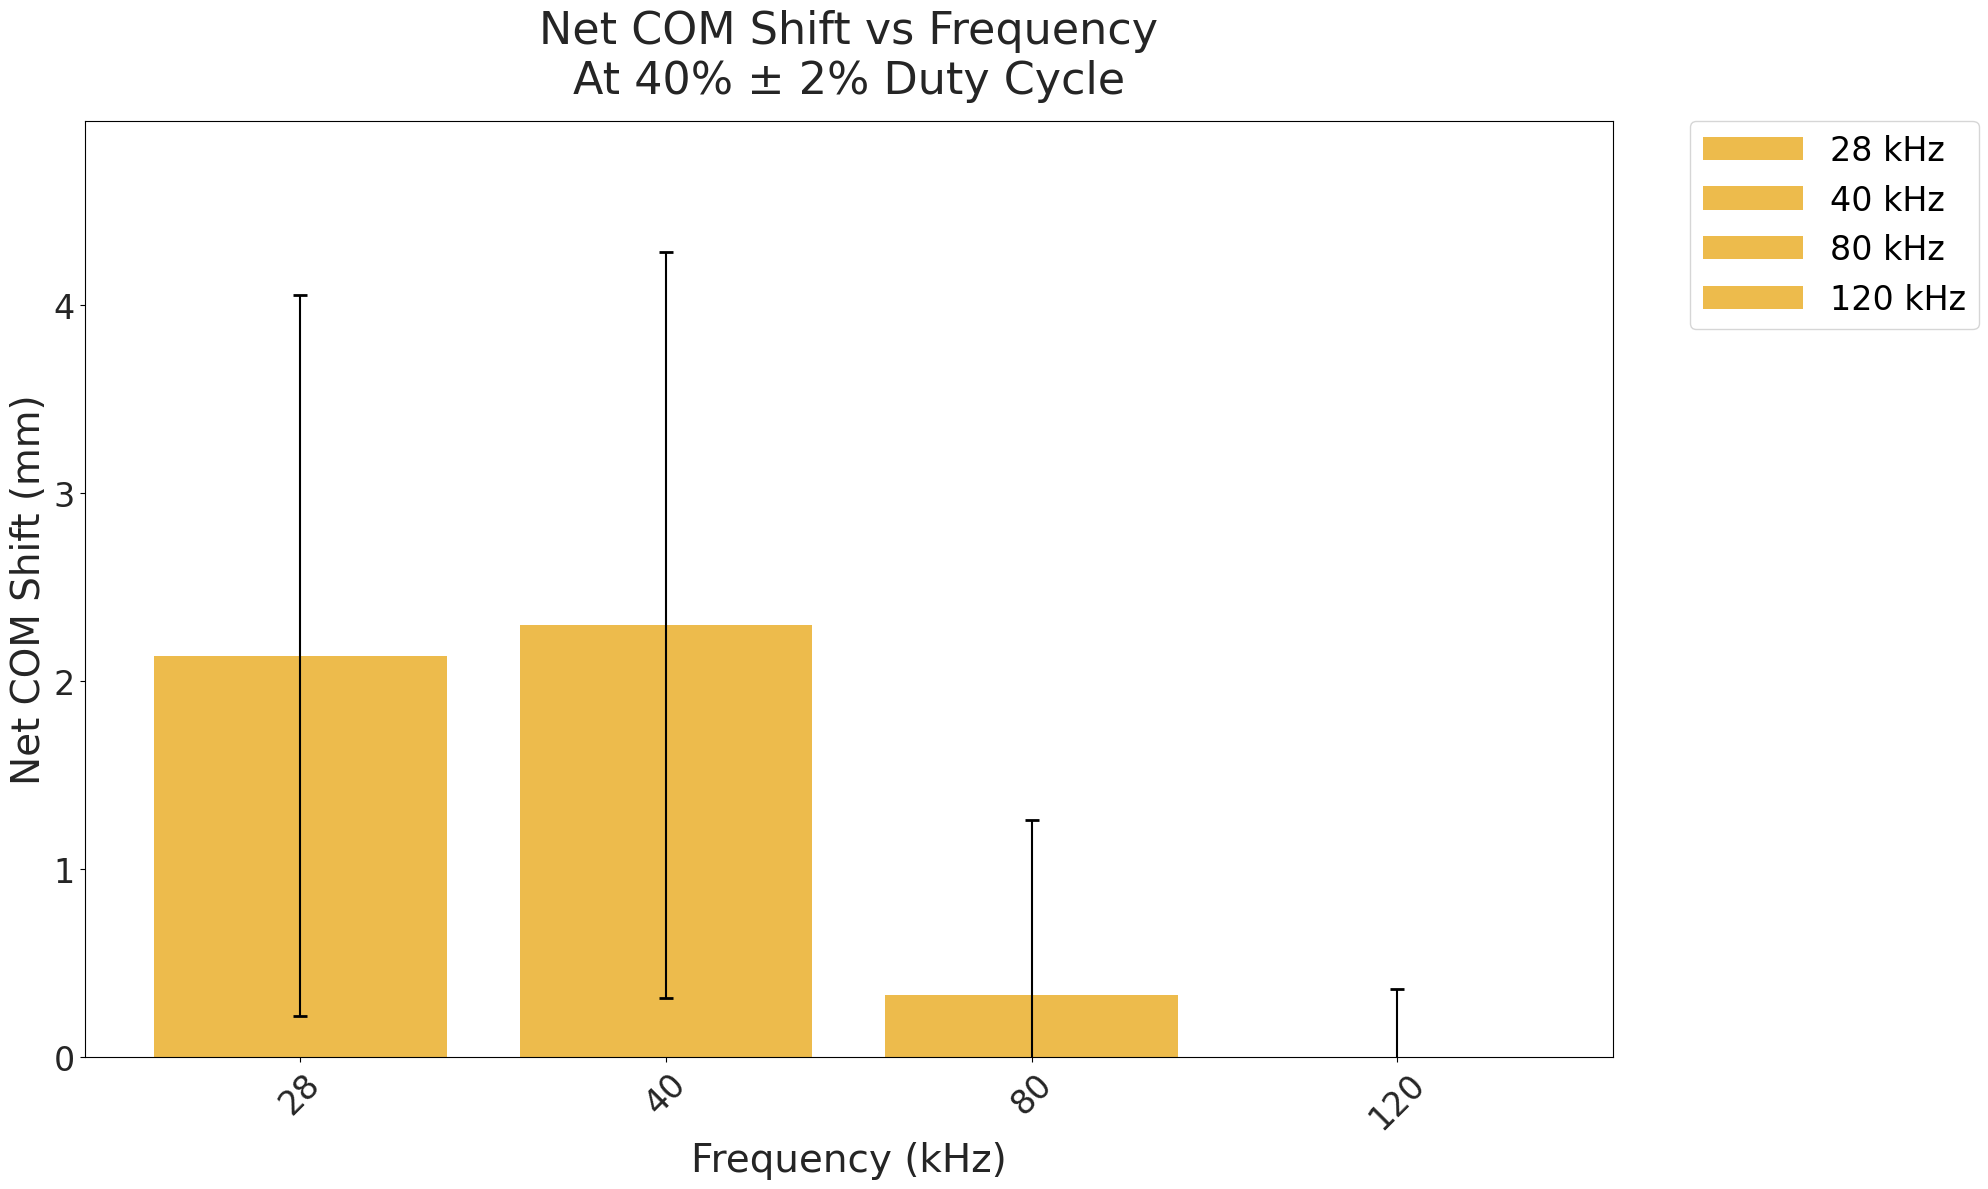

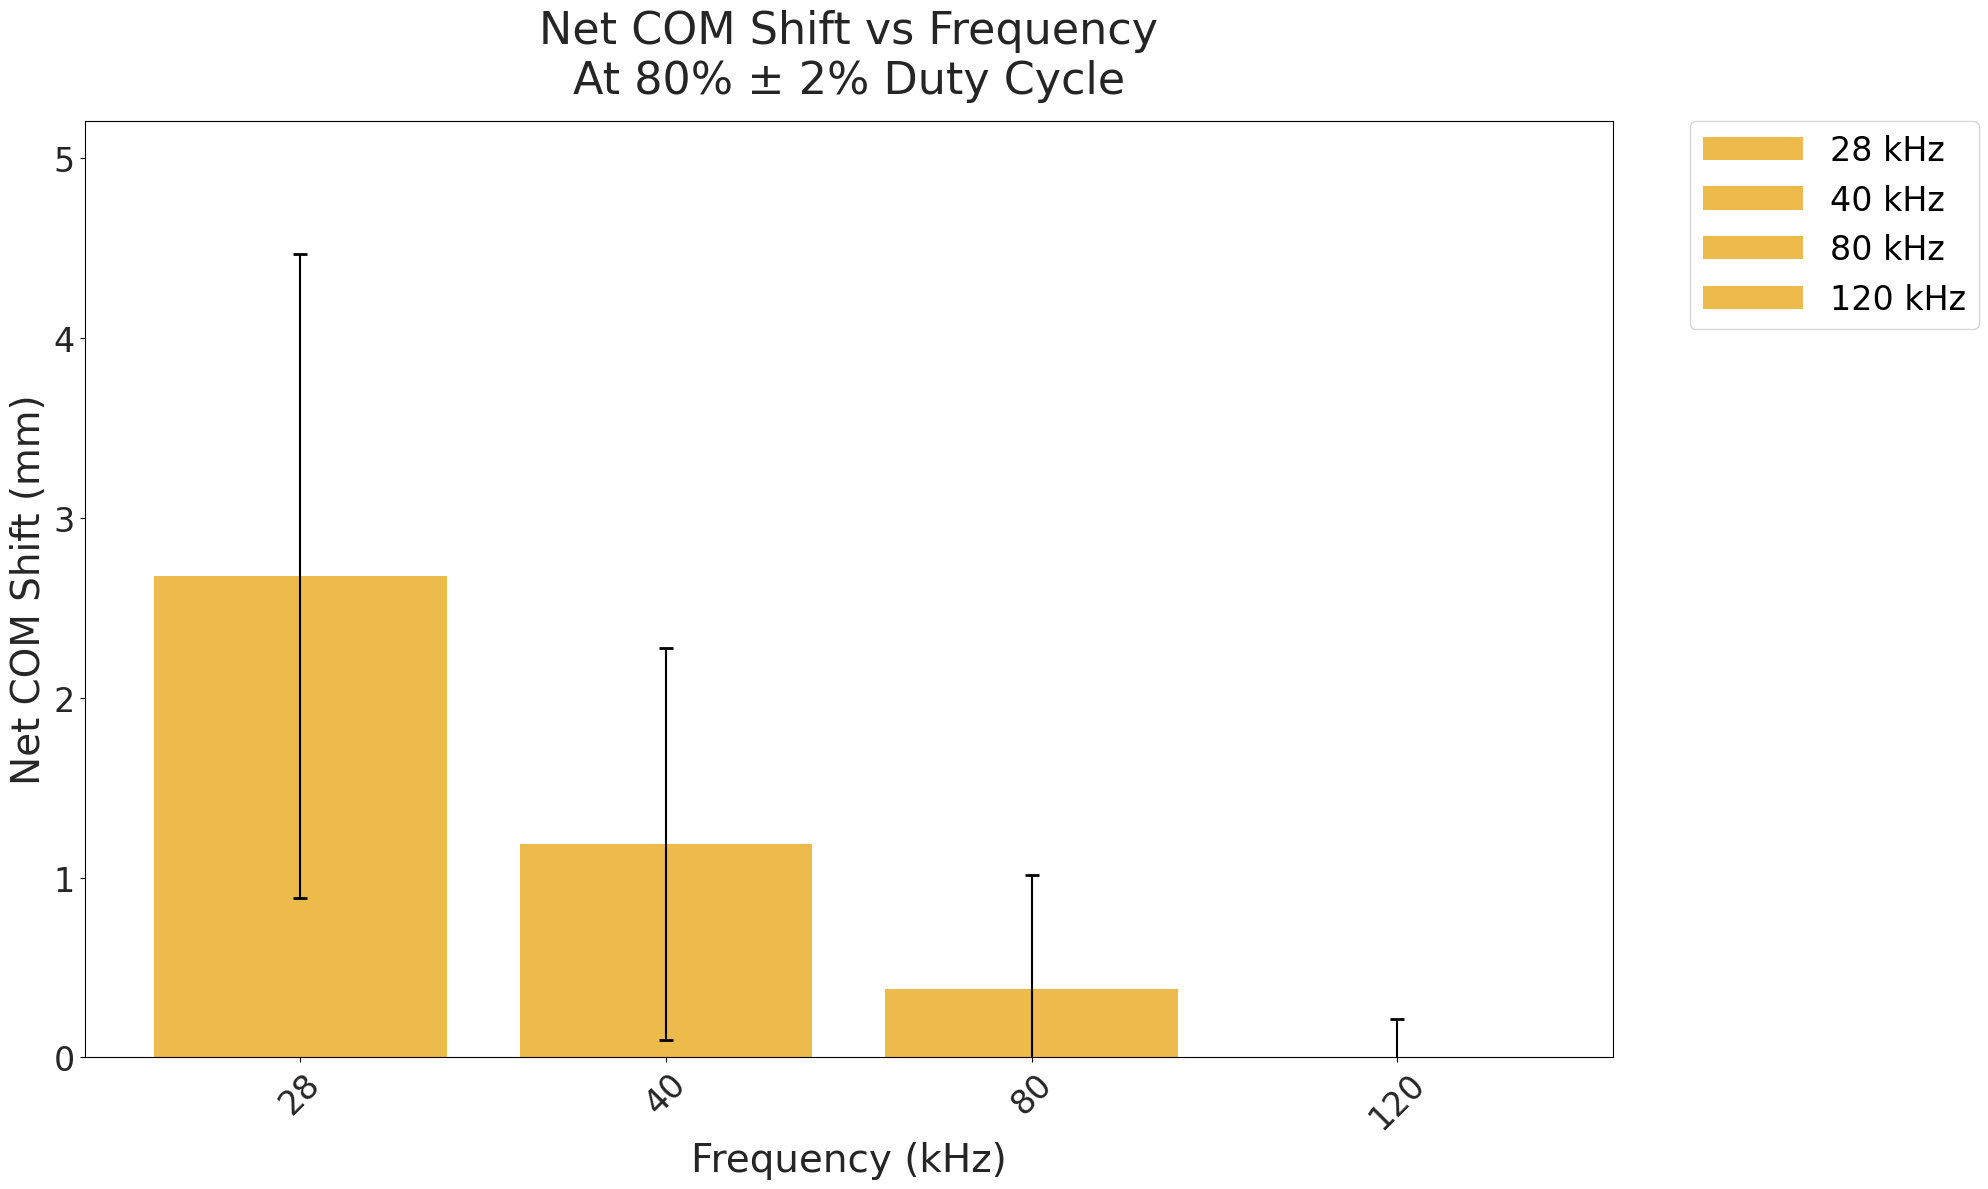


All plots generated successfully!


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.colors as mcolors

class DataProcessor:
    def __init__(self, df):
        self.df = df
        self.data_type = self.determine_data_type()
        self.x_values = self.get_sorted_x_values()
        self.treatment_map = self.create_treatment_map()
        self.has_required_metrics = self.check_required_metrics()

    def determine_data_type(self):
        """Determine the type of data based on column names and values"""
        if 'Time (min)' in self.df.columns:
            return 'time'
        elif 'Cycles' in self.df.columns:
            return 'cycles'
        
        treatments = self.df['Treatment'].astype(str)
        if any('mvpp' in t.lower() for t in treatments):
            return 'voltage'
        elif any('min' in t.lower() for t in treatments):
            return 'time'
        elif any(t.lower().endswith('c') for t in treatments):
            return 'cycles'
        elif any('ml' in t.lower() or 'μl' in t.lower() for t in treatments):
            return 'volume'
        return 'unknown'

    def check_required_metrics(self):
        required_metrics = {
            'voltage': ['Treatment', 'Interface Distance from Edge (mm)_Mean'],
            'time': ['Treatment', 'Interface Distance from Edge (mm)_Mean'],
            'cycles': ['Treatment', 'Interface Distance from Edge (mm)_Mean'],
            'volume': ['Treatment', 'Interface Distance from Edge (mm)_Mean']
        }
        
        if self.data_type in required_metrics:
            return all(metric in self.df.columns for metric in required_metrics[self.data_type])
        return False

    def get_sorted_x_values(self):
        """Get sorted x values based on data type"""
        if self.data_type == 'time' and 'Time (min)' in self.df.columns:
            return sorted(self.df['Time (min)'].unique())
            
        if self.data_type == 'cycles' and 'Cycles' in self.df.columns:
            return sorted(self.df['Cycles'].unique())
                
        values = []
        for treatment in self.df['Treatment'].astype(str):
            treatment = treatment.lower()
            
            if self.data_type == 'voltage' and 'mvpp' in treatment:
                value = int(treatment.split('mvpp')[0])
                values.append(value)
            elif self.data_type == 'time' and 'min' in treatment:
                value = float(treatment.split('min')[0])
                values.append(value)
            elif self.data_type == 'cycles':
                if treatment.endswith('c'):
                    value = int(treatment[:-1])
                    values.append(value)
                elif 'cycle' in treatment:
                    value = int(treatment.split('cycle')[0])
                    values.append(value)
            elif self.data_type == 'volume':
                if 'ml' in treatment:
                    value = float(treatment.split('ml')[0])
                    values.append(value)
                elif 'μl' in treatment:
                    value = float(treatment.split('μl')[0]) / 1000
                    values.append(value)
            else:
                try:
                    values.append(float(treatment))
                except ValueError:
                    values.append(treatment)
        
        return sorted(list(set(values)))

    def create_treatment_map(self):
        """Create a mapping between x_values and treatment strings"""
        treatment_map = {}
        for x_value in self.x_values:
            if self.data_type == 'time':
                matching_row = self.df[self.df['Time (min)'] == x_value].iloc[0]
                treatment_map[x_value] = matching_row['Treatment']
            else:
                treatment_map[x_value] = self.get_treatment_value(x_value)
        return treatment_map

    def get_treatment_value(self, x_value):
        """Convert x_value to appropriate treatment string based on data type"""
        if self.data_type == 'voltage':
            return f"{int(x_value)}mVpp"
        elif self.data_type == 'time':
            return f"{x_value}min"
        elif self.data_type == 'cycles':
            return f"{int(x_value)}C"
        elif self.data_type == 'volume':
            return f"{x_value}mL"
        return str(x_value)

    def get_x_label(self):
        """Get appropriate x-axis label based on data type"""
        if self.data_type == 'voltage':
            return 'Voltage (mVpp)'
        elif self.data_type == 'time':
            return 'Time (min)'
        elif self.data_type == 'cycles':
            return 'Number of Cycles'
        elif self.data_type == 'volume':
            return 'Volume (mL)'
        return 'Treatment'

class MetricsPlotter:
    def __init__(self, df, save_dir=None, save_plots=False):
        self.processor = DataProcessor(df)
        self.df = df
        self.save_dir = save_dir
        self.save_plots = save_plots
        self.colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', '#000000']
        self.markers = ['o', 's', '^', 'D', 'v', 'p', 'h', '8', '*', '+', 'x']
        self.thresholds = [75, 50, 25, 10]
        
    def _save_plot(self, filename):
        """Save plot if requested, otherwise display it"""
        if self.save_plots and self.save_dir:
            plots_dir = os.path.join(self.save_dir, 'Analysis_Metrics', 'Plots')
            os.makedirs(plots_dir, exist_ok=True)
            save_path = os.path.join(plots_dir, f'{filename}.png')
            print(f"Saving plot to: {save_path}")
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        else:
            plt.show()
        plt.close()

    def _format_plot(self, title, xlabel, ylabel):
        """Common plot formatting"""
        plt.title(title, fontsize=32, color='#252525', pad=20)
        plt.xlabel(xlabel, fontsize=28, color='#252525')
        plt.ylabel(ylabel, fontsize=28, color='#252525')
        plt.xticks(fontsize=24, color='#252525')
        plt.yticks(fontsize=24, color='#252525')
        ymin, ymax = plt.ylim()
        plt.ylim(bottom=0, top=ymax*1.1)
        
        # Only add legend if there are labeled elements
        handles, labels = plt.gca().get_legend_handles_labels()
        if handles:
            legend = plt.legend(fontsize=24, 
                              frameon=True,
                              bbox_to_anchor=(1.05, 1),
                              loc='upper left',
                              borderaxespad=0,
                              markerscale=2,
                              handlelength=3)
            
        # Adjust layout to prevent cutoff
        plt.gcf().set_size_inches(20, 12)  # Make figure larger
        plt.tight_layout()

    def plot_interface_intensity_vs_metric(self):
        """Plot interface intensity vs parameter (time or frequency/cycles)"""
        plt.figure(figsize=(16, 10))
        
        if 'Time (min)' in self.df.columns:
            x_values = sorted(self.df['Time (min)'].unique())
            x_label = 'Time (min)'
            title_param = 'Time'
        else:
            x_values = sorted(self.df['Treatment'].unique())
            x_label = 'Treatment'
            title_param = 'Treatment'
        
        intensities = []
        errors = []
        
        for x_val in x_values:
            if 'Time (min)' in self.df.columns:
                matching_data = self.df[self.df['Time (min)'] == x_val]
            else:
                matching_data = self.df[self.df['Treatment'] == x_val]
                
            if not matching_data.empty:
                row = matching_data.iloc[0]
                if 'Interface Intensity_Mean' in row:
                    intensities.append(row['Interface Intensity_Mean'])
                    errors.append(row['Interface Intensity_StdDev'] if 'Interface Intensity_StdDev' in row else 0)
        
        if intensities:
            plt.bar(range(len(x_values)), intensities,
                   color=self.colors[0], alpha=0.7,
                   label='Interface Intensity')
            
            plt.errorbar(range(len(x_values)), intensities, yerr=errors,
                       fmt='none', capsize=5, color='#252525', 
                       alpha=0.7, linewidth=2)
            
            plt.xticks(range(len(x_values)), [f"{x}" for x in x_values], rotation=45)
            
            self._format_plot(
                f'Interface Intensity vs {title_param}',
                x_label,
                'Interface Intensity (a.u.)'
            )
            
            self._save_plot(f'Interface_Intensity_vs_{title_param}')

    def plot_interface_distance(self):
        """Plot interface distance"""
        plt.figure(figsize=(16, 10))
        
        col = 'Interface Distance from Edge (mm)_Mean'
        std_col = 'Interface Distance from Edge (mm)_StdDev'
        
        if 'Time (min)' in self.df.columns:
            x_values = sorted(self.df['Time (min)'].unique())
            x_label = 'Time (min)'
            title_param = 'Time'
        else:
            x_values = sorted(self.df['Treatment'].unique())
            x_label = 'Treatment'
            title_param = 'Treatment'
        
        values = []
        errors = []
        
        for x_val in x_values:
            if 'Time (min)' in self.df.columns:
                matching_data = self.df[self.df['Time (min)'] == x_val]
            else:
                matching_data = self.df[self.df['Treatment'] == x_val]
                
            if not matching_data.empty and col in matching_data.columns:
                row = matching_data.iloc[0]
                if pd.notna(row[col]):
                    values.append(row[col])
                    errors.append(row[std_col] if std_col in matching_data.columns else 0)
        
        if values:
            plt.bar(range(len(x_values)), values,
                   color='purple', alpha=0.7,
                   label='Interface Distance')
            
            plt.errorbar(range(len(x_values)), values, yerr=errors,
                       fmt='none', capsize=5, color='#252525', alpha=0.7, linewidth=2)
            
            plt.xticks(range(len(x_values)), [f"{x}" for x in x_values], rotation=45)
            
            self._format_plot(
                f'Interface Distance from Edge vs {title_param}',
                x_label,
                'Interface Distance from Edge (mm)'
            )
            
            self._save_plot(f'Interface_Distance_{title_param}')

    def plot_com_shifts_by_duty_cycle(self):
        """For each duty cycle bin, plot COM shifts across different frequencies"""
        if not self.processor.has_required_metrics:
            print("Required metrics not found for COM shift plots")
            return
                
        df = self.df.copy()
        
        # Calculate duty cycle for each non-control treatment
        df['Duty_Cycle'] = df.apply(lambda row: 
            calculate_duty_cycle(row['Frequency (kHz)'], row['Cycles']) 
            if row['Treatment'] != 'Control' else 0, axis=1)
        df['Duty_Cycle_Pct'] = (df['Duty_Cycle'] * 100).round(1)
        
        # Create duty cycle bins (centered at 10%, 20%, etc with ±2% range)
        def assign_duty_cycle_bin(dc):
            if dc == 0:
                return 0
            for center in [10, 20, 40, 80]:  # Target duty cycle centers
                if center - 2 <= dc <= center + 2:
                    return center
            return None
        
        df['Duty_Cycle_Bin'] = df['Duty_Cycle_Pct'].apply(assign_duty_cycle_bin)
        
        # Extract frequency from treatment
        df['Frequency'] = df['Treatment'].apply(
            lambda x: float(x.split('kHz')[0]) if 'kHz' in x 
            else float(x.split('MHz')[0])*1000 if 'MHz' in x
            else 0 if 'Control' in x else None
        )
        
        # For each unique duty cycle bin
        for duty_cycle_bin in sorted(df['Duty_Cycle_Bin'].unique()):
            if duty_cycle_bin == 0 or duty_cycle_bin is None:  # Skip control and unmatched
                continue
                
            # Get data for this duty cycle bin
            dc_data = df[df['Duty_Cycle_Bin'] == duty_cycle_bin].copy()
            plt.figure(figsize=(16, 10))
            
            # Group by frequency and calculate mean and std
            freq_groups = dc_data.groupby('Frequency')
            frequencies = sorted(dc_data['Frequency'].unique())
            
            for idx, freq in enumerate(frequencies):
                freq_data = freq_groups.get_group(freq)
                
                if 'COM_Position_Net_Shift' in freq_data.columns:
                    mean_shift = freq_data['COM_Position_Net_Shift'].mean()
                    error = freq_data['COM_Position_Net_Shift_StdDev'].iloc[0]  # Use the StdDev directly from Excel
                    
                    plt.bar(idx, 
                           mean_shift,
                           color=self.colors[0],
                           alpha=0.7,
                           label=f"{freq:.0f} kHz")
                    
                    # Add error bars using the Excel StdDev values
                    plt.errorbar(idx, 
                               mean_shift,
                               yerr=error,
                               fmt='none', 
                               color='black',
                               capsize=5,
                               capthick=2)
            
            # Format x-axis
            plt.xticks(range(len(frequencies)), 
                      [f"{f:.0f}" for f in frequencies],
                      rotation=45)
            
            self._format_plot(
                f'Net COM Shift vs Frequency\nAt {duty_cycle_bin}% ± 2% Duty Cycle',
                'Frequency (kHz)',
                'Net COM Shift (mm)'
            )
            
            self._save_plot(f'COM_Shift_vs_Frequency_at_{duty_cycle_bin}pct_DC')
            plt.close()

    def plot_intensity_bars(self):
        """Plot penetration depth bars grouped by frequency"""
        # Group treatments by frequency
        df_grouped = self.df.copy()
        df_grouped['Frequency'] = df_grouped['Treatment'].apply(
            lambda x: float(x.split('kHz')[0]) if 'kHz' in x 
            else float(x.split('MHz')[0])*1000 if 'MHz' in x
            else 0 if 'Control' in x else None
        )
        frequencies = sorted(df_grouped['Frequency'].unique())
        
        # Create separate plots for each frequency
        for freq in frequencies:
            if freq == 0:  # Skip control
                continue
                
            plt.figure(figsize=(20, 12))
            freq_data = df_grouped[df_grouped['Frequency'] == freq]
            treatments = sorted(freq_data['Treatment'].unique())
            
            # Adjust spacing
            bar_width = 0.15
            threshold_spacing = 2.5
            threshold_positions = np.arange(len(self.thresholds)) * threshold_spacing
            
            # Calculate total width needed for all bars in a group
            total_group_width = bar_width * len(treatments)
            start_offset = -total_group_width / 2
            
            for treat_idx, treatment in enumerate(treatments):
                depths = []
                errors = []
                
                # Calculate duty cycle for this treatment
                if 'kHz' in treatment:
                    freq_val = float(treatment.split('kHz')[0])
                    cycles = int(treatment.split('_')[1].replace('C', ''))
                elif 'MHz' in treatment:
                    freq_val = float(treatment.split('MHz')[0]) * 1000  # Convert to kHz
                    cycles = int(treatment.split('_')[1].replace('C', ''))
                else:
                    continue
                
                duty_cycle = calculate_duty_cycle(freq_val, cycles)
                duty_cycle_percent = duty_cycle * 100  # Convert to percentage
                
                for threshold in self.thresholds:
                    col = f'{threshold}% Interface Penetration Depth from Interface (mm)_Mean'
                    std_col = f'{threshold}% Interface Penetration Depth from Interface (mm)_StdDev'
                    
                    matching_data = df_grouped[df_grouped['Treatment'] == treatment]
                    
                    if not matching_data.empty:
                        row = matching_data.iloc[0]
                        if col in row.index and pd.notna(row[col]):
                            depths.append(row[col])
                            errors.append(row[std_col] if std_col in row.index else 0)
                        else:
                            depths.append(0)
                            errors.append(0)
                
                # Calculate position for each bar
                bar_positions = threshold_positions + start_offset + (treat_idx * bar_width)
                
                plt.bar(bar_positions, depths, bar_width,
                       label=f'Duty Cycle: {duty_cycle_percent:.1f}%',
                       color=self.colors[treat_idx % len(self.colors)],
                       alpha=0.7)
                
                plt.errorbar(bar_positions, depths, yerr=errors,
                            fmt='none', capsize=5, color='#252525', alpha=0.5)
            
            plt.xticks(threshold_positions, [f'{t}%' for t in self.thresholds])
            freq_label = f"{freq:.0f} kHz" if freq < 1000 else f"{freq/1000:.1f} MHz"
            
            self._format_plot(
                f'Interface Penetration Depth at Threshold Points\n{freq_label}',
                'Interface Intensity Threshold (%)',
                'Interface Penetration Depth from Interface (mm)'
            )
            
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                      fontsize=24, frameon=True)
            
            self._save_plot(f'Penetration_Depth_Thresholds_{freq_label.replace(" ", "_")}')
            plt.close()

    def plot_com_shifts_with_duty_cycle(self):
        """Plot COM shifts as bar charts by frequency"""
        if not self.processor.has_required_metrics:
            print("Required metrics not found for COM shift plots")
            return
                
        df = self.df.copy()
        
        # Calculate duty cycle for each non-control treatment
        df['Duty_Cycle'] = df.apply(lambda row: 
            calculate_duty_cycle(row['Frequency (kHz)'], row['Cycles']) 
            if row['Treatment'] != 'Control' else 0, axis=1)
        
        # Extract frequency from treatment for grouping
        df['Frequency'] = df['Treatment'].apply(
            lambda x: float(x.split('kHz')[0]) if 'kHz' in x 
            else float(x.split('MHz')[0])*1000 if 'MHz' in x
            else 0 if 'Control' in x else None
        )
        
        # Metrics to plot
        metrics = {
            'COM_Position_Net_Shift': 'Net COM Shift (mm)',
            'COM_Position_Mean': 'COM Position (mm)',
            'Interface Distance from Edge (mm)_Mean': 'Interface Distance (mm)'
        }
        
        for metric_name, metric_label in metrics.items():
            if metric_name in df.columns:
                # Create separate plots for each frequency
                for freq in sorted(df['Frequency'].unique()):
                    if freq == 0:  # Skip control
                        continue
                        
                    freq_data = df[df['Frequency'] == freq].copy()
                    plt.figure(figsize=(16, 10))
                    
                    # Sort treatments by duty cycle
                    freq_data['Duty_Cycle_Pct'] = freq_data['Duty_Cycle'] * 100
                    freq_data = freq_data.sort_values('Duty_Cycle')
                    
                    # Create bar plot for each treatment with proper legend label
                    for idx, (_, row) in enumerate(freq_data.iterrows()):
                        plt.bar(idx, 
                               row[metric_name],
                               color=self.colors[0],
                               alpha=0.7,
                               label=row['Treatment'])  # Add treatment as label
                    
                    # Add error bars - checking for specific stddev column names
                    std_col = None
                    if metric_name == 'COM_Position_Mean':
                        std_col = 'COM_Position_StdDev'
                    elif metric_name == 'COM_Position_Net_Shift':
                        std_col = 'COM_Position_Net_Shift_StdDev'
                    elif metric_name == 'Interface Distance from Edge (mm)_Mean':
                        std_col = 'Interface Distance from Edge (mm)_StdDev'
                    
                    if std_col and std_col in freq_data.columns:
                        plt.errorbar(range(len(freq_data)), 
                                   freq_data[metric_name],
                                   yerr=freq_data[std_col],
                                   fmt='none', 
                                   color='black',
                                   capsize=5,
                                   capthick=2)
                    
                    # Add duty cycle labels to x-axis
                    plt.xticks(range(len(freq_data)), 
                              [f'{dc:.1f}%' for dc in freq_data['Duty_Cycle_Pct']],
                              rotation=45)
                    
                    freq_label = f"{freq:.0f} kHz" if freq < 1000 else f"{freq/1000:.1f} MHz"
                    
                    self._format_plot(
                        f'{metric_label} vs Duty Cycle\n{freq_label}',
                        'Duty Cycle',
                        metric_label
                    )
                    
                    self._save_plot(f'{metric_name}_vs_DutyCycle_{freq_label.replace(" ", "_")}')
                    plt.close()

    def plot_com_shifts_grouped_by_duty_cycle(self):
        """Plot COM shifts with similar duty cycles grouped together"""
        if not self.processor.has_required_metrics:
            print("Required metrics not found for COM shift plots")
            return
                
        df = self.df.copy()
        
        # Calculate duty cycle for each non-control treatment
        df['Duty_Cycle'] = df.apply(lambda row: 
            calculate_duty_cycle(row['Frequency (kHz)'], row['Cycles']) 
            if row['Treatment'] != 'Control' else 0, axis=1)
        
        # Convert to percentage and round to nearest 10
        df['Duty_Cycle_Group'] = (df['Duty_Cycle'] * 100).round().apply(lambda x: round(x/10) * 10)
        
        # Extract frequency from treatment for grouping
        df['Frequency'] = df['Treatment'].apply(
            lambda x: float(x.split('kHz')[0]) if 'kHz' in x 
            else float(x.split('MHz')[0])*1000 if 'MHz' in x
            else 0 if 'Control' in x else None
        )
        
        # Metrics to plot
        metrics = {
            'COM_Position_Net_Shift': 'Net COM Shift (mm)',
        }
        
        for metric_name, metric_label in metrics.items():
            if metric_name in df.columns:
                # Group by duty cycle
                grouped_data = df.groupby('Duty_Cycle_Group')
                
                plt.figure(figsize=(16, 10))
                
                # Calculate positions for bars
                unique_duty_cycles = sorted(df['Duty_Cycle_Group'].unique())
                
                # Plot bars for each duty cycle group
                for idx, duty_cycle in enumerate(unique_duty_cycles):
                    if duty_cycle == 0:  # Skip control
                        continue
                        
                    group_data = df[df['Duty_Cycle_Group'] == duty_cycle]
                    
                    # Calculate mean and standard error for the group
                    mean_value = group_data[metric_name].mean()
                    std_error = group_data[metric_name].std() / np.sqrt(len(group_data))
                    
                    plt.bar(idx, 
                           mean_value,
                           color=self.colors[0],
                           alpha=0.7,
                           label=f'{duty_cycle}% DC')
                    
                    # Add error bars
                    plt.errorbar(idx, 
                               mean_value,
                               yerr=std_error,
                               fmt='none', 
                               color='black',
                               capsize=5,
                               capthick=2)
                    
                    # Add hover text with treatments
                    treatments = group_data['Treatment'].tolist()
                    plt.text(idx, 
                            0,  # Place at bottom of plot
                            '\n'.join(treatments),
                            rotation=45,
                            ha='right',
                            va='top',
                            fontsize=8)
                
                # Set x-ticks
                plt.xticks(range(len(unique_duty_cycles)-1),  # -1 to account for skipped control
                          [f'{dc}%' for dc in unique_duty_cycles if dc != 0],
                          rotation=45)
                
                self._format_plot(
                    f'{metric_label} vs Grouped Duty Cycles',
                    'Duty Cycle Groups',
                    metric_label
                )
                
                self._save_plot(f'{metric_name}_vs_Grouped_DutyCycles')
                plt.close()


        if not self.processor.has_required_metrics:
            print("Required metrics not found for COM shift plots")
            return
                
        df = self.df.copy()
        
        # Calculate duty cycle for each non-control treatment
        df['Duty_Cycle'] = df.apply(lambda row: 
            calculate_duty_cycle(row['Frequency (kHz)'], row['Cycles']) 
            if row['Treatment'] != 'Control' else 0, axis=1)
        
        # Extract frequency from treatment for grouping
        df['Frequency'] = df['Treatment'].apply(
            lambda x: float(x.split('kHz')[0]) if 'kHz' in x 
            else float(x.split('MHz')[0])*1000 if 'MHz' in x
            else 0 if 'Control' in x else None
        )
        
        # Metrics to plot
        metrics = {
            'COM_Position_Net_Shift': 'Net COM Shift (mm)',
            'COM_Position_Mean': 'COM Position (mm)',
            'Interface Distance from Edge (mm)_Mean': 'Interface Distance (mm)'
        }
        
        for metric_name, metric_label in metrics.items():
            if metric_name in df.columns:
                # Create separate plots for each frequency
                for freq in sorted(df['Frequency'].unique()):
                    if freq == 0:  # Skip control
                        continue
                        
                    freq_data = df[df['Frequency'] == freq].copy()
                    plt.figure(figsize=(16, 10))
                    
                    # Sort treatments by duty cycle
                    freq_data['Duty_Cycle_Pct'] = freq_data['Duty_Cycle'] * 100
                    freq_data = freq_data.sort_values('Duty_Cycle')
                    
                    # Create bar plot for each treatment with proper legend label
                    for idx, (_, row) in enumerate(freq_data.iterrows()):
                        plt.bar(idx, 
                               row[metric_name],
                               color=self.colors[0],
                               alpha=0.7,
                               label=row['Treatment'])  # Add treatment as label
                    
                    # Add error bars - checking for specific stddev column names
                    std_col = None
                    if metric_name == 'COM_Position_Mean':
                        std_col = 'COM_Position_StdDev'
                    elif metric_name == 'COM_Position_Net_Shift':
                        std_col = 'COM_Position_Net_Shift_StdDev'
                    elif metric_name == 'Interface Distance from Edge (mm)_Mean':
                        std_col = 'Interface Distance from Edge (mm)_StdDev'
                    
                    if std_col and std_col in freq_data.columns:
                        plt.errorbar(range(len(freq_data)), 
                                   freq_data[metric_name],
                                   yerr=freq_data[std_col],
                                   fmt='none', 
                                   color='black',
                                   capsize=5,
                                   capthick=2)
                    
                    # Add duty cycle labels to x-axis
                    plt.xticks(range(len(freq_data)), 
                              [f'{dc:.1f}%' for dc in freq_data['Duty_Cycle_Pct']],
                              rotation=45)
                    
                    freq_label = f"{freq:.0f} kHz" if freq < 1000 else f"{freq/1000:.1f} MHz"
                    
                    self._format_plot(
                        f'{metric_label} vs Duty Cycle\n{freq_label}',
                        'Duty Cycle',
                        metric_label
                    )
                    self._save_plot(f'{metric_name}_vs_DutyCycle_{freq_label.replace(" ", "_")}')
                    plt.close()

    def plot_penetration_depth_comparison(self):
        """Create a single plot for penetration depth comparison"""
        plt.figure(figsize=(20, 12))
        
        if 'Time (min)' in self.df.columns:
            x_values = sorted(self.df['Time (min)'].unique())
            x_label = 'Time (min)'
            title_param = 'Time'
        else:
            x_values = sorted(self.df['Treatment'].unique())
            x_label = 'Treatment'
            title_param = 'Treatment'
        
        bar_width = 0.25
        threshold_spacing = 1.5
        threshold_positions = np.arange(len(self.thresholds)) * threshold_spacing
        
        for idx, x_val in enumerate(x_values):
            depths = []
            errors = []
            
            for threshold in self.thresholds:
                col = f'{threshold}% Interface Penetration Depth from Interface (mm)_Mean'
                std_col = f'{threshold}% Interface Penetration Depth from Interface (mm)_StdDev'
                
                if 'Time (min)' in self.df.columns:
                    matching_data = self.df[self.df['Time (min)'] == x_val]
                else:
                    matching_data = self.df[self.df['Treatment'] == x_val]
                
                if not matching_data.empty:
                    row = matching_data.iloc[0]
                    if col in row.index and pd.notna(row[col]):
                        depths.append(row[col])
                        errors.append(row[std_col] if std_col in row.index else 0)
                    else:
                        depths.append(0)
                        errors.append(0)
            
            bar_positions = threshold_positions + (idx - len(x_values)/2 + 0.5) * bar_width
            
            plt.bar(bar_positions, depths, bar_width,
                   label=f'{x_val}',
                   color=self.colors[idx % len(self.colors)],
                   alpha=0.7)
            
            plt.errorbar(bar_positions, depths, yerr=errors,
                        fmt='none', capsize=5, color='#252525', alpha=0.5)
        
        plt.xticks(threshold_positions, [f'{t}%' for t in self.thresholds])
        
        self._format_plot(
            f'Penetration Depth vs {title_param}',
            'Interface Intensity Threshold (%)',
            'Penetration Depth (mm)'
        )
        
        if len(x_values) > 6:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                      fontsize=20, frameon=True, ncol=2)
        else:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                      fontsize=24, frameon=True)
        
        self._save_plot(f'Penetration_Depth_{title_param}_Comparison')

def calculate_duty_cycle(frequency_khz, cycles, burst_period_ms=1):
    """Calculate duty cycle for given frequency and cycles within burst period"""
    frequency_hz = frequency_khz * 1000
    burst_period_s = burst_period_ms / 1000
    time_per_cycle = 1 / frequency_hz
    total_cycle_time = time_per_cycle * cycles
    duty_cycle = total_cycle_time / burst_period_s
    return duty_cycle

def plot_analysis_metrics(save_dir, save_plots=False):
    """Plot all analysis metrics"""
    metrics_dir = f"{save_dir}/Analysis_Metrics"
    raw_file = f"{metrics_dir}/Plot_Processor_Analysis_Metrics_Raw.xlsx"
    
    print(f"\nLooking for files:")
    print(f"Raw metrics file: {raw_file}")
    
    if not os.path.exists(raw_file):
        print(f"Error: Could not find raw metrics file at {raw_file}")
        return
    
    try:
        print("\nReading data file...")
        df = pd.read_excel(raw_file, sheet_name='Summary')
        
        print("\nCreating plots...")
        plotter = MetricsPlotter(df, save_dir, save_plots)

        print("\nGenerating interface intensity plots...")
        plotter.plot_interface_intensity_vs_metric()
        
        print("\nGenerating interface distance plots...")
        plotter.plot_interface_distance()
        
        print("\nGenerating penetration depth comparison plots...")
        plotter.plot_penetration_depth_comparison()
        
        print("\nGenerating intensity bar plots...")
        plotter.plot_intensity_bars()
        
        print("\nGenerating COM shift plots by frequency...")
        plotter.plot_com_shifts_with_duty_cycle()
        
        print("\nGenerating COM shift plots by duty cycle...")
        plotter.plot_com_shifts_by_duty_cycle()
        
        print("\nAll plots generated successfully!")

    except Exception as e:
        print(f"\nError during plotting: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    print("\nStarting analysis...")
    plot_analysis_metrics(save_dir, save_plots=False)

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors

def plot_threshold_depths(save_dir, save_plots=False):
    metrics_dir = os.path.join(save_dir, 'Analysis_Metrics')
    raw_file = os.path.join(metrics_dir, 'Plot_Processor_Analysis_Metrics_Raw.xlsx')
    df = pd.read_excel(raw_file, sheet_name='Summary')

    # Define the order of thresholds
    threshold_order = ['75%']
    
    # Define color palettes
    blue_palette = plt.cm.Blues(np.linspace(0.4, 0.8, len(threshold_order)))
    red_palette = plt.cm.Reds(np.linspace(0.4, 0.8, len(threshold_order)))

    for base in ['Interface', 'Peak']:
        plt.figure(figsize=(16, 10))  # Large figure size

        x = range(len(df))
        width = 0.15  # Adjust bar width

        for i, threshold in enumerate(threshold_order):
            depths = df[f'{threshold} {base} Penetration Depth (mm)']
            stds = df[f'{threshold} {base} Penetration Depth (mm) (Std)']
            
            color = blue_palette[i] if base == 'Interface' else red_palette[i]
            
            plt.bar([xi + i*width for xi in x], depths, width, 
                    color=color, label=threshold, align='center')
            plt.errorbar([xi + i*width for xi in x], depths, yerr=stds, 
                         fmt='none', capsize=0, color='#252525', alpha=0.7, linewidth=2)

        plt.title(f'{base} Intensity Penetration Depth vs. Cycles', fontsize=32, color='#252525')
        plt.xlabel('Number of Cycles', fontsize=28, color='#252525')
        plt.ylabel('Penetration Depth (mm)', fontsize=28, color='#252525')
        plt.xticks([xi + (len(threshold_order)-1)*width/2 for xi in x], df['Cycles'], rotation=45, fontsize=24, color='#252525')
        plt.yticks(fontsize=24, color='#252525')
        plt.legend(title='Threshold', fontsize=24, title_fontsize=28)
        
        plt.tight_layout(pad=3.0)

        if save_plots:
            plots_dir = os.path.join(metrics_dir, 'Plots')
            os.makedirs(plots_dir, exist_ok=True)
            plt.savefig(os.path.join(plots_dir, f'{base}_Intensity_Penetration_Depth_Plot.png'), dpi=300, bbox_inches='tight', facecolor='white')

        plt.show()
        plt.close()

# Call the function with your save directory
#save_dir = r"C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Microspheres/Gel scans/21JAN25-retry/merged_analyses"
plot_threshold_depths(save_dir, save_plots=True)

KeyError: '75% Interface Penetration Depth (mm)'

<Figure size 1600x1000 with 0 Axes>

### Averages width, height, and intensity profiles and also normalizes intensity profiles for viewing

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy import interpolate

def combine_replicates(save_dir):
    merged_dir = save_dir
    
    analysis_types = {
        'Analysis_Metrics': {
            'file': 'Merged_Analysis_Metrics.xlsx',
            'error_suffix': ' Error'
        },
        'Width_Profile': {
            'file': 'Merged_Width_Profile.xlsx',
            'value_col': 'Width (mm)',
            'error_col': 'Width Error (mm)',
            'x_col': 'Distance from top (mm)'
        },
        'Height_Profile': {
            'file': 'Merged_Height_Profile.xlsx',
            'value_col': 'Height (mm)',
            'error_col': 'Height Error (mm)',
            'x_col': 'Distance from left (mm)'
        },
        'Average_Intensity_Profile': {
            'file': 'Merged_Average_Intensity_Profile.xlsx',
            'value_col': 'Average Intensity',
            'error_col': 'Intensity Error',
            'x_col': 'Distance from Interface (mm)'
        }
    }

    for analysis_name, config in analysis_types.items():
        print(f"\nProcessing {analysis_name}...")
        file_path = os.path.join(merged_dir, analysis_name, config['file'])
        excel_file = pd.ExcelFile(file_path)
        
        treatment_groups = {}
        for sheet in excel_file.sheet_names:
            treatment = sheet[:-3]
            if treatment not in treatment_groups:
                treatment_groups[treatment] = []
            treatment_groups[treatment].append(sheet)

        # Create two output files for Average Intensity Profile
        if analysis_name == 'Average_Intensity_Profile':
            output_files = {
                'normal': os.path.join(merged_dir, analysis_name, f'Averaged_{config["file"]}'),
                'normalized': os.path.join(merged_dir, analysis_name, f'Averaged_Normalized_{config["file"]}')
            }
        else:
            output_files = {'normal': os.path.join(merged_dir, analysis_name, f'Averaged_{config["file"]}')}

        for output_type, output_file in output_files.items():
            with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
                
                for treatment, sheets in treatment_groups.items():
                    print(f"  Processing treatment: {treatment}")
                    if analysis_name == 'Analysis_Metrics':
                        # Handle Analysis Metrics (unchanged)
                        dfs = [pd.read_excel(file_path, sheet_name=sheet) for sheet in sheets]
                        result_df = pd.DataFrame()
                        result_df['Metric'] = dfs[0]['Metric']
                        
                        values = []
                        stds = []
                        
                        for metric in dfs[0]['Metric']:
                            metric_values = []
                            for df in dfs:
                                if metric in df['Metric'].values:
                                    val = df.loc[df['Metric'] == metric, 'Value'].values[0]
                                    metric_values.append(val)
                            
                            if metric_values:
                                mean_val = np.mean(metric_values)
                                std_val = np.std(metric_values, ddof=0) if len(metric_values) > 1 else 0
                                values.append(mean_val)
                                stds.append(std_val)
                            else:
                                values.append(np.nan)
                                stds.append(np.nan)
                        
                        result_df['Mean'] = values
                        result_df['Population Std Dev'] = stds
                        
                    else:
                        # Handle profile data
                        dfs = [pd.read_excel(file_path, sheet_name=sheet) for sheet in sheets]
                        
                        x_col = config['x_col']
                        value_col = config['value_col']
                        
                        x_min = max(df[x_col].min() for df in dfs)
                        x_max = min(df[x_col].max() for df in dfs)
                        
                        num_points = 500
                        x_common = np.linspace(x_min, x_max, num_points)
                        
                        # Interpolate first for all profile types
                        interpolated_values = []
                        error_values = []  # Store original errors for single replicates
                        
                        for df in dfs:
                            f = interpolate.interp1d(df[x_col], df[value_col])
                            interpolated_values.append(f(x_common))
                            
                            if config.get('error_col') in df.columns:
                                f_error = interpolate.interp1d(df[x_col], df[config['error_col']])
                                error_values.append(f_error(x_common))
                        
                        interpolated_array = np.array(interpolated_values)
                        
                        # Special handling for Average Intensity Profile
                        if analysis_name == 'Average_Intensity_Profile':
                            if output_type == 'normalized':
                                # Normalize each replicate after interpolation
                                normalized_values = [values / np.max(values) for values in interpolated_array]
                                normalized_array = np.array(normalized_values)
                                
                                result_df = pd.DataFrame()
                                result_df[x_col] = x_common
                                result_df['Normalized Average Intensity'] = np.mean(normalized_array, axis=0)
                                
                                # Use original error for single replicate, otherwise calculate std dev
                                if len(normalized_array) == 1 and error_values:
                                    result_df['Population Std Dev'] = error_values[0] / np.max(interpolated_array[0])
                                else:
                                    result_df['Population Std Dev'] = np.std(normalized_array, axis=0, ddof=0)
                            else:
                                # Non-normalized version
                                result_df = pd.DataFrame()
                                result_df[x_col] = x_common
                                result_df[value_col] = np.mean(interpolated_array, axis=0)
                                
                                # Use original error for single replicate, otherwise calculate std dev
                                if len(interpolated_array) == 1 and error_values:
                                    result_df['Population Std Dev'] = error_values[0]
                                else:
                                    result_df['Population Std Dev'] = np.std(interpolated_array, axis=0, ddof=0)
                        else:
                            # Original handling for other profiles
                            mean_values = np.mean(interpolated_array, axis=0)
                            
                            # Use original error for single replicate, otherwise calculate std dev
                            if len(interpolated_array) == 1 and error_values:
                                std_values = error_values[0]
                            else:
                                std_values = np.std(interpolated_array, axis=0, ddof=0)
                            
                            result_df = pd.DataFrame()
                            result_df[x_col] = x_common
                            result_df[value_col] = mean_values
                            result_df['Population Std Dev'] = std_values
                    
                    # Save to new sheet
                    result_df.to_excel(writer, sheet_name=treatment, index=False)
                
            print(f"Created averaged file: {output_file}")

    return "All averaging complete!"

if __name__ == "__main__":
    combine_replicates(save_dir)



### Plot profiles


Starting analysis...
Save directory: C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Microspheres/Gel scans/28JAN25/reanalyzed/Cycle sweep/With sucrose/merged_analyses
Looking for file: Merged_Average_Intensity_Profile.xlsx
Found file at: C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Microspheres/Gel scans/28JAN25/reanalyzed/Cycle sweep/With sucrose/merged_analyses\Average_Intensity_Profile\Merged_Average_Intensity_Profile.xlsx


ValueError: all input arrays must have the same shape

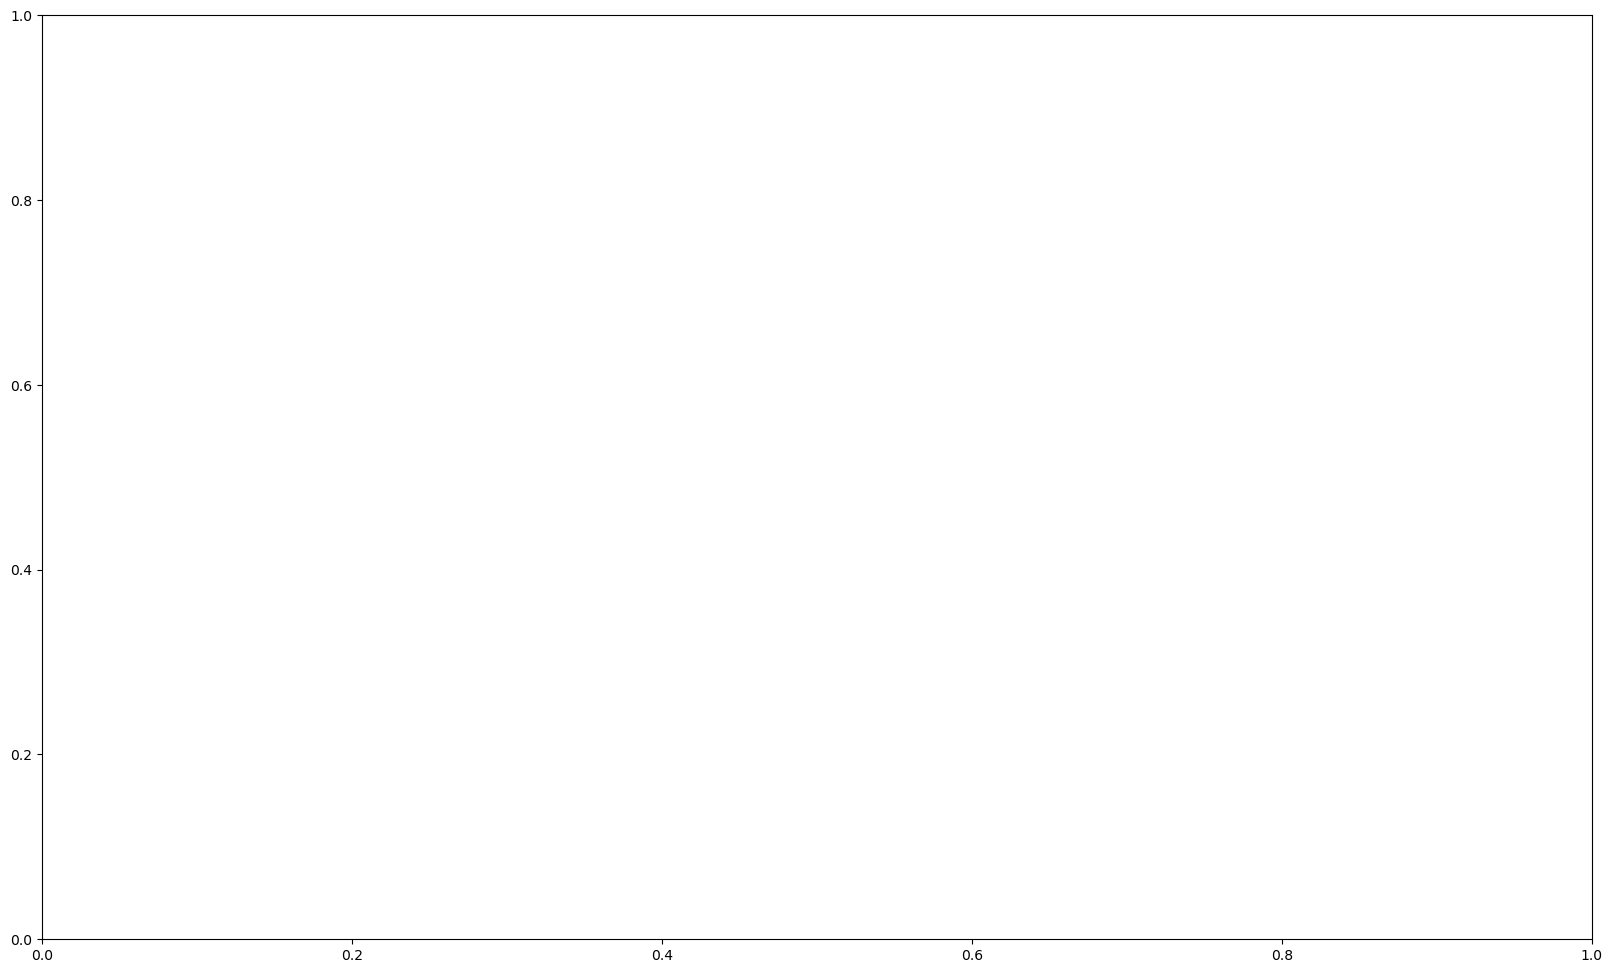

In [31]:
import pandas as pd
import numpy as np
import os
from scipy import interpolate
import matplotlib.pyplot as plt
import re

def find_excel_file(directory, filename):
    """Recursively search for a file in directory and its subdirectories"""
    for root, dirs, files in os.walk(directory):
        if filename in files:
            return os.path.join(root, filename)
    return None

def average_replicates(excel_file):
    """Average the replicate data from different sheets"""
    # Get all sheet names
    sheet_names = excel_file.sheet_names
    
    # Group sheets by base name (removing _R1, _R2, etc.)
    treatment_groups = {}
    for sheet in sheet_names:
        base_name = re.sub(r'_R\d+$', '', sheet)
        if base_name not in treatment_groups:
            treatment_groups[base_name] = []
        treatment_groups[base_name].append(sheet)
    
    # Average each group
    averaged_data = {}
    for base_name, replicate_sheets in treatment_groups.items():
        # Read all replicates
        replicates = [pd.read_excel(excel_file, sheet_name=sheet) for sheet in replicate_sheets]
        
        # Ensure all replicates have the same distance values
        distance = replicates[0]['Distance from Interface (mm)']
        
        # Stack intensity values
        intensities = np.stack([rep['Average Intensity'].values for rep in replicates])
        
        # Calculate mean and population standard deviation
        mean_intensity = np.mean(intensities, axis=0)
        pop_std = np.std(intensities, axis=0, ddof=0)  # ddof=0 for population std dev
        
        # Create averaged dataframe
        averaged_data[base_name] = pd.DataFrame({
            'Distance from Interface (mm)': distance,
            'Average Intensity': mean_intensity,
            'Population Std Dev': pop_std
        })
    
    return averaged_data


def plot_profiles(save_dir, save=False):
    # Normalize path separators
    save_dir = save_dir.replace('\\', '/')
    
    # Recursively search for the Excel file
    excel_filename = 'Merged_Average_Intensity_Profile.xlsx'
    normal_file = find_excel_file(save_dir, excel_filename)
    
    # Debug print to check file paths
    print(f"Looking for file: {excel_filename}")
    print(f"Found file at: {normal_file}")
    
    # Check if file exists
    if not normal_file or not os.path.exists(normal_file):
        print(f"Error: Could not find {excel_filename} in {save_dir} or its subdirectories")
        return
    
    # Create figure with larger size
    fig1, ax1 = plt.subplots(figsize=(20, 12))
    
    colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', '#000000']
    line_width = 3
    
    # Read and average replicates
    excel_file = pd.ExcelFile(normal_file)
    averaged_data = average_replicates(excel_file)
    
    # Sort treatments by cycle number
    treatments = sorted(averaged_data.keys(), 
                      key=lambda x: int(re.search(r'(\d+)C', x).group(1)) if re.search(r'(\d+)C', x) else 0)
    
    for i, treatment in enumerate(treatments):
        df = averaged_data[treatment]
        cycles = re.search(r'(\d+)C', treatment).group(1)
        
        # Plot mean with error bands
        ax1.plot(df['Distance from Interface (mm)'], df['Average Intensity'], 
                label=f'{cycles} cycles', color=colors[i % len(colors)], 
                linewidth=line_width)
        ax1.fill_between(df['Distance from Interface (mm)'],
                        df['Average Intensity'] - df['Intensity Error'],
                        df['Average Intensity'] + df['Intensity Error'],
                        alpha=0.15, color=colors[i % len(colors)])
    
    # Style plot
    ax1.set_title('Average Intensity Profiles', fontsize=32, color='#252525')
    ax1.set_xlabel('Distance from Interface (mm)', fontsize=28, color='#252525')
    ax1.set_ylabel('Average Intensity', fontsize=28, color='#252525')
    ax1.tick_params(axis='both', which='major', labelsize=24, colors='#252525')
    ax1.legend(fontsize=24, frameon=True, bbox_to_anchor=(1.05, 1), 
              loc='upper left', borderaxespad=0,
              markerscale=2, handlelength=3)
    
    ymin, ymax = ax1.get_ylim()
    ax1.set_ylim(bottom=0, top=ymax*1.1)
    fig1.tight_layout()
    
    if save:
        plots_dir = os.path.join(save_dir, 'Analysis_Metrics', 'Plots')
        os.makedirs(plots_dir, exist_ok=True)
        fig1.savefig(os.path.join(plots_dir, 'Average_Intensity_Profiles.png'), 
                     dpi=300, bbox_inches='tight', facecolor='white')
        plt.close('all')
        return "Plot created and saved successfully!"
    else:
        plt.show()
        return "Plot displayed successfully!"

if __name__ == "__main__":
    save_dir = save_dir.replace('\\', '/').rstrip('/')
    
    print("\nStarting analysis...")
    print(f"Save directory: {save_dir}")
    
    # Run the plotting function
    plot_profiles(save_dir, save=False)


if __name__ == "__main__":
    save_dir = save_dir.replace('\\', '/').rstrip('/')
    
    print("\nStarting analysis...")
    print(f"Save directory: {save_dir}")
    
    # Run the plotting function
    plot_profiles(save_dir, save=False)



In [27]:
save_dir

'C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Microspheres/Gel scans/28JAN25/reanalyzed/Cycle sweep/With sucrose/merged_analyses'

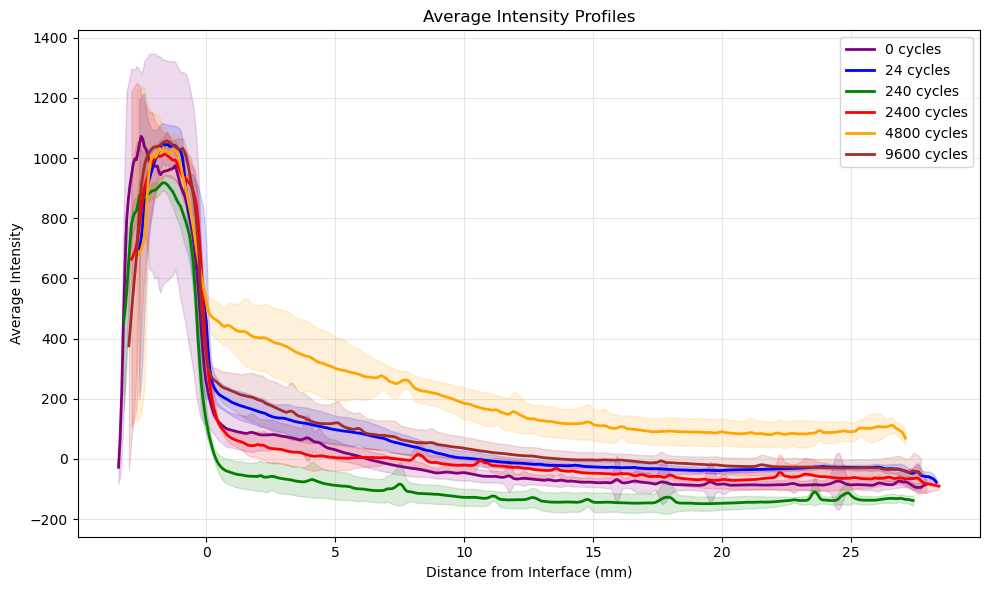

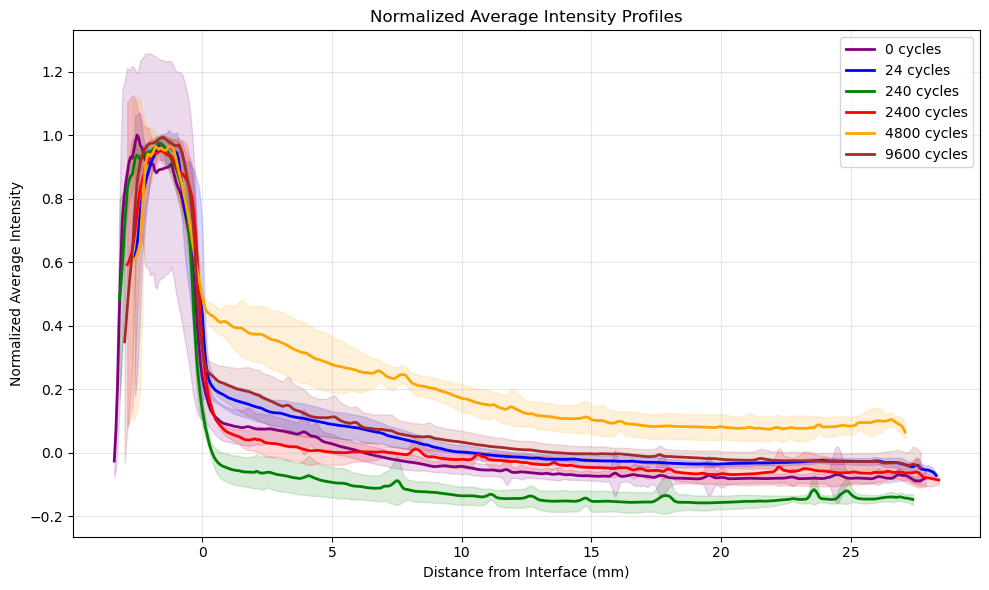

In [12]:
import pandas as pd
import numpy as np
import os
from scipy import interpolate
import matplotlib.pyplot as plt
import re

def plot_profiles(save_dir, save=False):
    # Read the averaged profiles
    intensity_dir = os.path.join(save_dir, 'Average_Intensity_Profile')
    
    # Read both normal and normalized files
    normal_file = os.path.join(intensity_dir, 'Averaged_Merged_Average_Intensity_Profile.xlsx')
    normalized_file = os.path.join(intensity_dir, 'Averaged_Normalized_Merged_Average_Intensity_Profile.xlsx')
    
    # Create figures
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    
    # Define distinct colors
    colors = ['purple', 'blue', 'green', 'red', 'orange', 'brown']
    line_width = 2
    
    # Read and plot normal profiles
    excel_file = pd.ExcelFile(normal_file)
    treatments = sorted(excel_file.sheet_names, 
                      key=lambda x: int(re.search(r'(\d+)C', x).group(1)) if re.search(r'(\d+)C', x) else 0)
    
    for i, treatment in enumerate(treatments):
        df = pd.read_excel(normal_file, sheet_name=treatment)
        cycles = re.search(r'(\d+)C', treatment).group(1)
        
        # Plot mean with error bands
        ax1.plot(df['Distance from Interface (mm)'], df['Average Intensity'], 
                label=f'{cycles} cycles', color=colors[i], linewidth=line_width)
        ax1.fill_between(df['Distance from Interface (mm)'],
                        df['Average Intensity'] - df['Population Std Dev'],
                        df['Average Intensity'] + df['Population Std Dev'],
                        alpha=0.15, color=colors[i])
    
    # Read and plot normalized profiles
    excel_file = pd.ExcelFile(normalized_file)
    
    for i, treatment in enumerate(treatments):
        df = pd.read_excel(normalized_file, sheet_name=treatment)
        cycles = re.search(r'(\d+)C', treatment).group(1)
        
        # Plot mean with error bands
        ax2.plot(df['Distance from Interface (mm)'], df['Normalized Average Intensity'],
                label=f'{cycles} cycles', color=colors[i], linewidth=line_width)
        ax2.fill_between(df['Distance from Interface (mm)'],
                        df['Normalized Average Intensity'] - df['Population Std Dev'],
                        df['Normalized Average Intensity'] + df['Population Std Dev'],
                        alpha=0.15, color=colors[i])
    
    # Customize normal plot
    ax1.set_xlabel('Distance from Interface (mm)')
    ax1.set_ylabel('Average Intensity')
    ax1.set_title('Average Intensity Profiles')
    ax1.legend()
    #ax1.grid(True, alpha=0.3)
    
    # Customize normalized plot
    ax2.set_xlabel('Distance from Interface (mm)')
    ax2.set_ylabel('Normalized Average Intensity')
    ax2.set_title('Normalized Average Intensity Profiles')
    ax2.legend()
    #ax2.grid(True, alpha=0.3)
    
    # Adjust layout to prevent label cutoff
    fig1.tight_layout()
    fig2.tight_layout()
    
    if save:
        # Save plots
        fig1.savefig(os.path.join(intensity_dir, 'Average_Intensity_Profiles.png'), 
                     dpi=300, bbox_inches='tight')
        fig2.savefig(os.path.join(intensity_dir, 'Normalized_Average_Intensity_Profiles.png'), 
                     dpi=300, bbox_inches='tight')
        plt.close('all')
        return "Plots created and saved successfully!"
    else:
        plt.show()
        return "Plots displayed successfully!"

if __name__ == "__main__":
    plot_profiles(save_dir, save=False)  # Set save=True to save files, False to display

